# **ML - Home Work \#2**

**Stav Suzan Rabinovich**
 

## **Start, Settings, Data Imports and My Functions**

### **Installations**

In [1]:
!pip install --upgrade plotly
!pip install sweetviz
!pip install autoviz
!pip install tqdm
!pip install --upgrade scikit-learn

     |████████████████████████████████| 15.1 MB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 22.3 MB 31.7 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.0 which is incompatible.


### **Imports and Data Import**

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sw 
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# sklearn imports
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn import pipeline
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet
from sklearn.linear_model import SGDRegressor, LinearRegression

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures

from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import neural_network 
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer


# --- #

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
# Reading in the data
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

### **My functions**
Functions that I created to use in my code. 

In [4]:
def fill_na_as_zero(df,columns_name):               # Fill empty columns with 0  
  for column_name in columns_name:
    fill_na_as_zero_col(df,column_name)

def fill_na_as_zero_col(df,column_name):
    df_not_null = df[~df[column_name].isnull()]
    df[column_name].fillna(0, inplace=True) 

def create_pie_chart_of_count(df, column_name):     # Pie Chart
    df_not_null = df[~df[column_name].isnull()]
    fig = px.pie(df_not_null.groupby([column_name]).size().reset_index(name='count'), names=column_name, values='count')
    fig.show()

def create_pie_chart_with_nulls(df,column_name):    # Fill pie chart with the null values
  df_forChart = df.copy()
  fill_na_as_zero_col(df_forChart,column_name)
  create_pie_chart_of_count(df_forChart,column_name)

def create_sunburst(df,column_name,columns_arr):    # Create sunburst charts of the features
  df_cpy = df.copy()
  df_cpy.insert(len(df_cpy.columns),column_name,1,True)
  fig = px.sunburst(df_cpy, path = columns_arr, values=column_name)
  fig.update_layout(margin=dict(t=10, l=10, r=10, b=10))
  fig.show()

## **About The Task**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In this task I predicted the selling prices using linear regression, data cleansing, Gradient Boosting Regressor and also 

## **Let's Start With The Data**

### **About The Data**

As we can see, we have 80 features and 1460 samples on the train set and 1459 on the test set.\
I'll explore the data using the train data (df = train).


In [5]:
print("\nThe train data size is: {} \n".format(train.shape))
train.info()

print("\nThe test data size is: {} \n".format(test.shape))
test.info()


The train data size is: (1460, 81) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual   

To make sure that there are no missing data and all data's features will be used correctly, I'll perform \
data cleansing before exploring. (there are cases when NaN or NA refers to the answer, such as: No pool).


### **Data Cleansing**

If we will look at first, we can find some NA and NaN values,\
but in some features, the null itself resamble value (for example: No pool).

We can see a lot of missing values:





In [6]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

Train    Test
MSZoning          0     4.0
LotFrontage     259   227.0
Alley          1369  1352.0
Utilities         0     2.0
Exterior1st       0     1.0
Exterior2nd       0     1.0
MasVnrType        8    16.0
MasVnrArea        8    15.0
BsmtQual         37    44.0
BsmtCond         37    45.0
BsmtExposure     38    44.0
BsmtFinType1     37    42.0
BsmtFinSF1        0     1.0
BsmtFinType2     38    42.0
BsmtFinSF2        0     1.0
BsmtUnfSF         0     1.0
TotalBsmtSF       0     1.0
Electrical        1     0.0
BsmtFullBath      0     2.0
BsmtHalfBath      0     2.0
KitchenQual       0     1.0
Functional        0     2.0
FireplaceQu     690   730.0
GarageType       81    76.0
GarageYrBlt      81    78.0
GarageFinish     81    78.0
GarageCars        0     1.0
GarageArea        0     1.0
GarageQual       81    78.0
GarageCond       81    78.0
PoolQC         1453  1456.0
Fence          1179  1169.0
MiscFeature    1406  1408.0
SaleType          0     1.0

After using **Dummy Encoding**, the number of missing values is really small.



### **Dummy Encoding**

*From now on, we will use train_df and test_df*

In [7]:
train_df = pd.get_dummies(train)
train_df.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLw  SaleType_New  \
0          2003       196.0         706  ...               0             0   
1          1976         0.0         978  ...               0             0   
2          2002       162.0         486  ...               0             0   
3          1970         0.0         216  ...               0             0   
4          2000       350.0         655  ...               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0            1                      0                      0   
1             0            1                      0                      0   
2             0            1                      0                      0   
3             0            1                      1                      0   
4             0            1                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 290 columns]

In [8]:
test_df = pd.get_dummies(test)
test_df.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0  1461          20         80.0    11622            5            6   
1  1462          20         81.0    14267            6            6   
2  1463          60         74.0    13830            5            5   
3  1464          60         78.0     9978            6            6   
4  1465         120         43.0     5005            8            5   

   YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLw  \
0       1961          1961         0.0       468.0  ...               0   
1       1958          1958       108.0       923.0  ...               0   
2       1997          1998         0.0       791.0  ...               0   
3       1998          1998        20.0       602.0  ...               0   
4       1992          1992         0.0       263.0  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      0   
4             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     1                      0  
4                     1                      0  

[5 rows x 271 columns]

In [9]:
NAs = pd.concat([train_df.isnull().sum(),test_df.isnull().sum()], axis=1, keys=['Train','Test'])
NAs[NAs.sum(axis=1) > 0]

Train   Test
LotFrontage     259  227.0
MasVnrArea        8   15.0
BsmtFinSF1        0    1.0
BsmtFinSF2        0    1.0
BsmtUnfSF         0    1.0
TotalBsmtSF       0    1.0
BsmtFullBath      0    2.0
BsmtHalfBath      0    2.0
GarageYrBlt      81   78.0
GarageCars        0    1.0
GarageArea        0    1.0

*All missing features relates to exsists and non-exsists house features\
 that we can fill with zeros (because they are not exsists).*

In [10]:
# Train_df filling with zeros
fill_na_as_zero(train_df,['LotFrontage','MasVnrArea','GarageYrBlt'])
# Test_df filling with zeros
fill_na_as_zero(test_df,['LotFrontage','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                         'BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea'])

Now when there are no missing values,\
and we may continue with data exploring:

### **Data Exploring**

In [11]:
train_df.info()
print()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 290 entries, Id to SaleCondition_Partial
dtypes: float64(3), int64(35), uint8(252)
memory usage: 792.9 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 271 entries, Id to SaleCondition_Partial
dtypes: float64(11), int64(26), uint8(234)
memory usage: 755.3 KB


We can see from here that all of our features are numerical (and not categorical).

#### **Target Variable**

We can see that `SalePrice` is our target (int64 value, and missing column in the test's df).\
Let's see the target variable:

In [12]:
# Get the fitted parameters used by the function norm
mu, sigma = norm.fit(train_df['SalePrice'])

fig = px.histogram(data_frame=train_df, x='SalePrice')
fig.update_layout(
    title_text=f'SalePrice distribution - mu= {mu:.3f}, sigma= {sigma:.3f}',
    xaxis_title_text='SalePrice',
    yaxis_title_text='Count',
    bargap=0.2, # Gap between bars of adjacent location coordinates
)
fig.show()

From this historgram, we can conclude that the most house prices are in the range of 80K to 400K.



#### **SweetViz**

                                             |          | [  0%]   00:00 -> (? left)


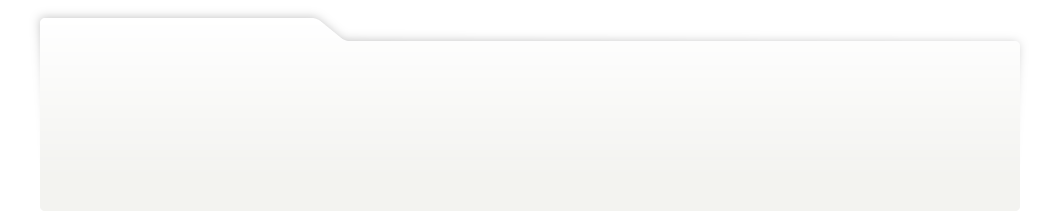
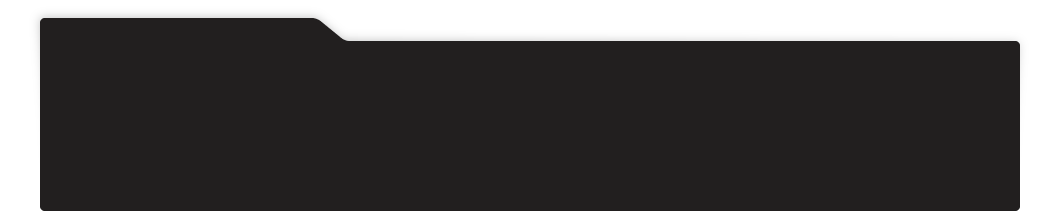
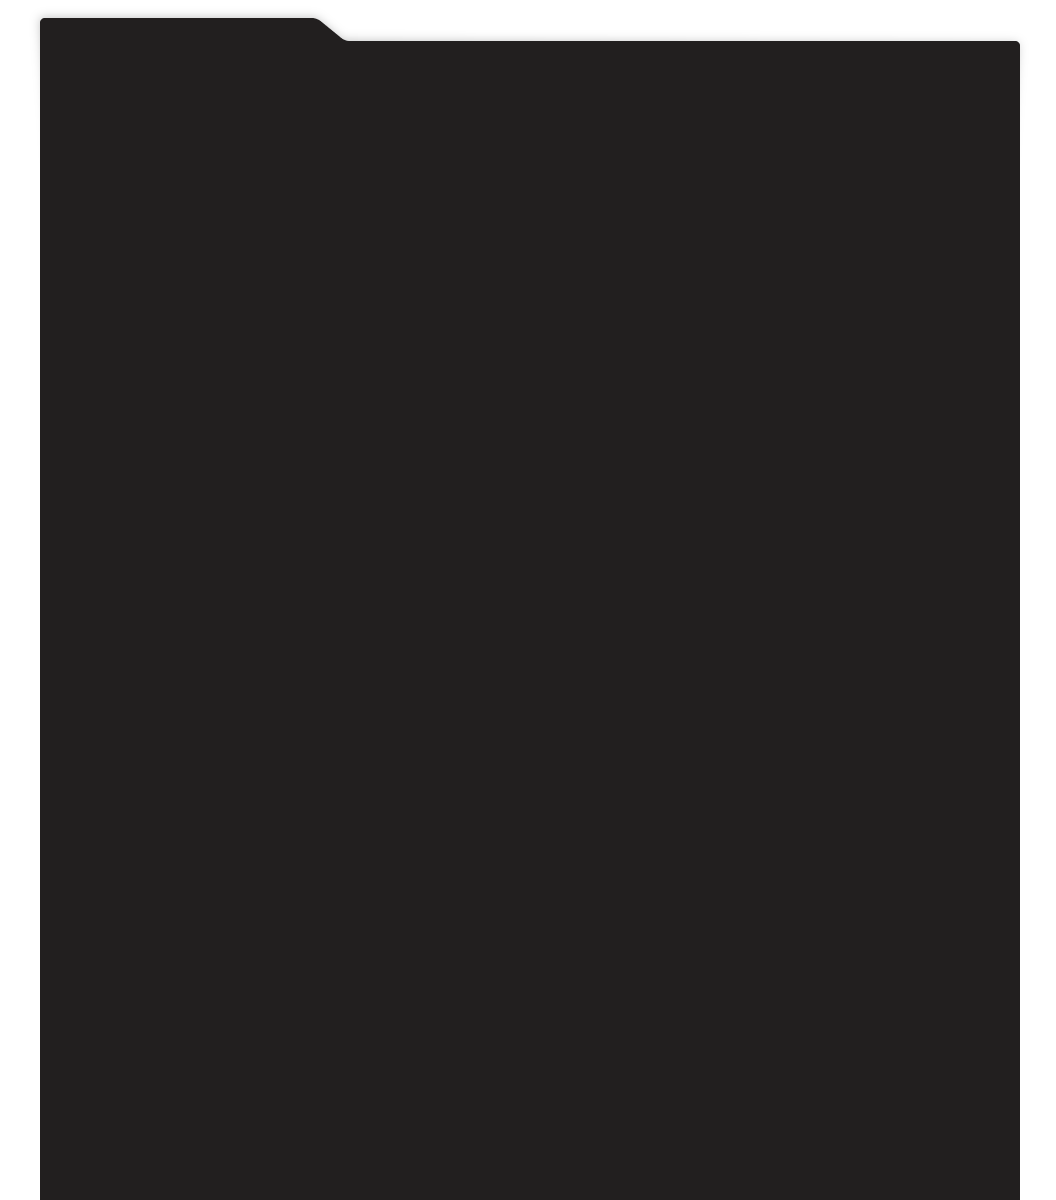
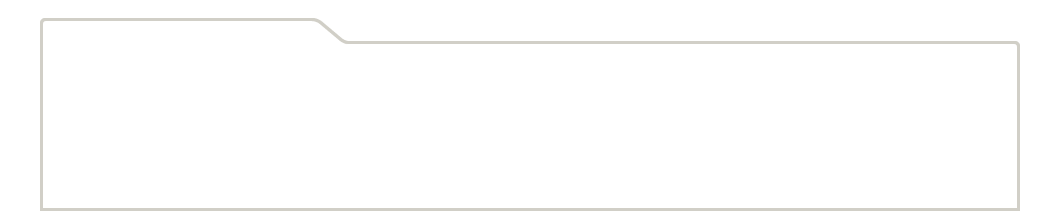
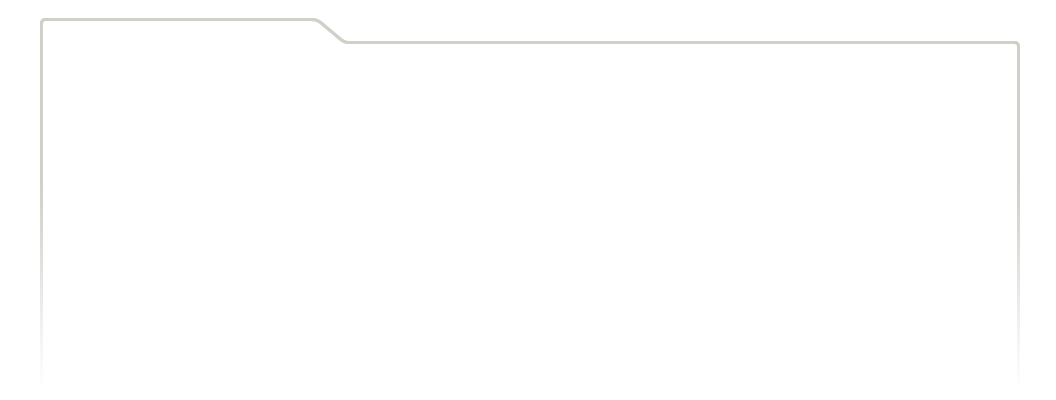
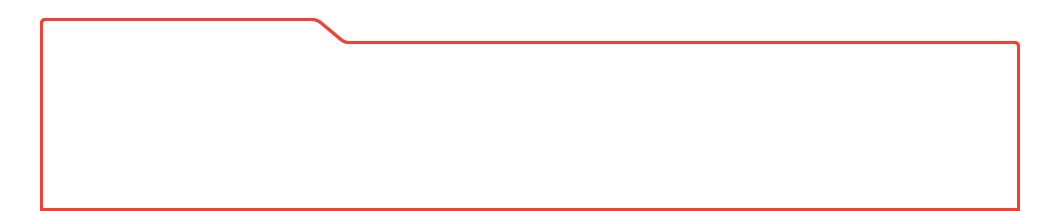
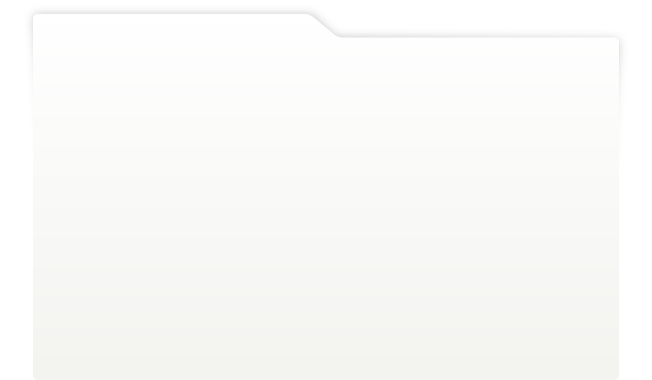
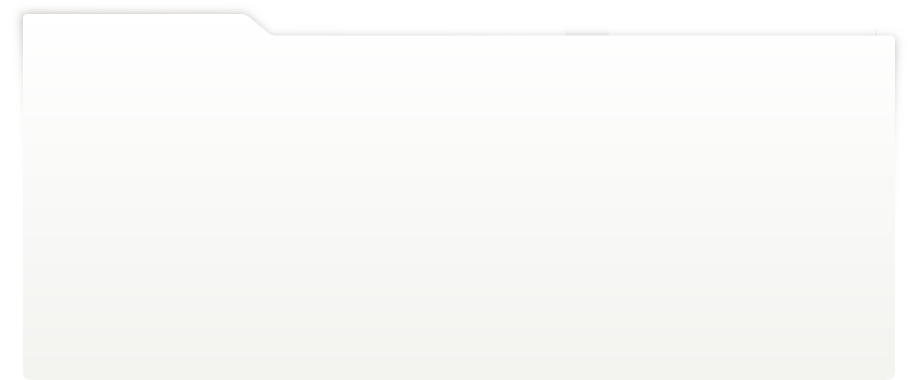
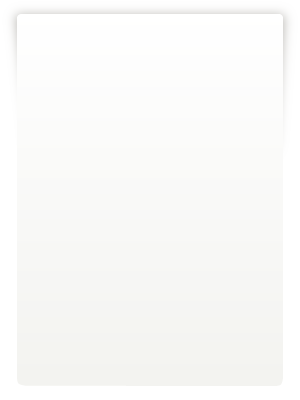
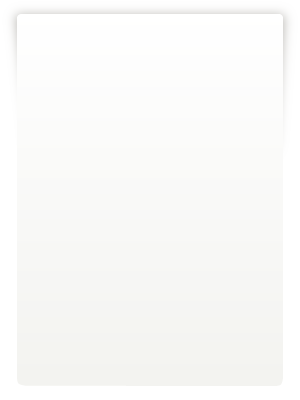
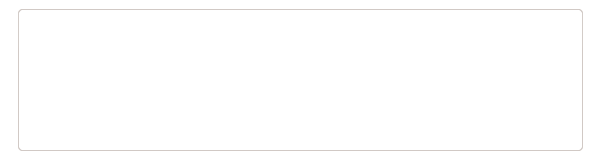
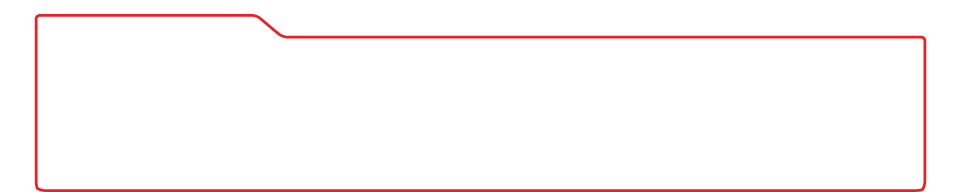
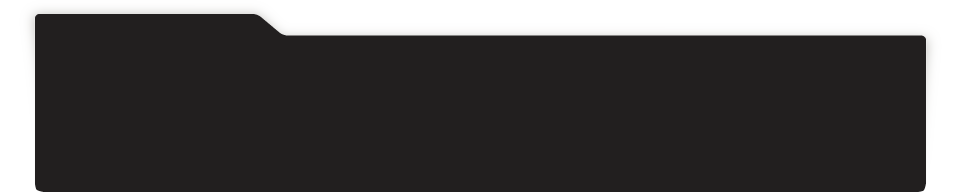
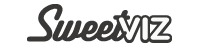
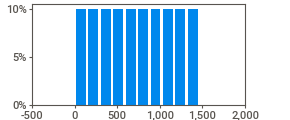
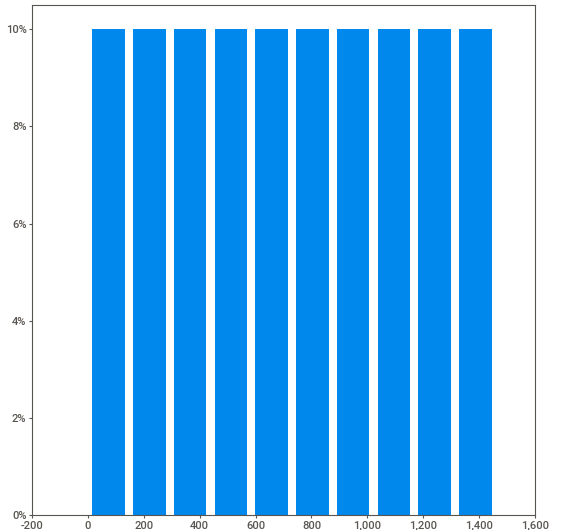
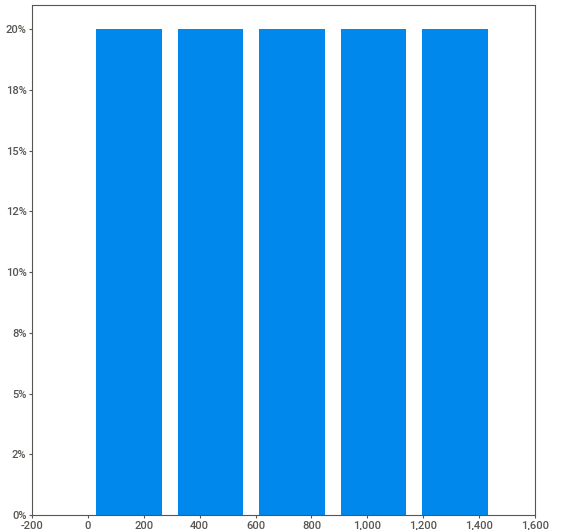
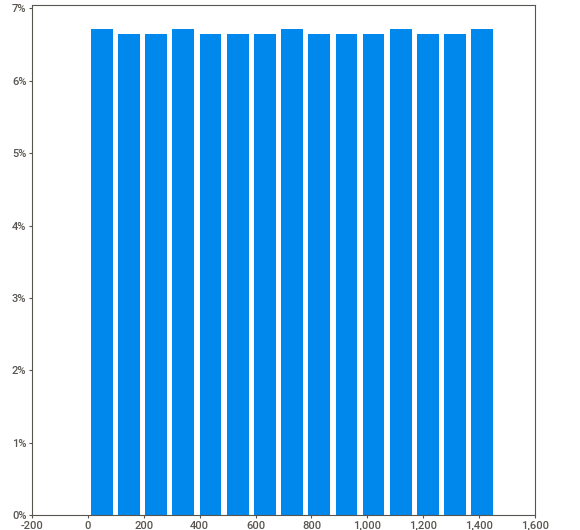
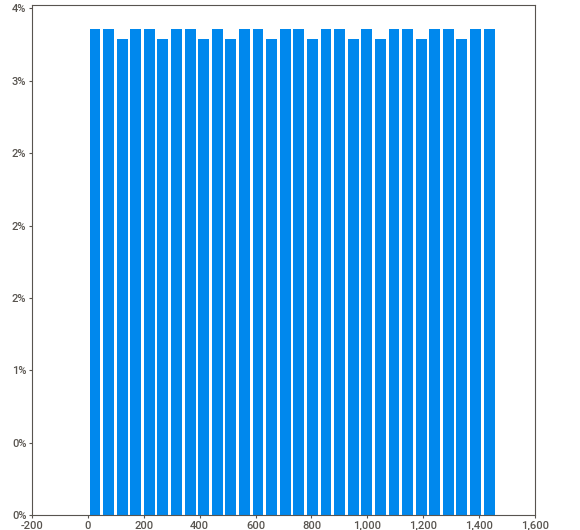
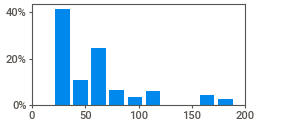
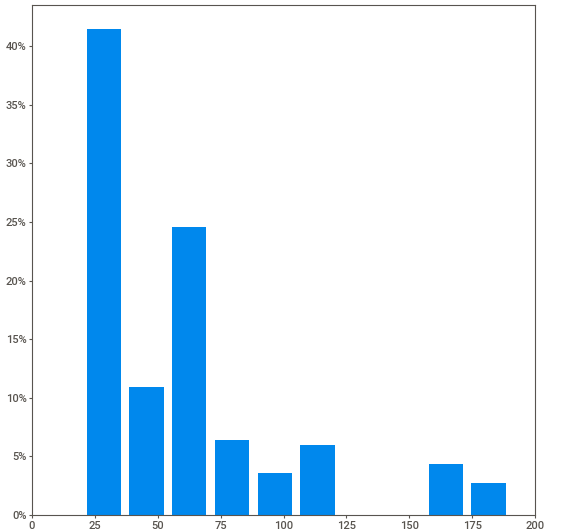
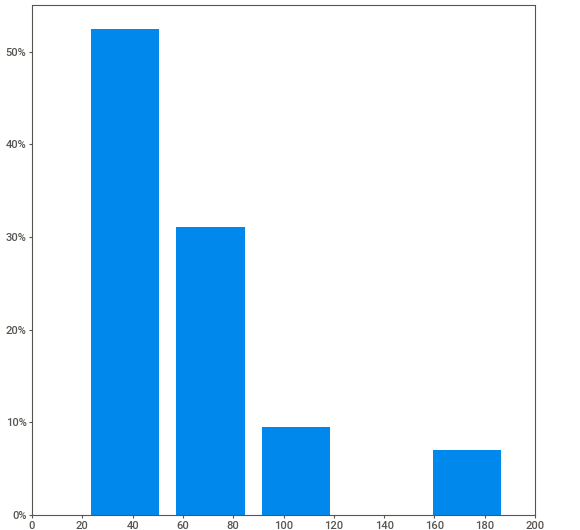
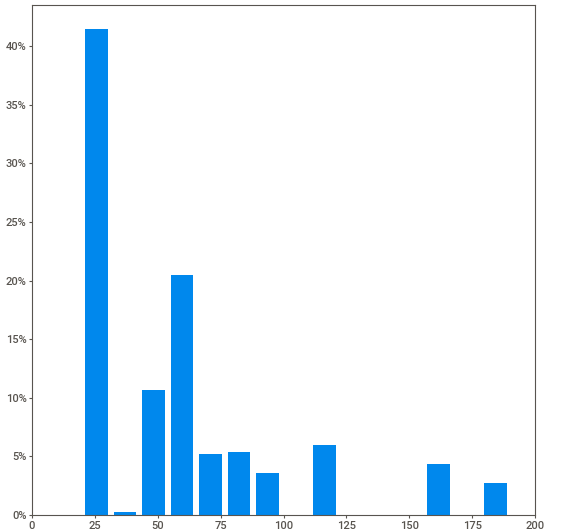
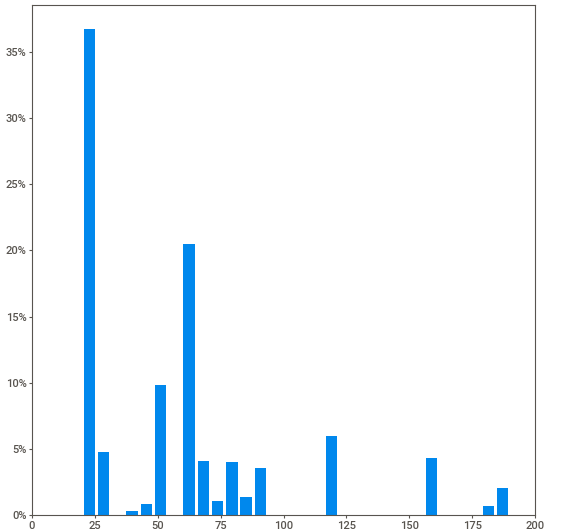
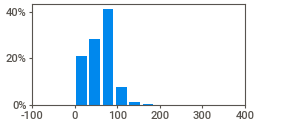
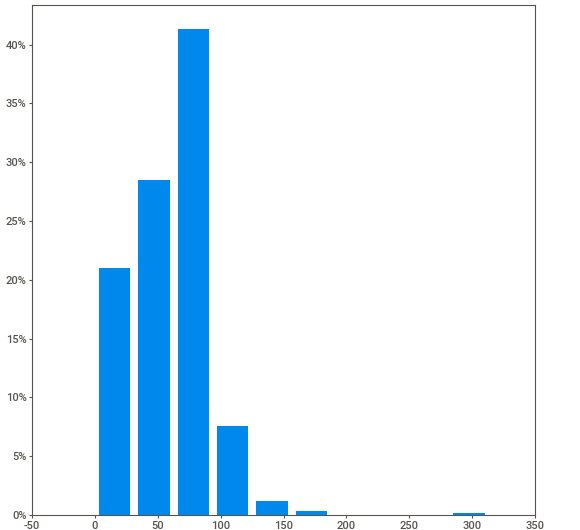
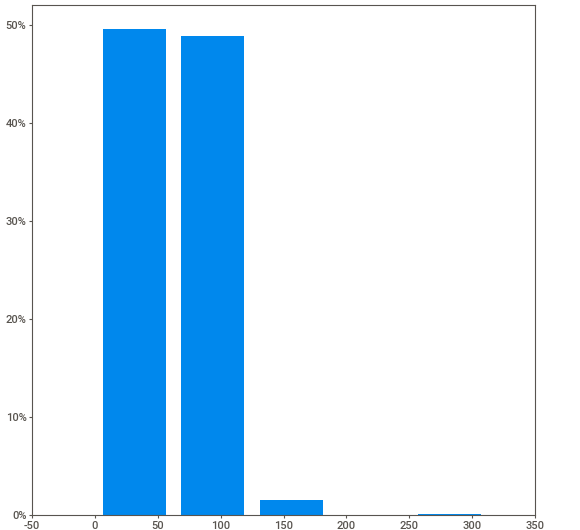
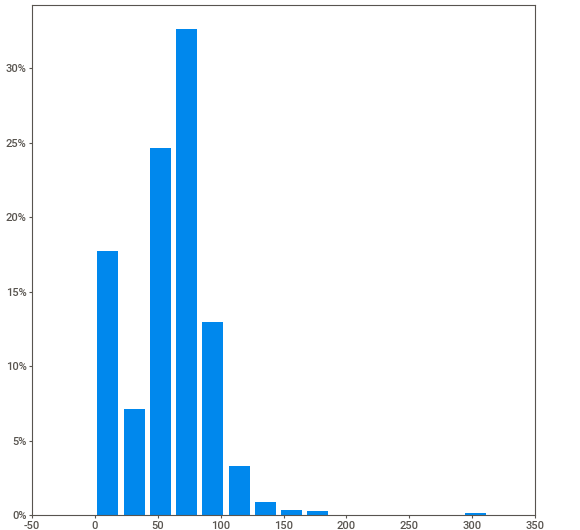
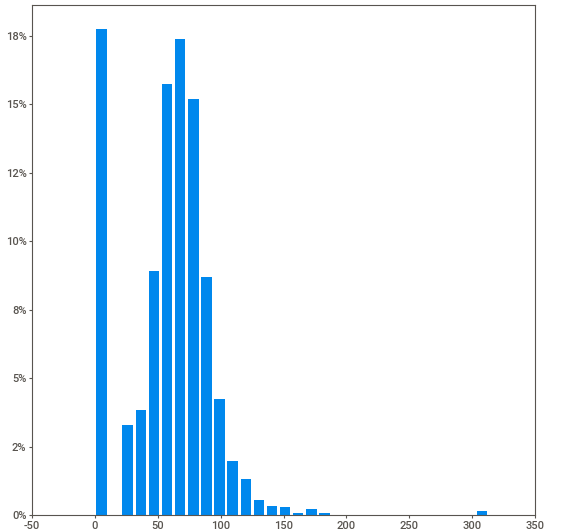
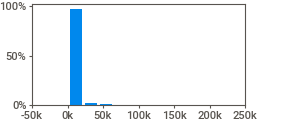
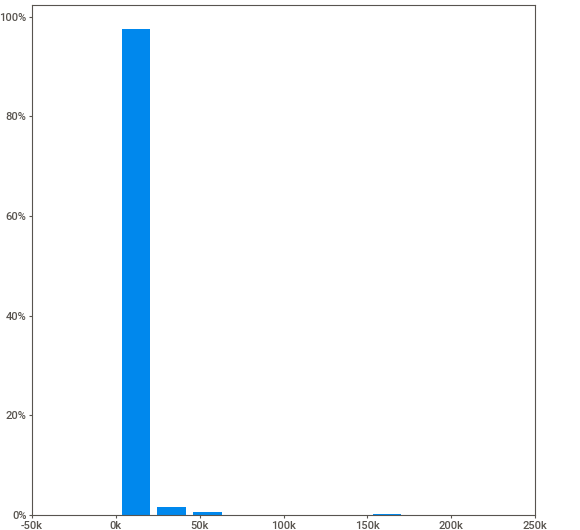
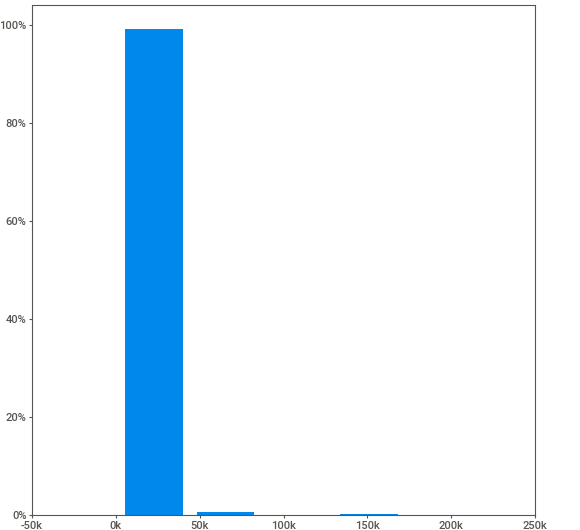
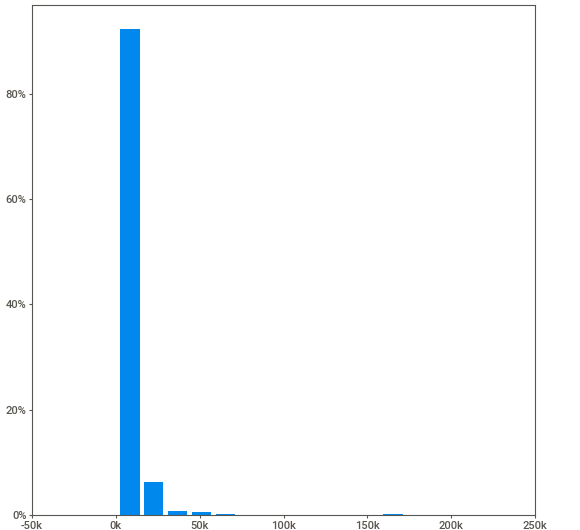
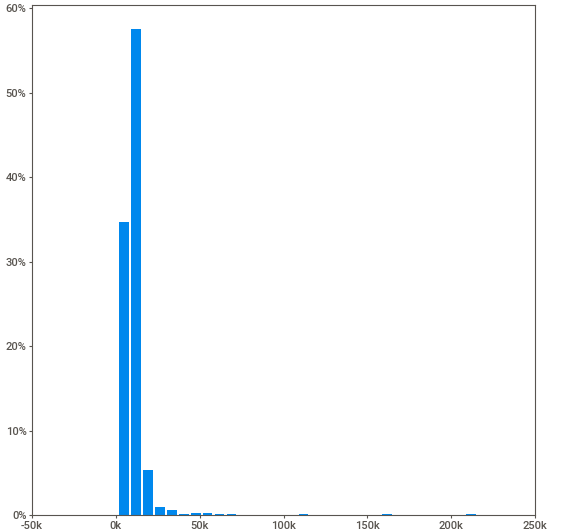
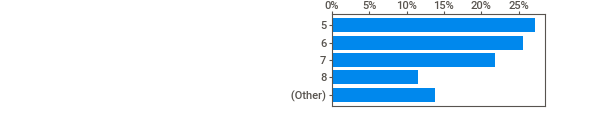
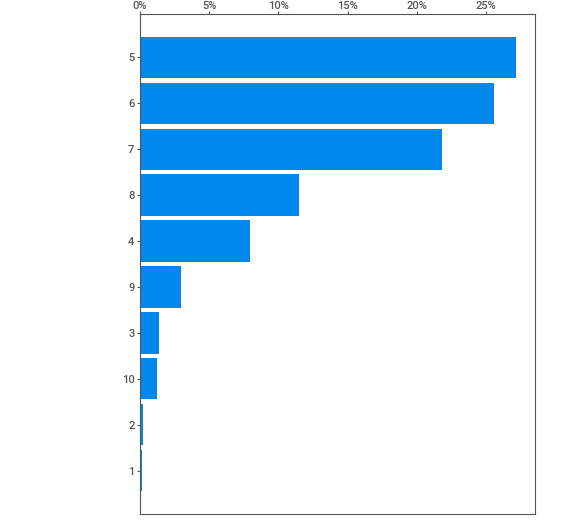
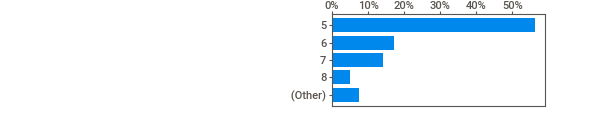
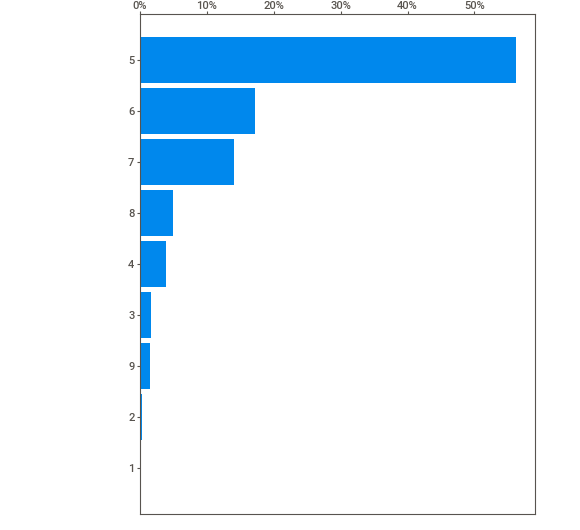
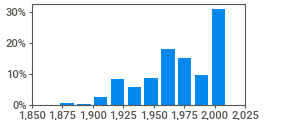
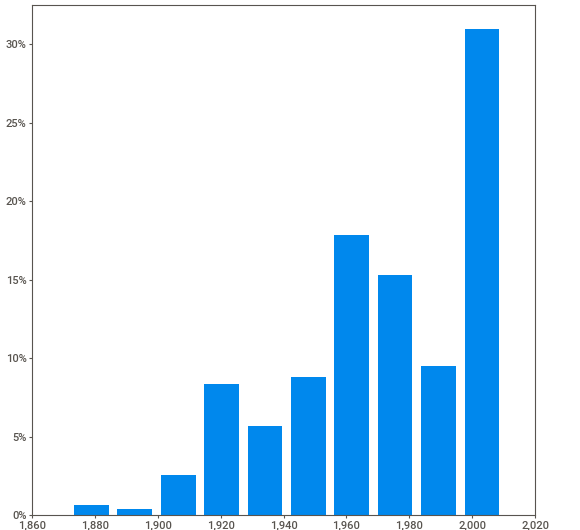
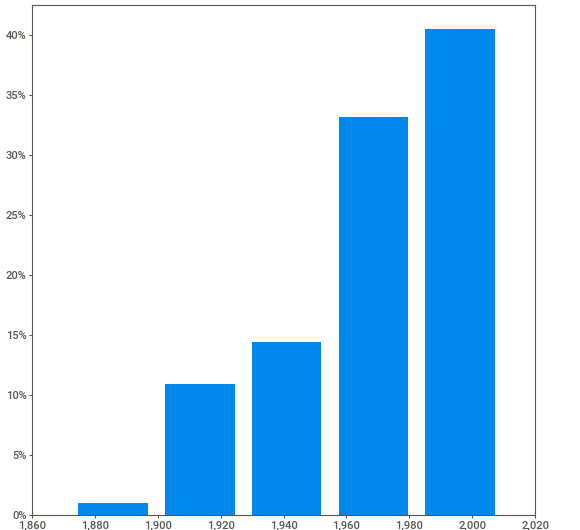
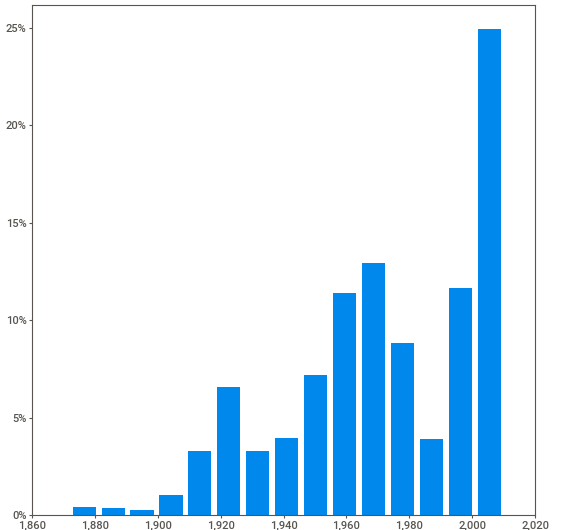
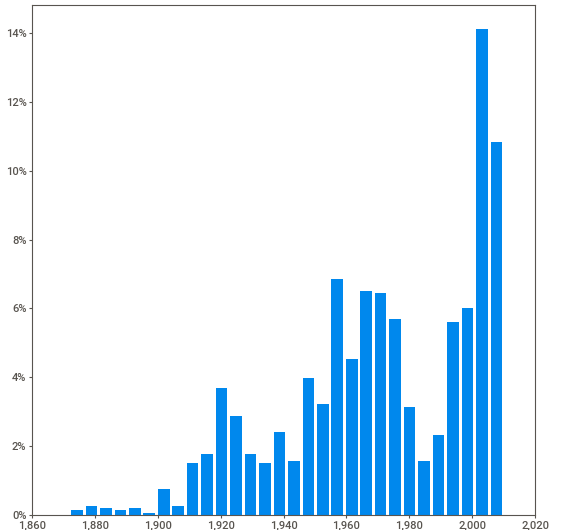
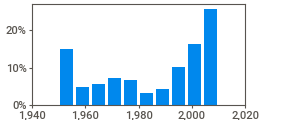
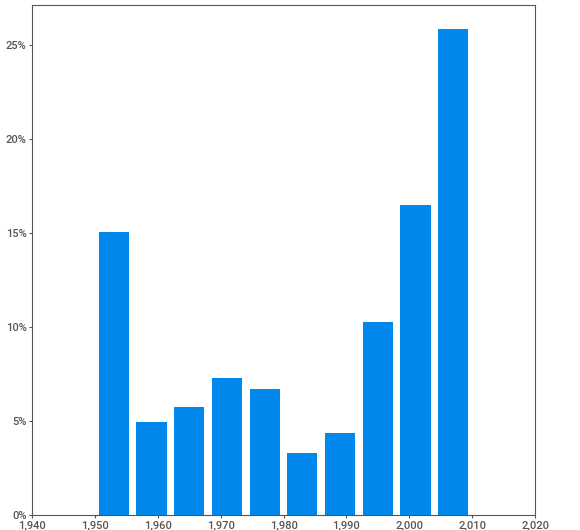
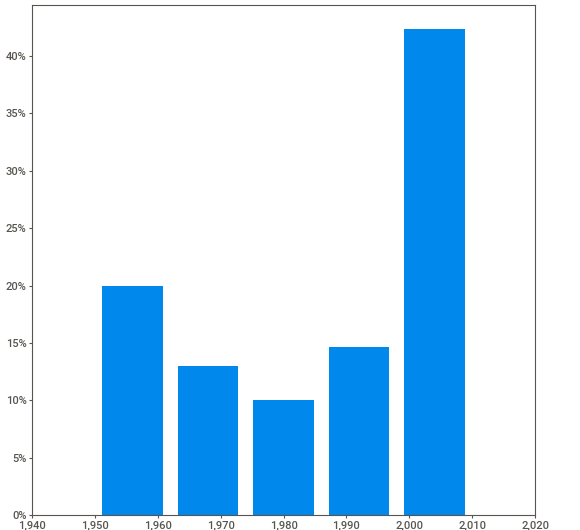
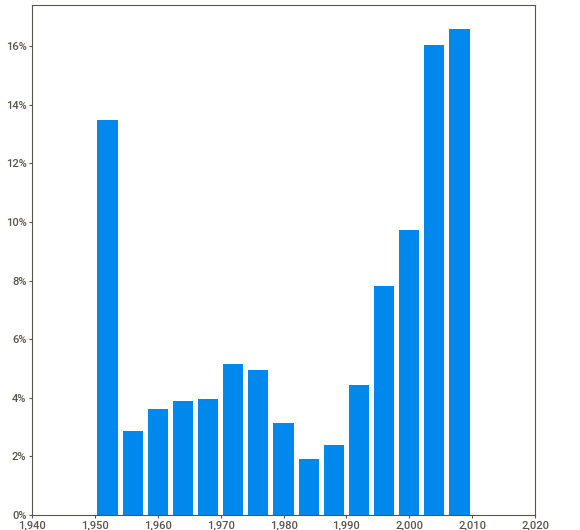
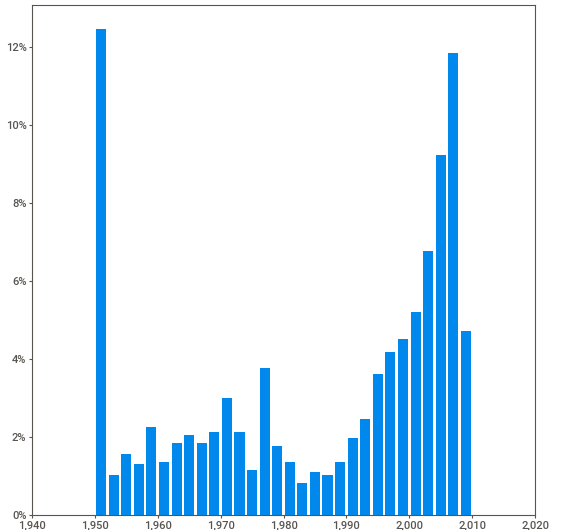
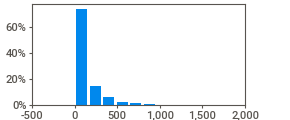
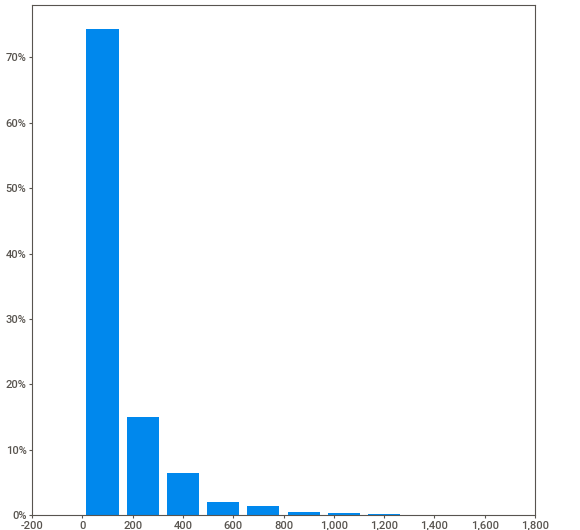
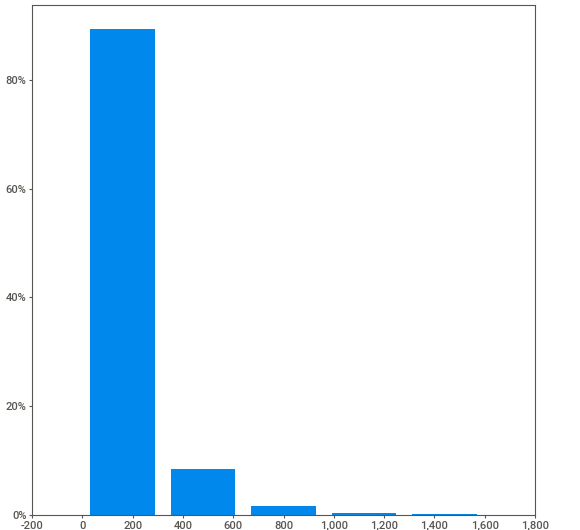
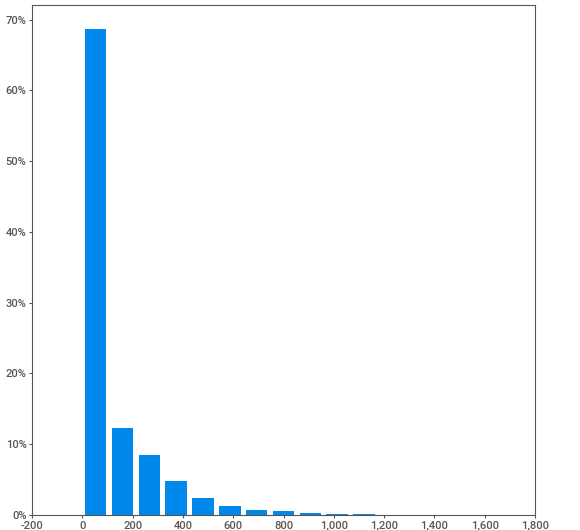
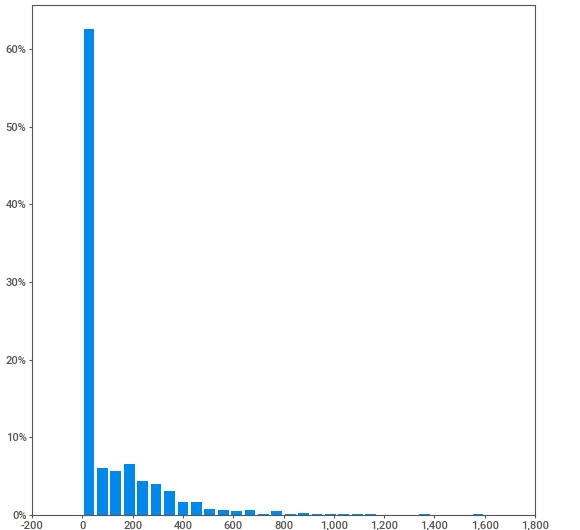
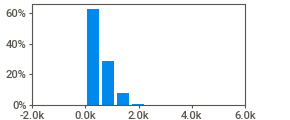
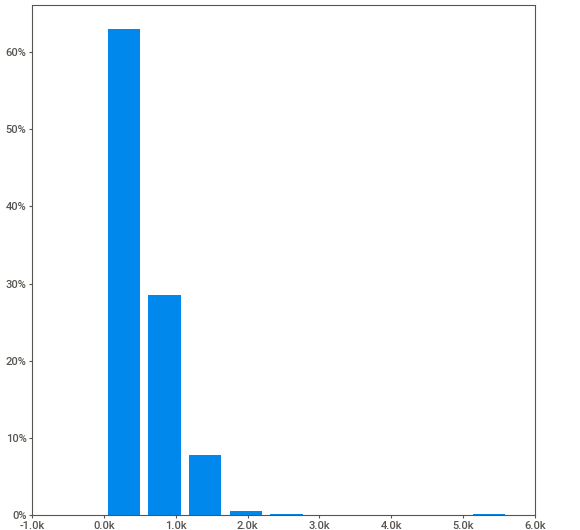
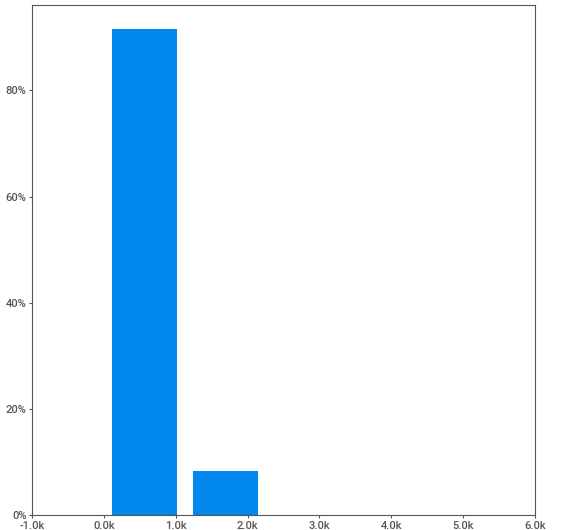
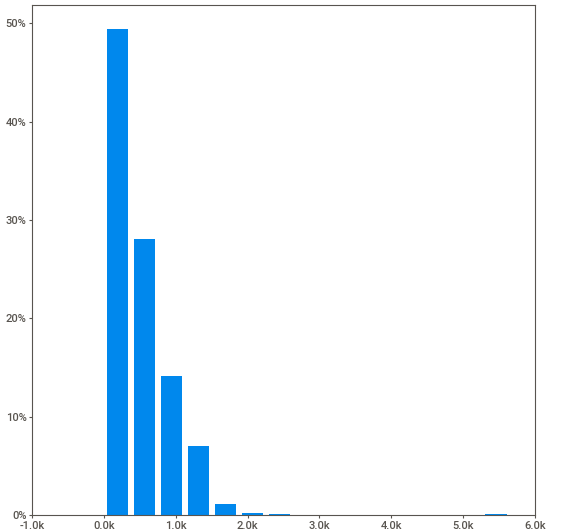
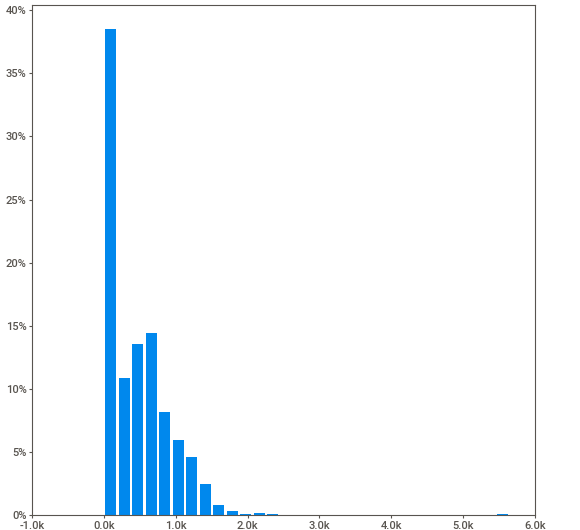
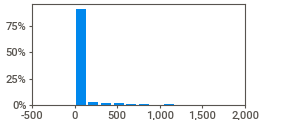
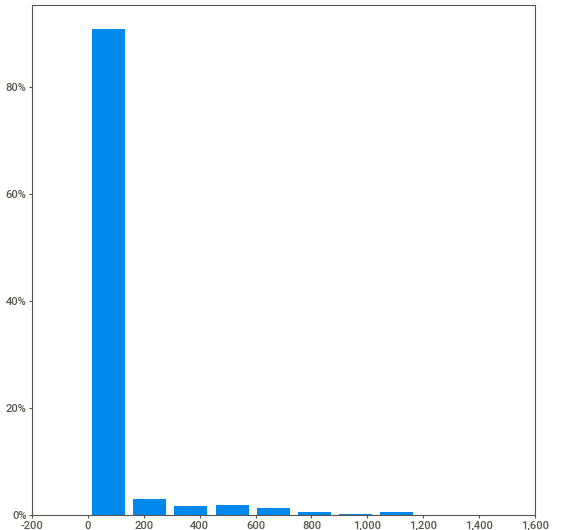
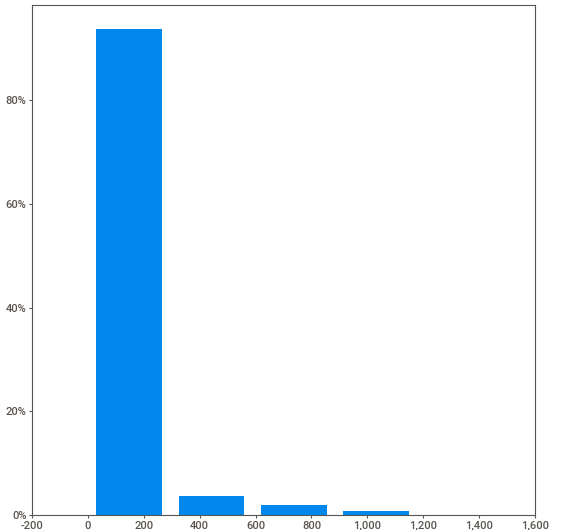
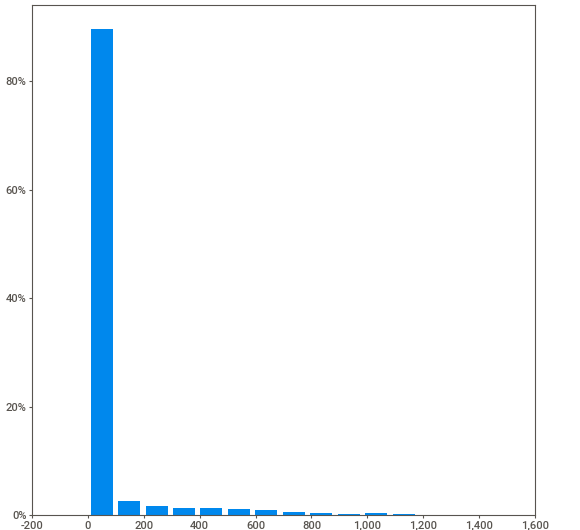
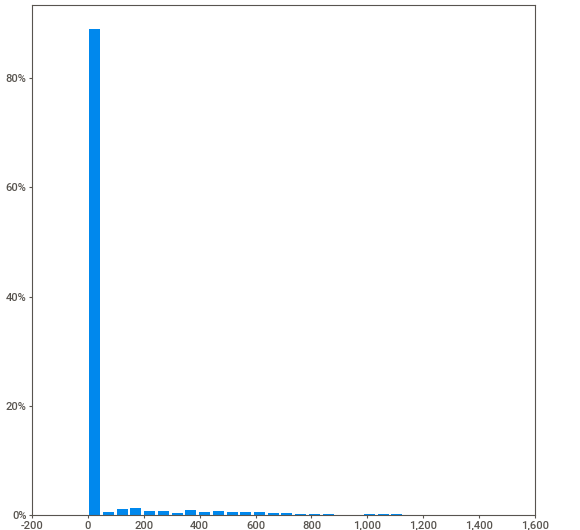
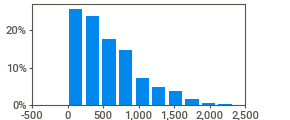
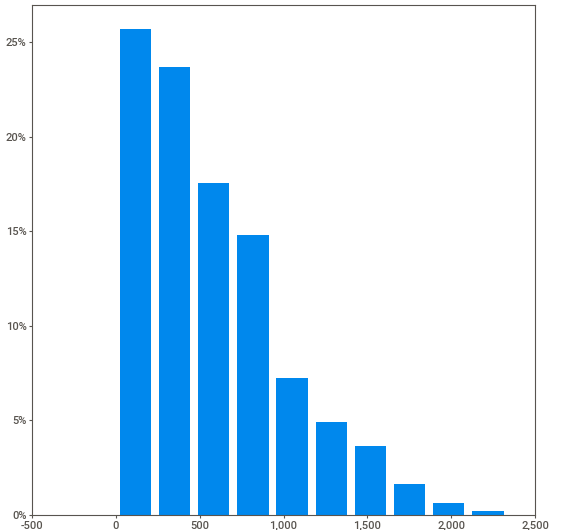
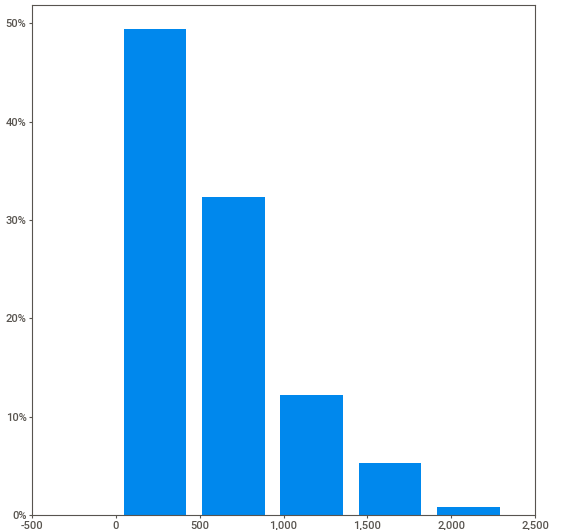
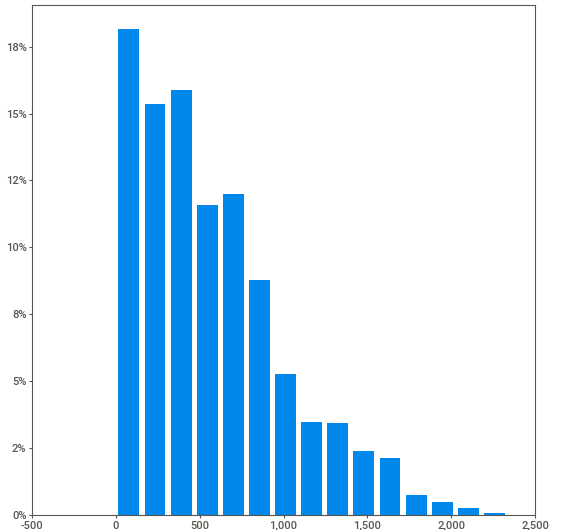
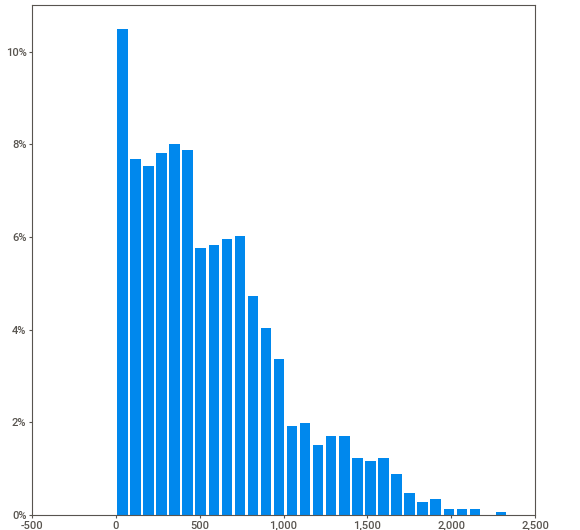
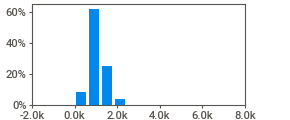
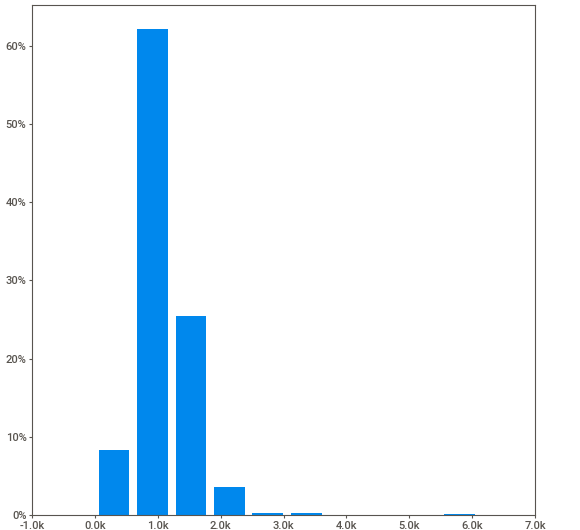
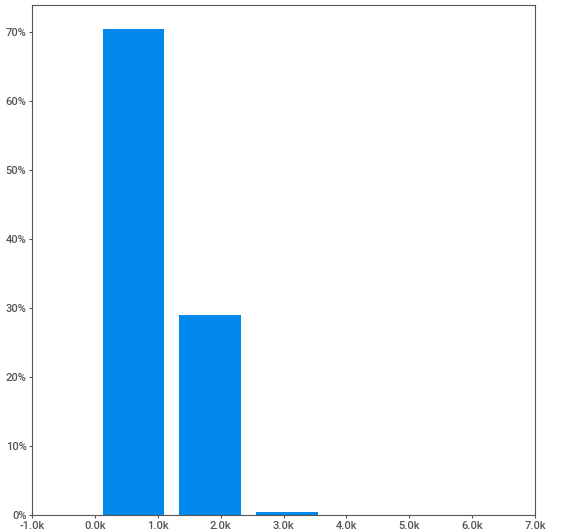
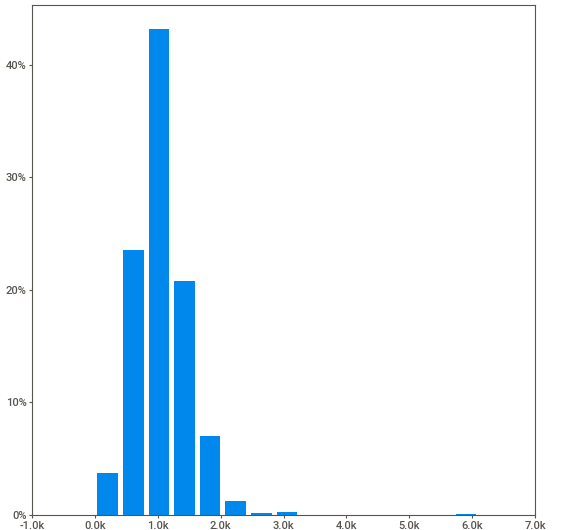
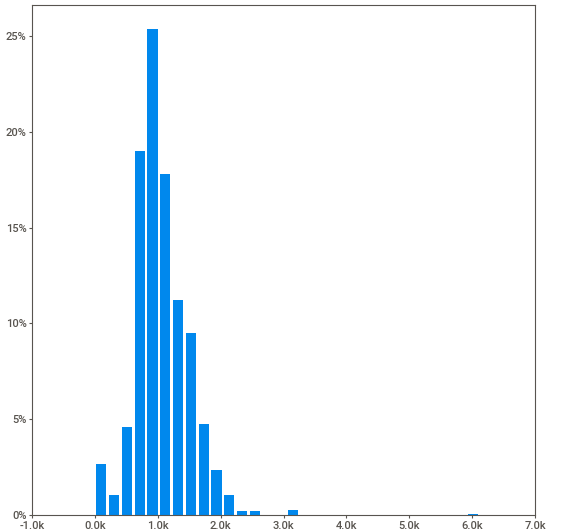
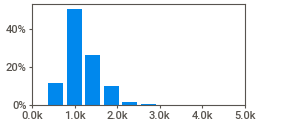
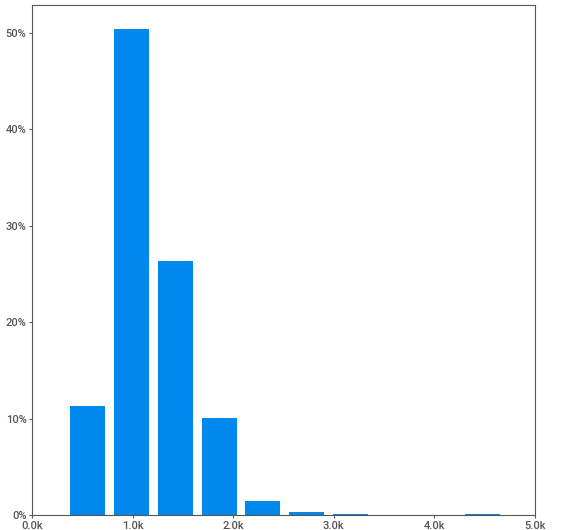
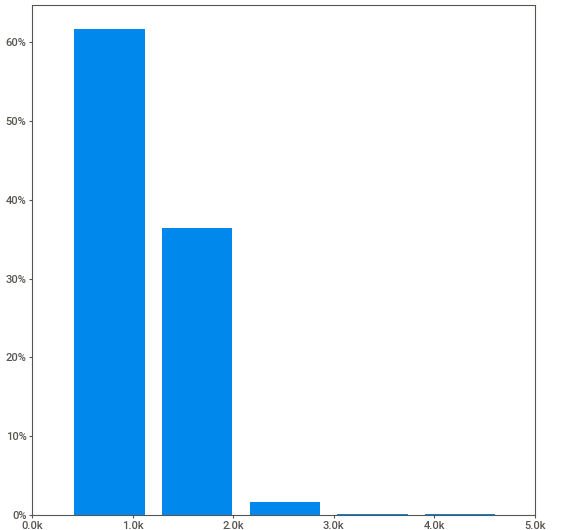
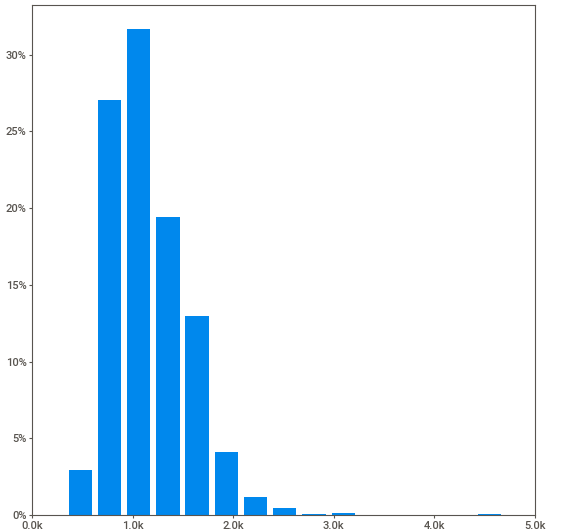
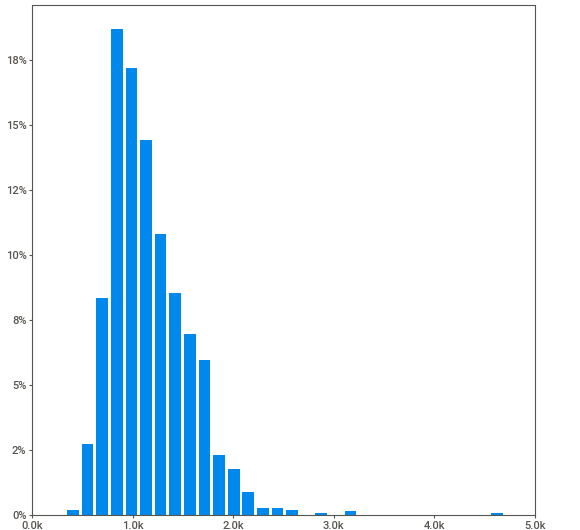
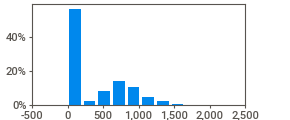
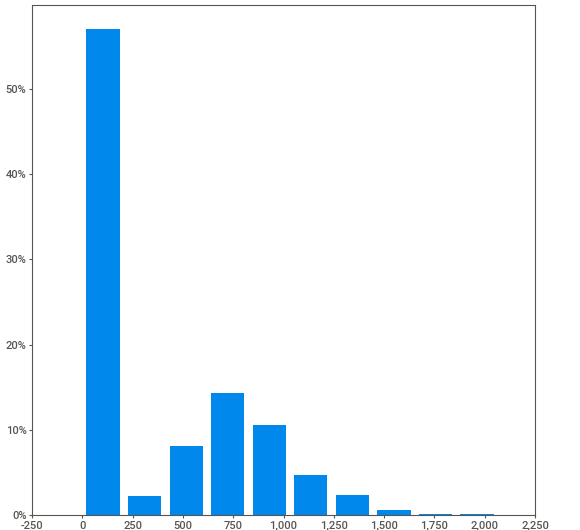
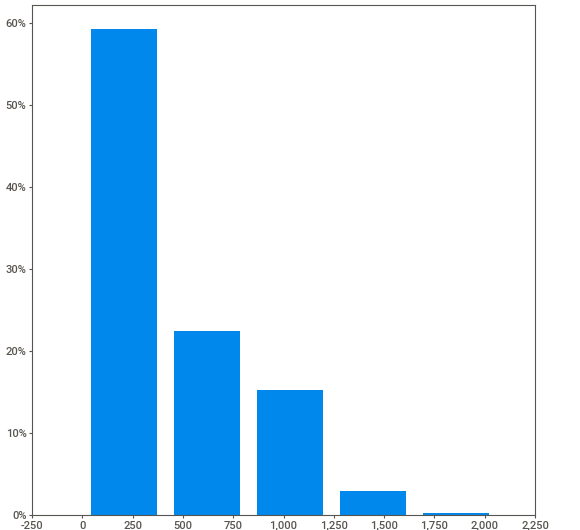
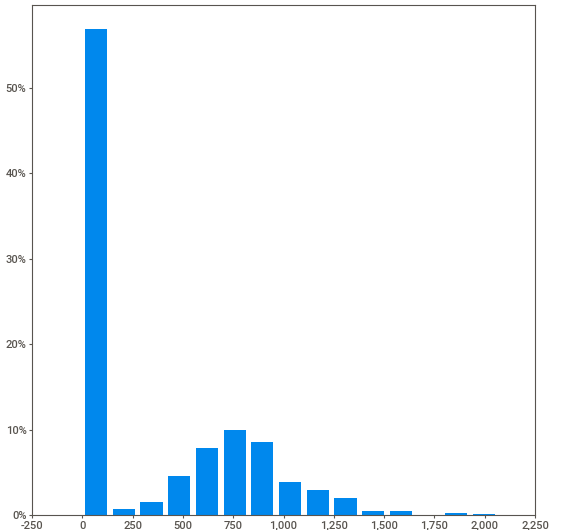
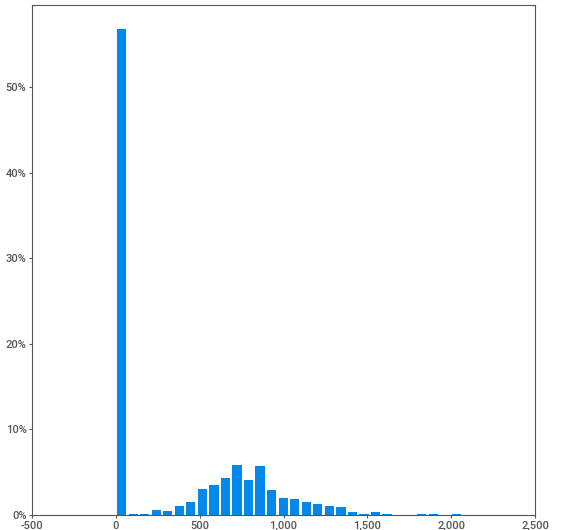
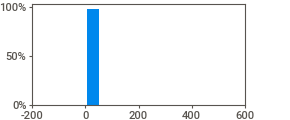
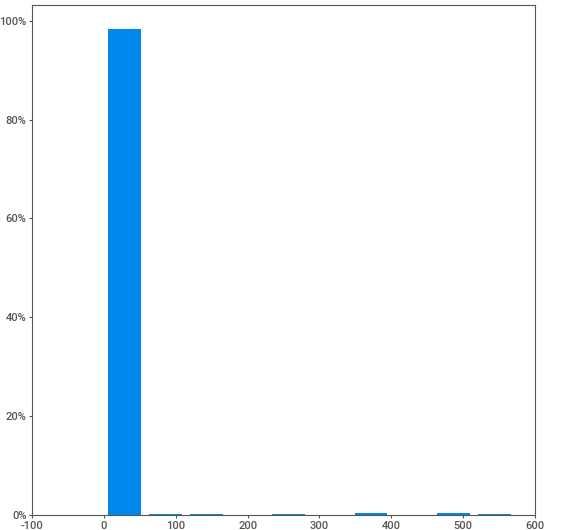
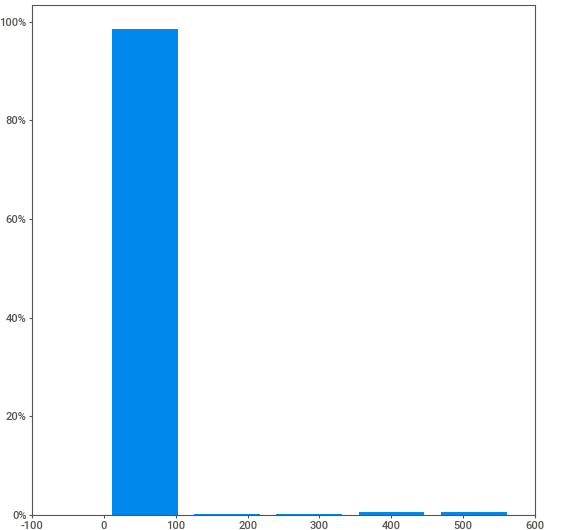
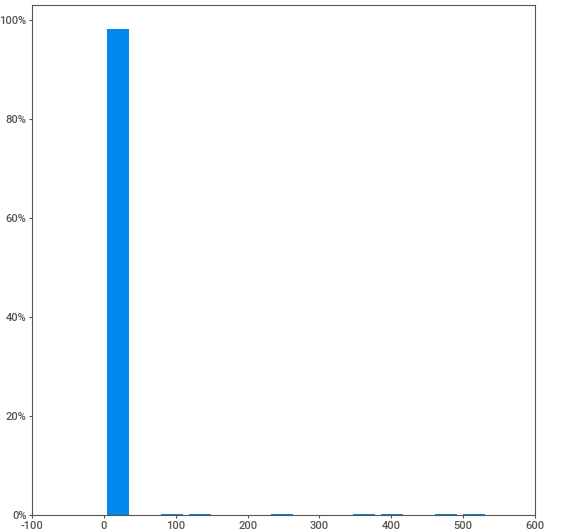
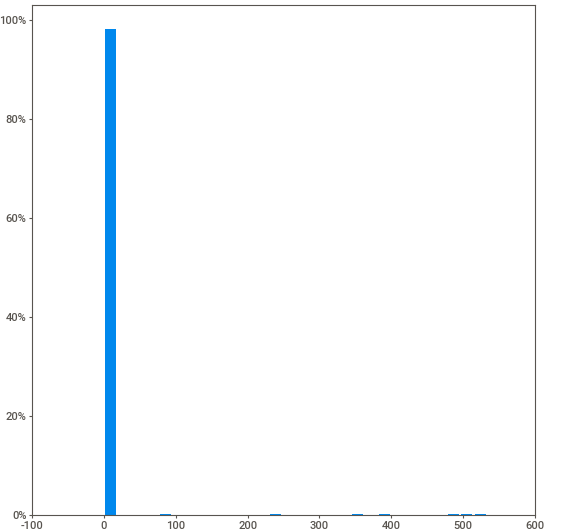
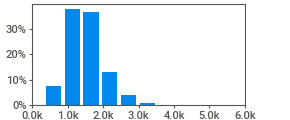
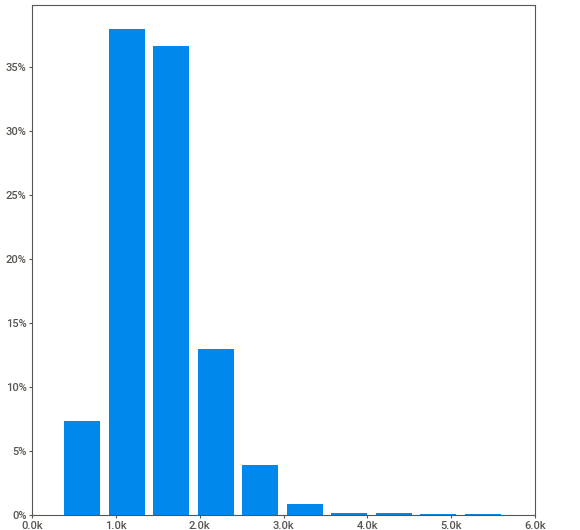
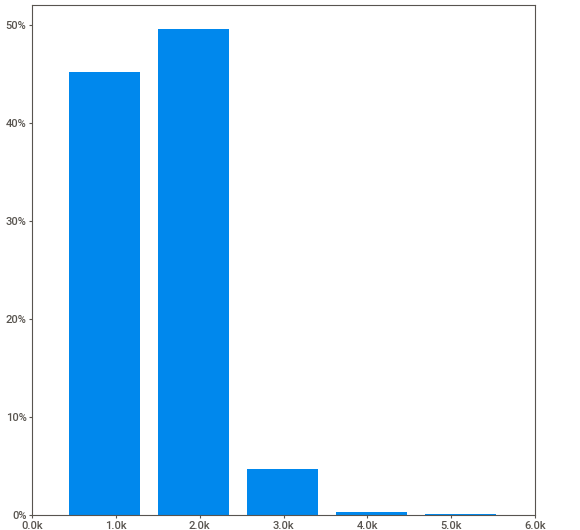
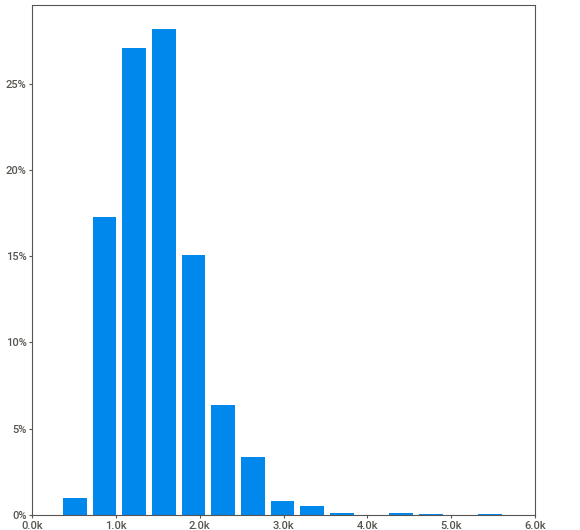
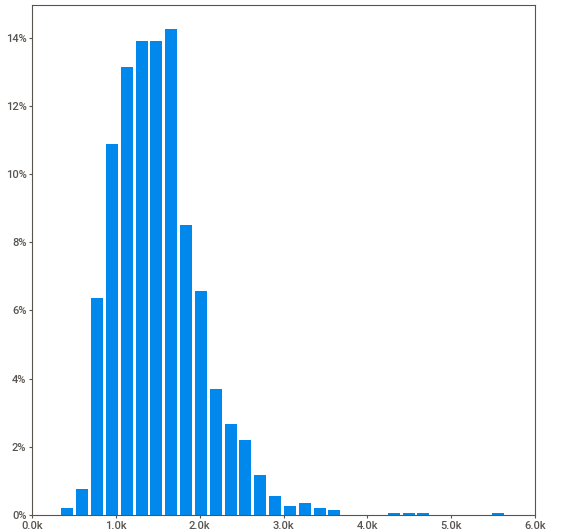
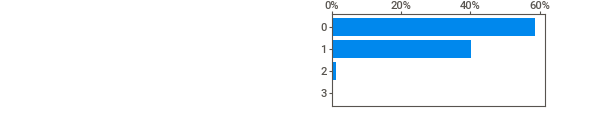
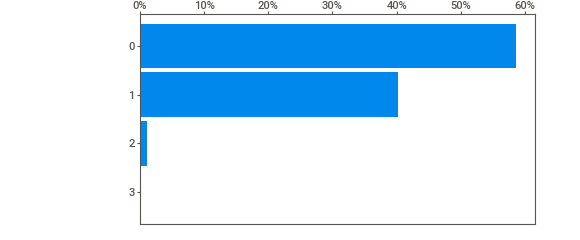
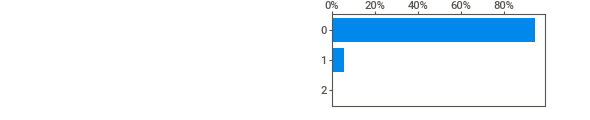
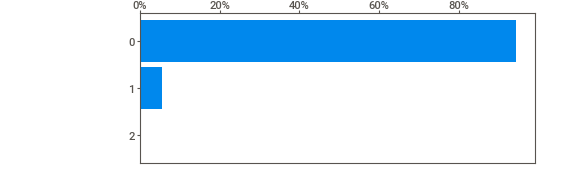
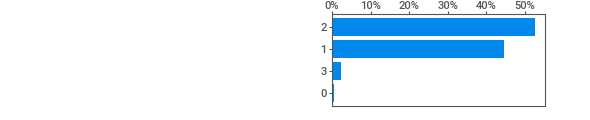
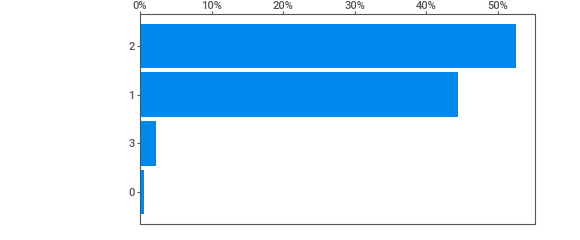
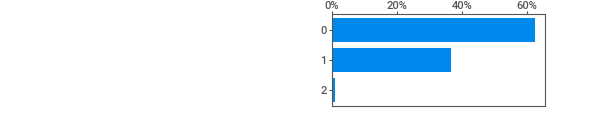
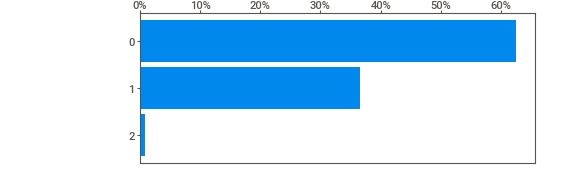
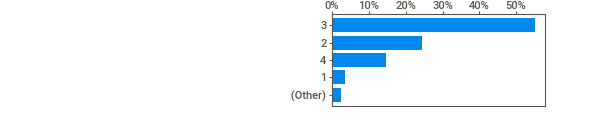
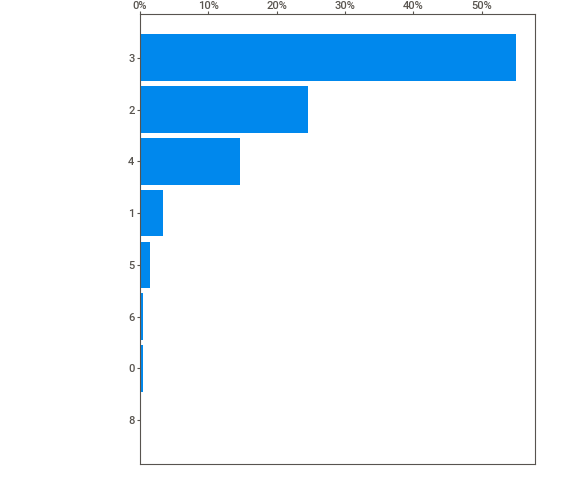
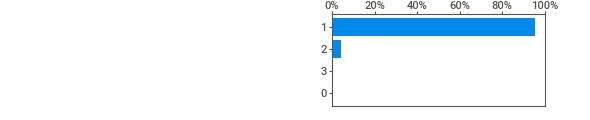
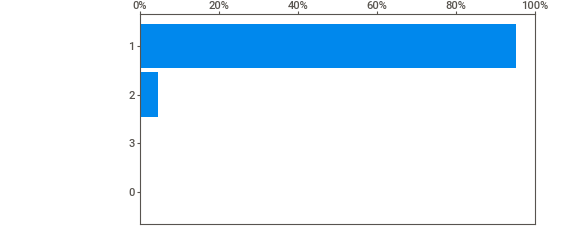
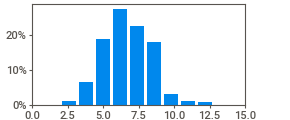
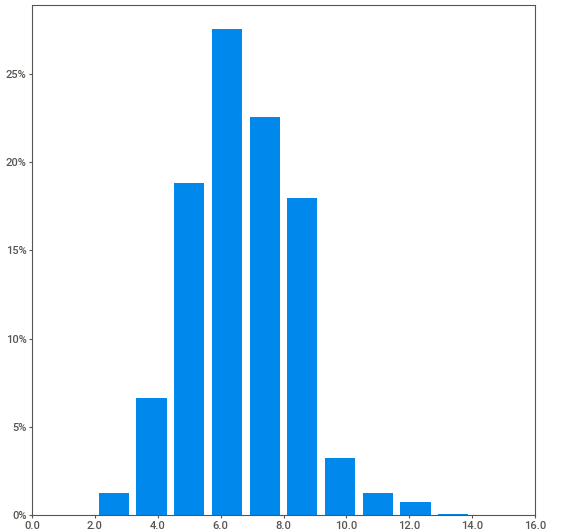
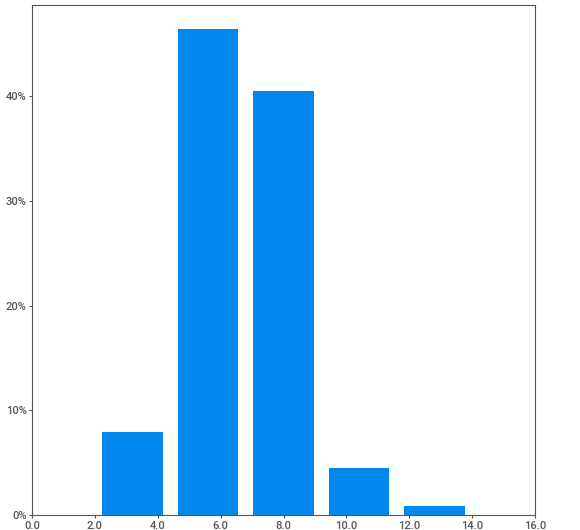
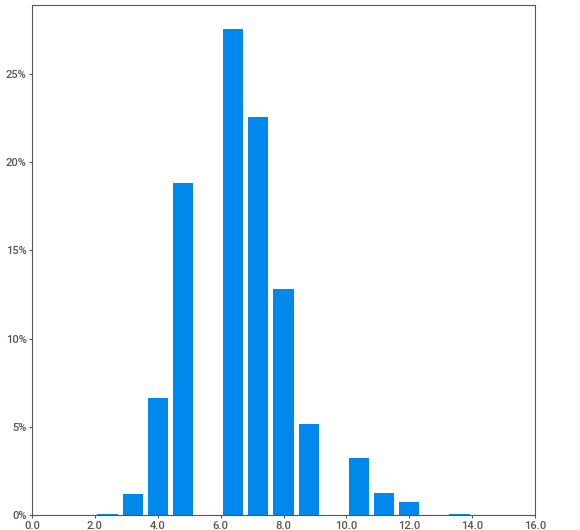
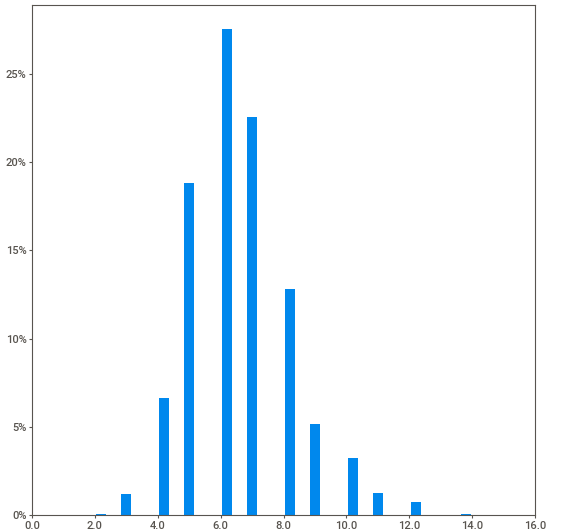
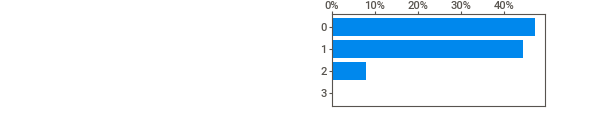
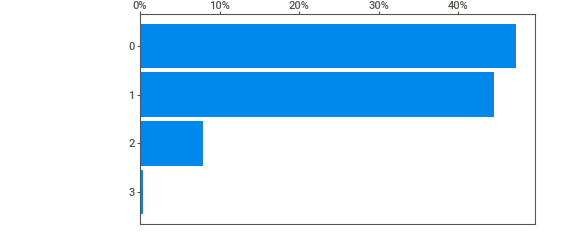
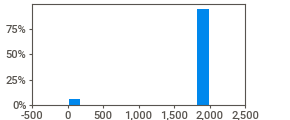
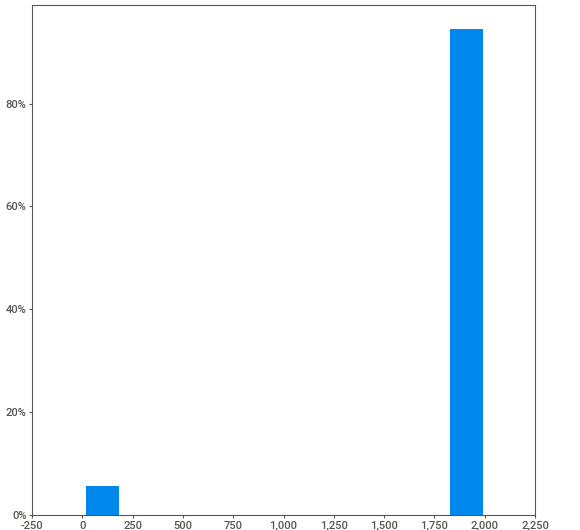
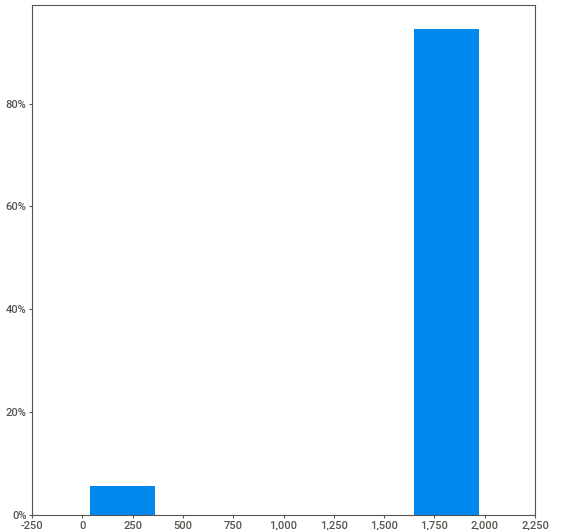
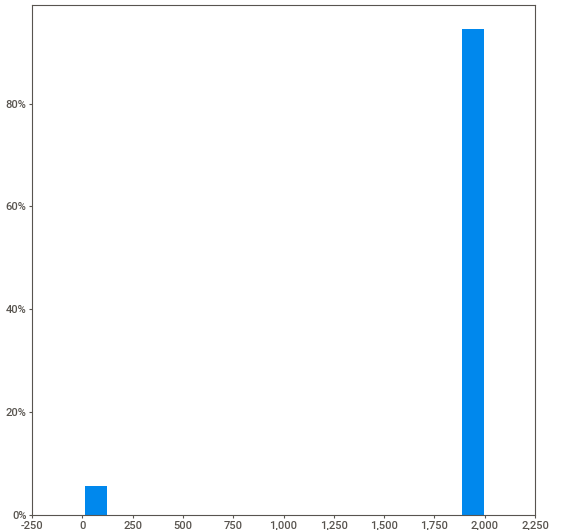
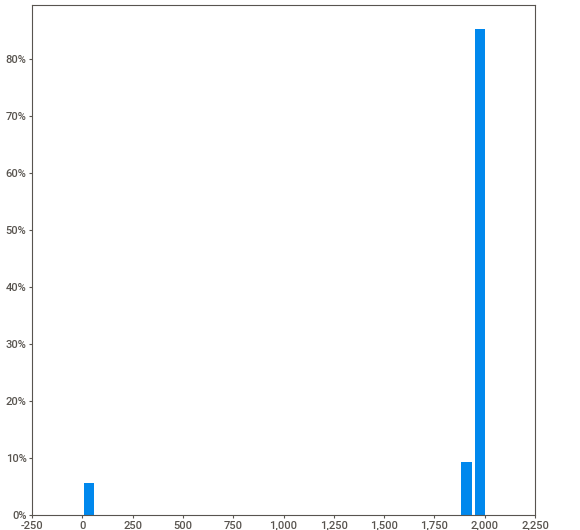
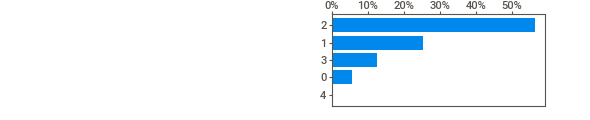
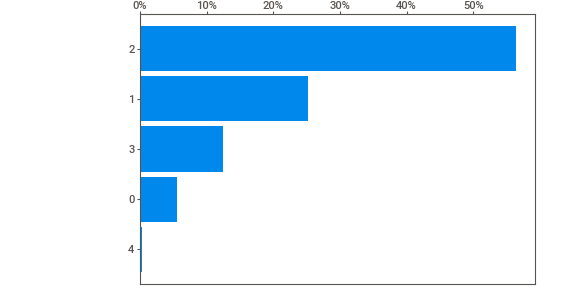
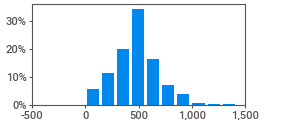
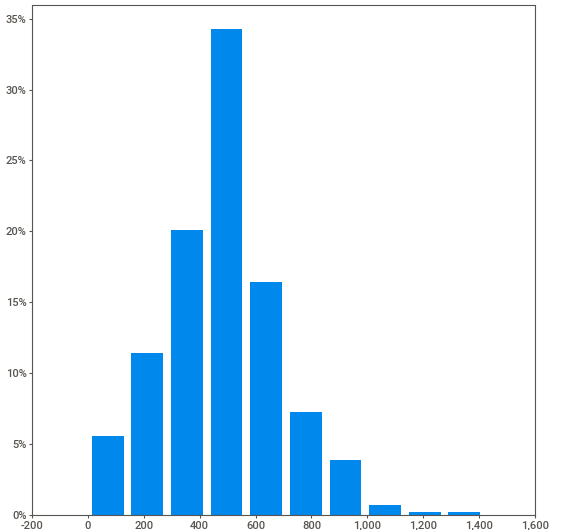
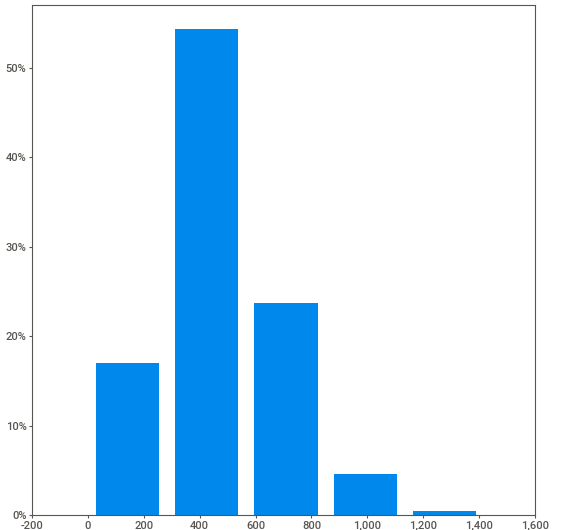
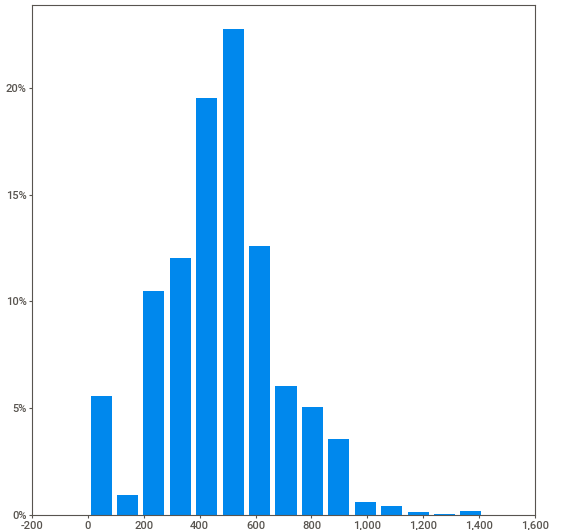
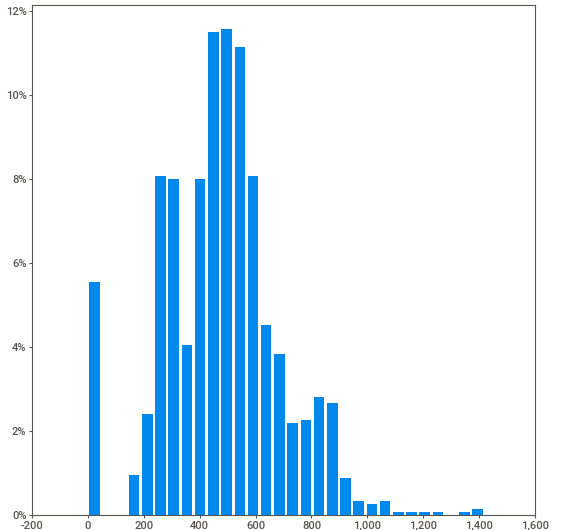
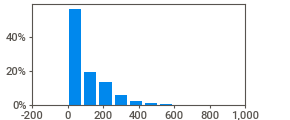
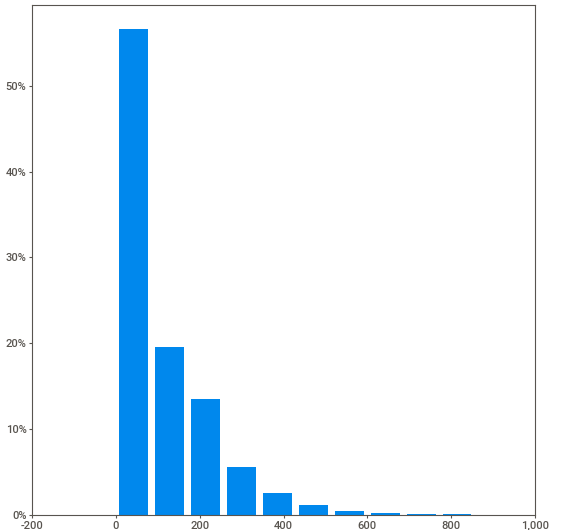
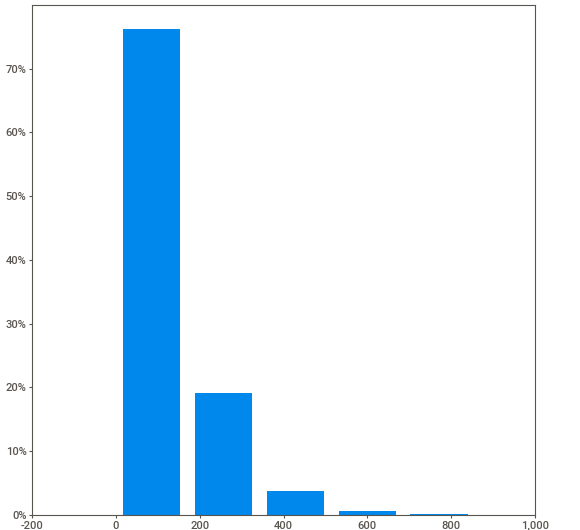
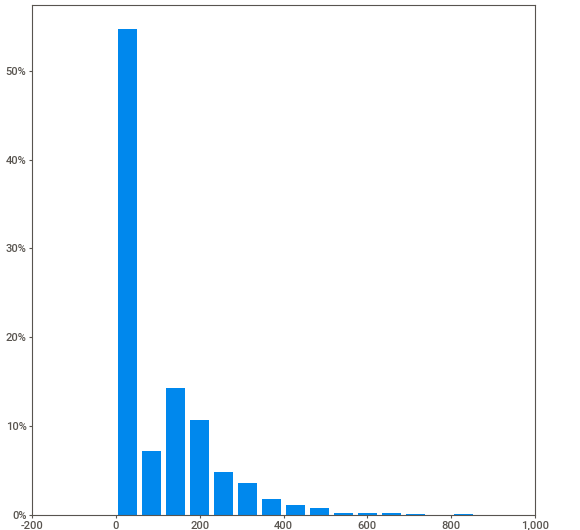
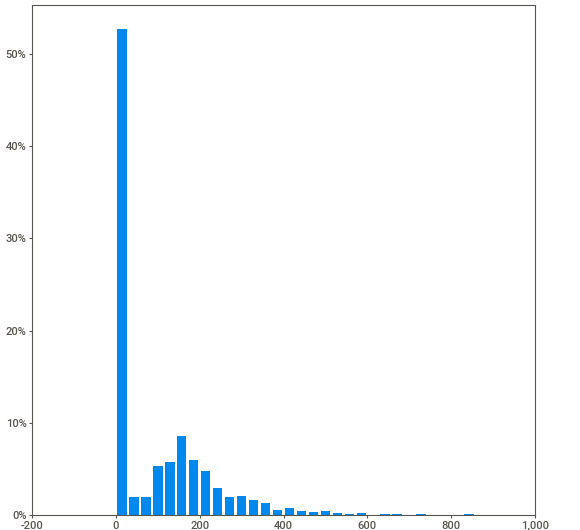
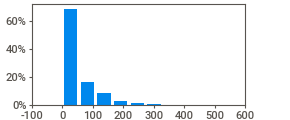
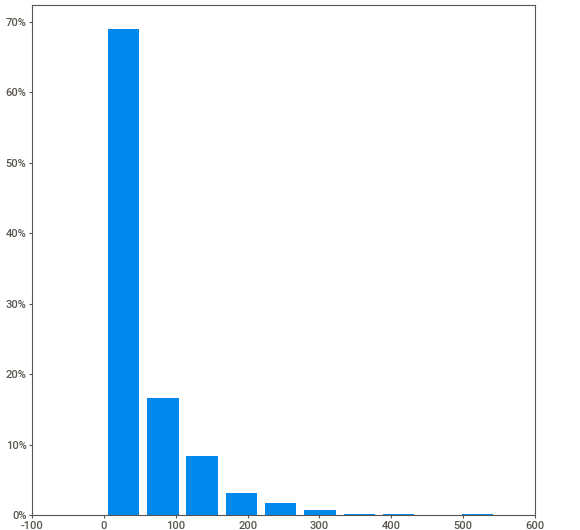
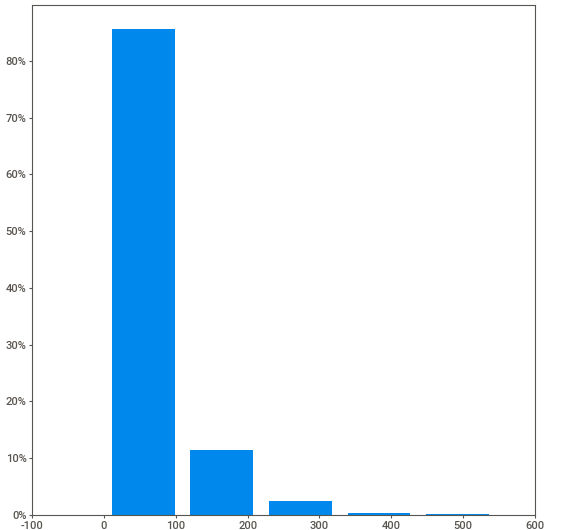
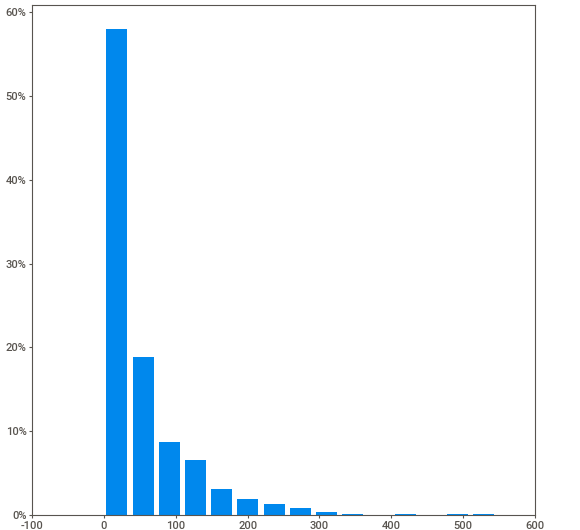
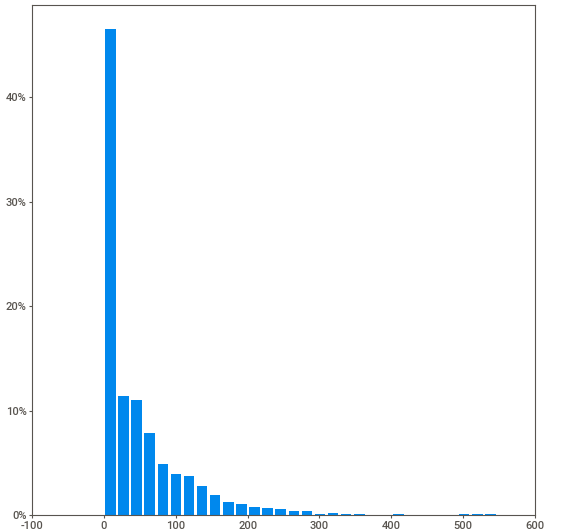
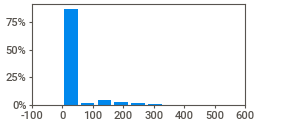
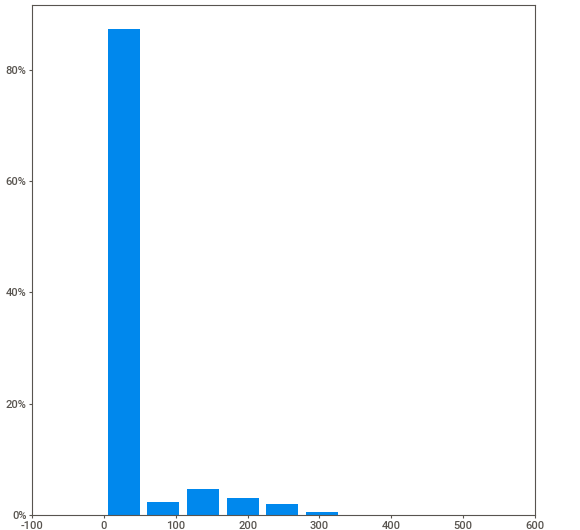
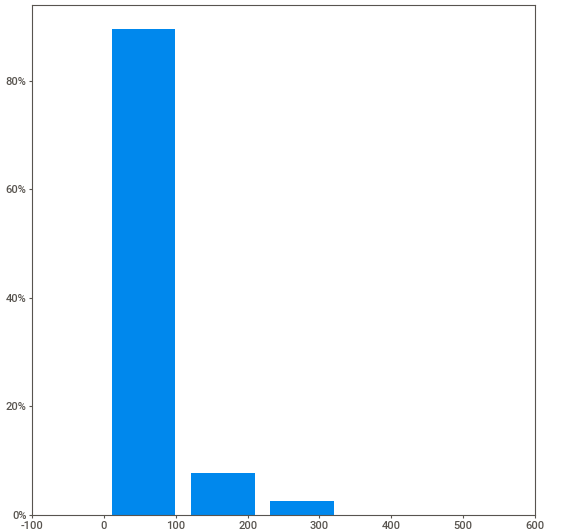
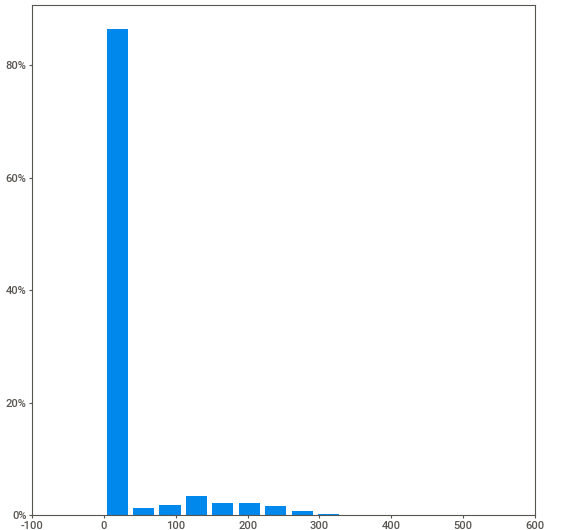
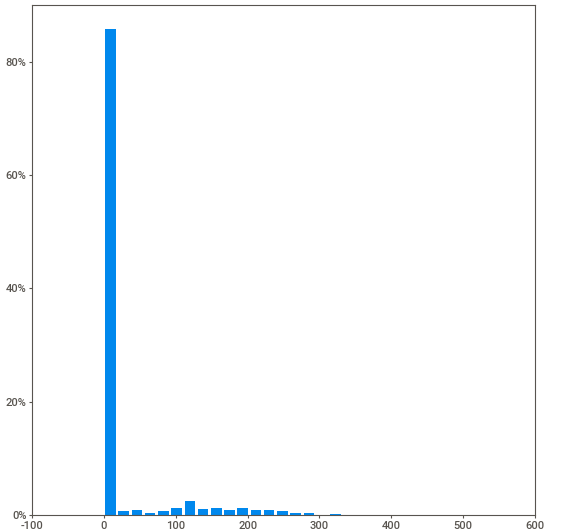
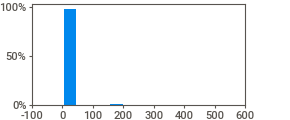
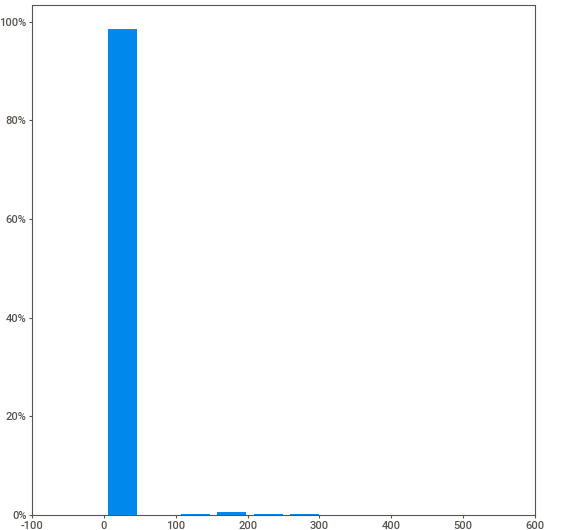
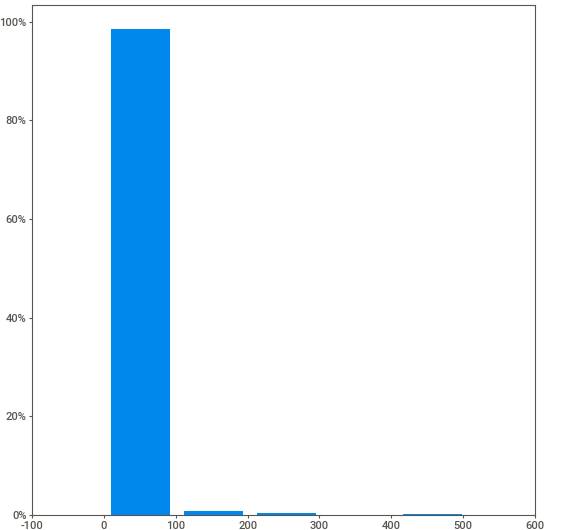
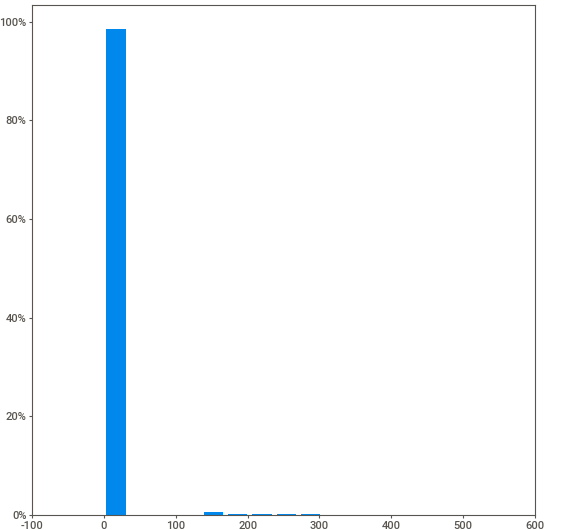
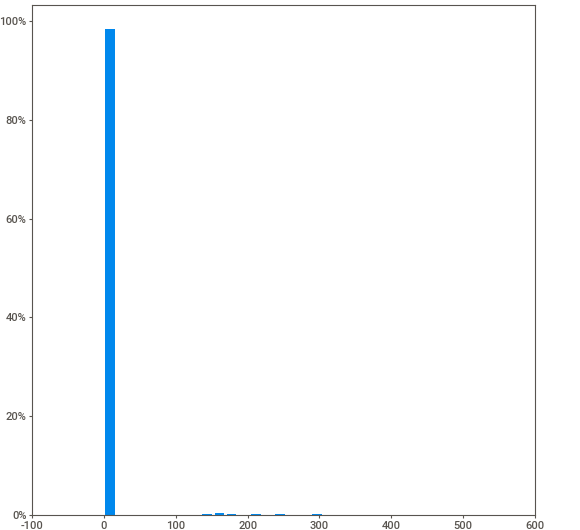
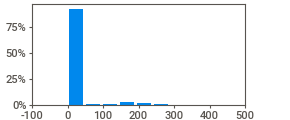
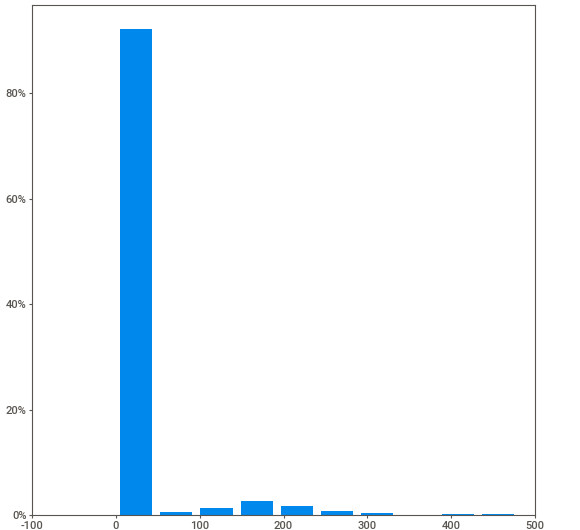
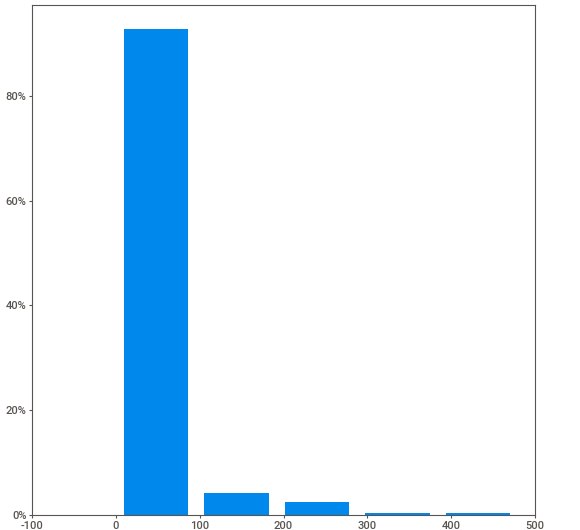
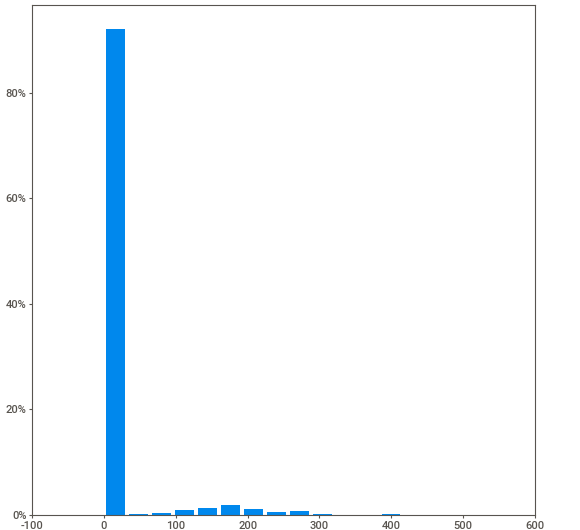
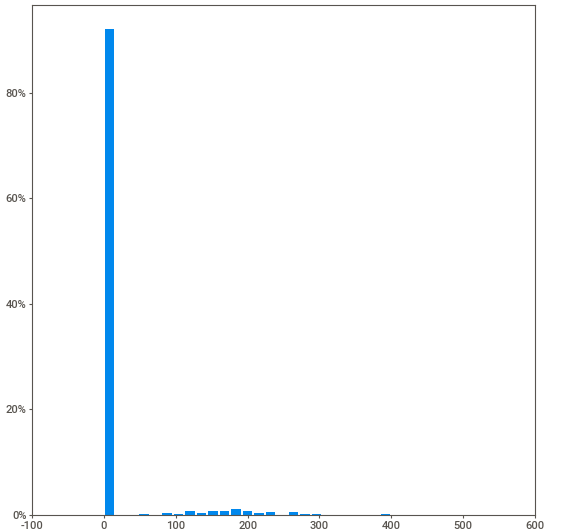
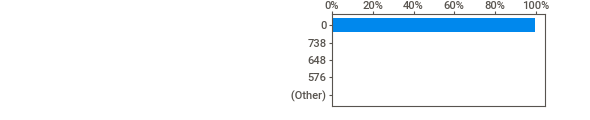
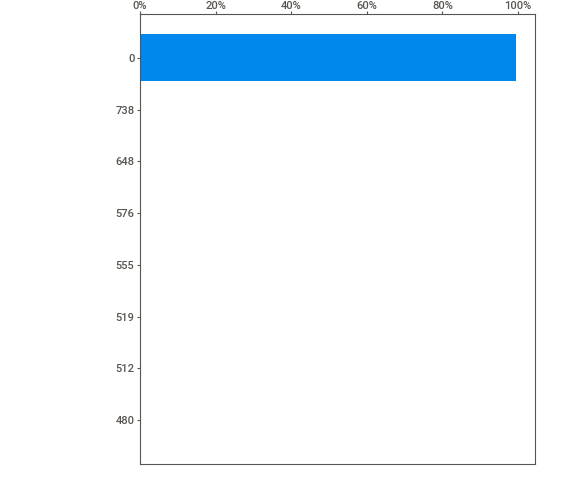
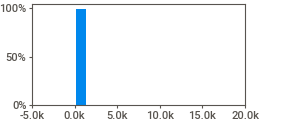
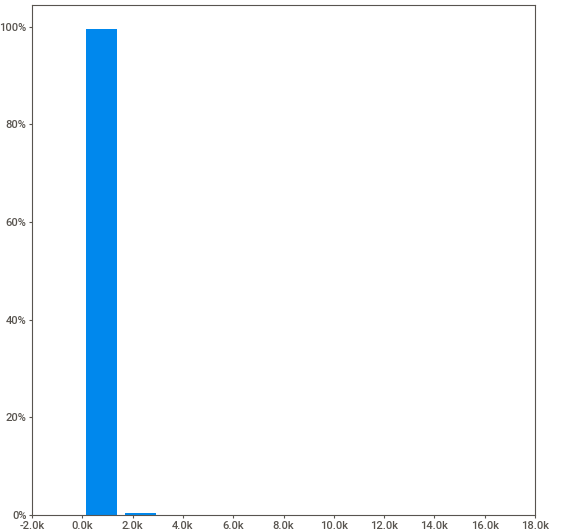
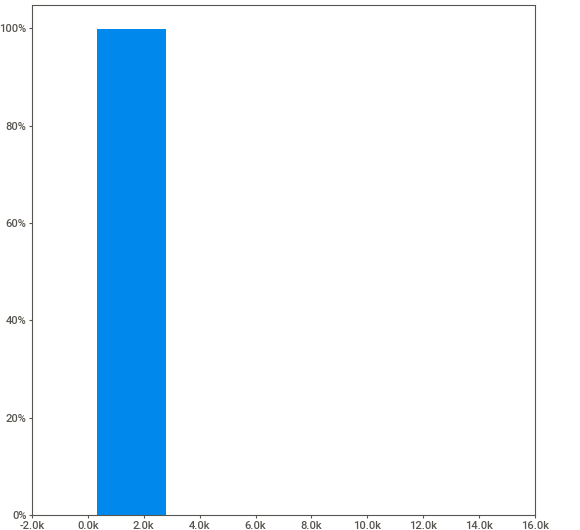
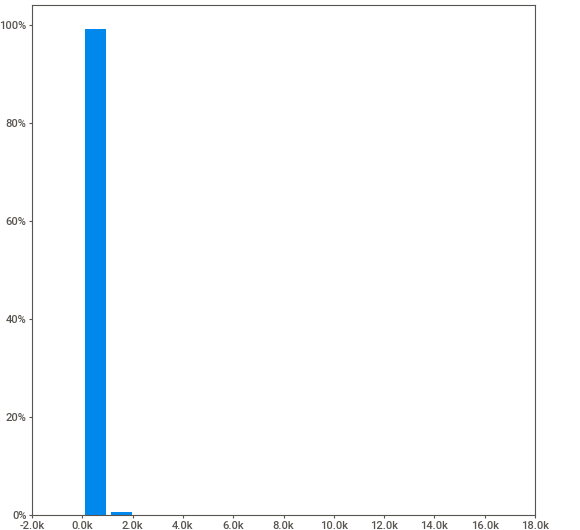
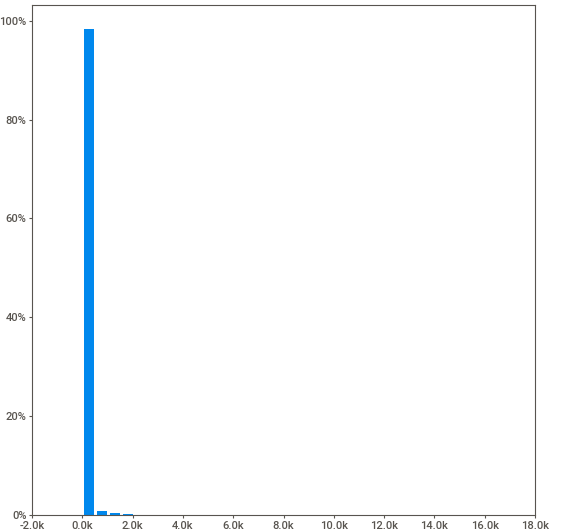
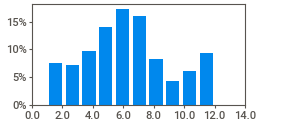
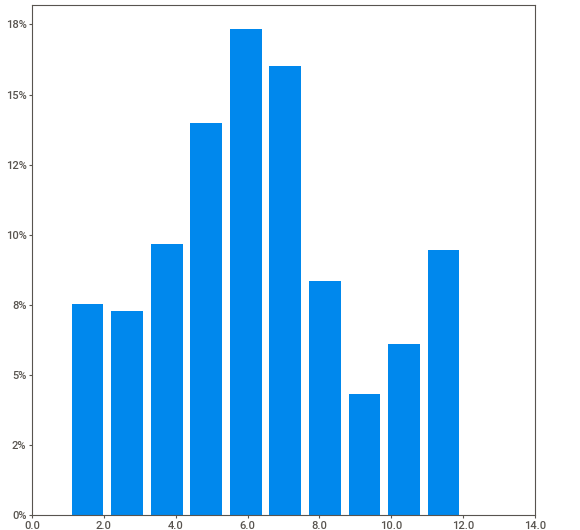
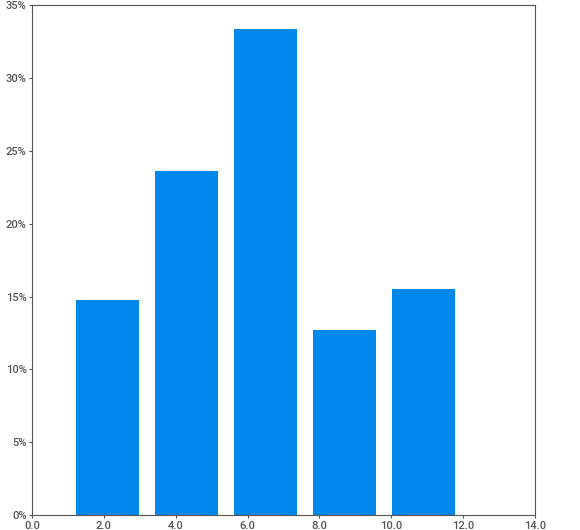
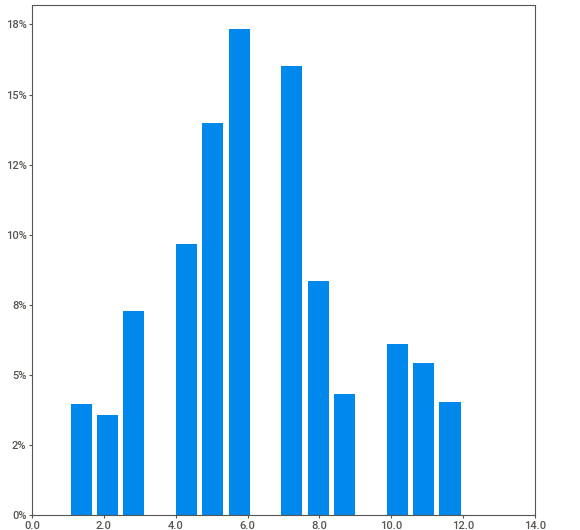
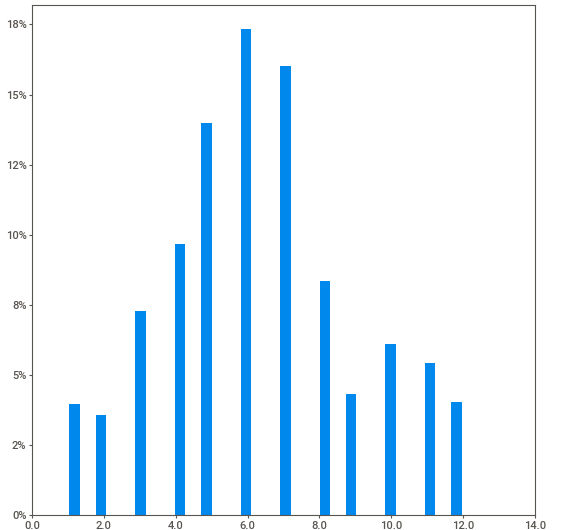
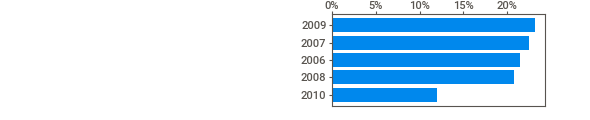
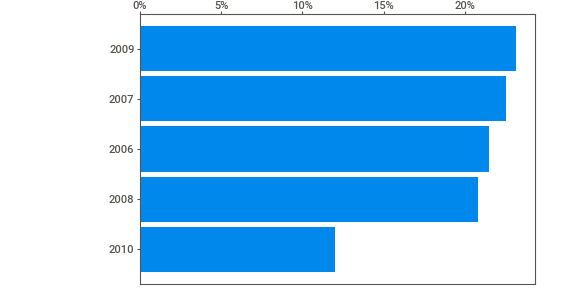
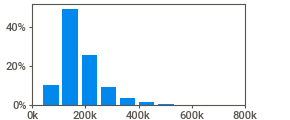
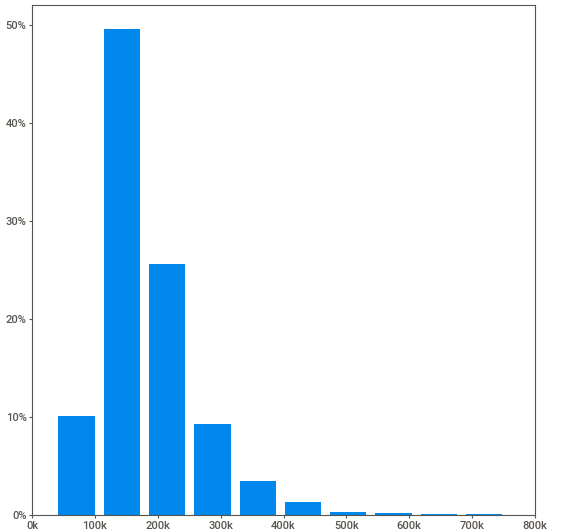
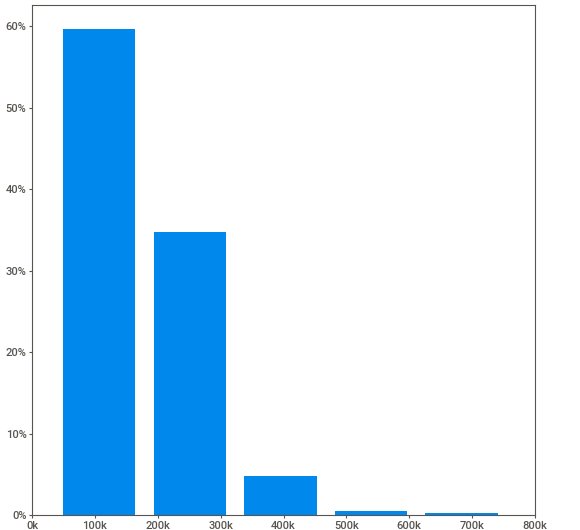
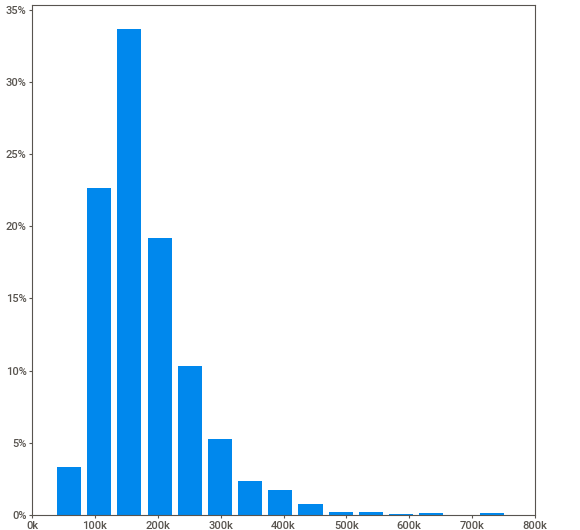
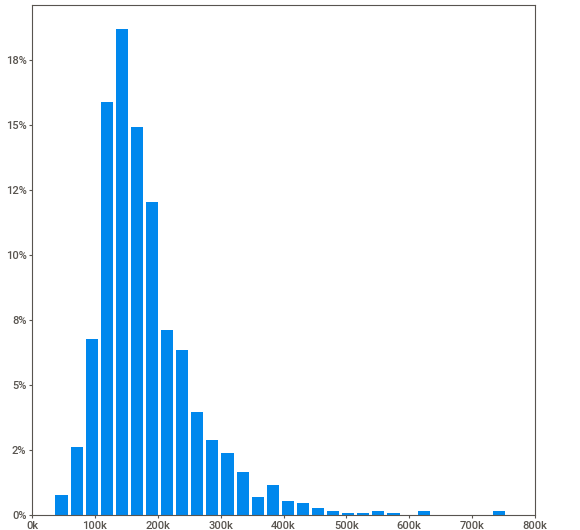
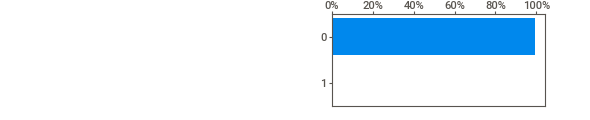
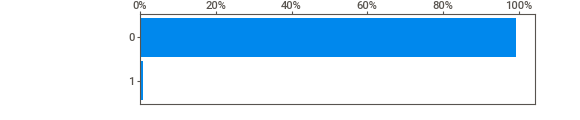
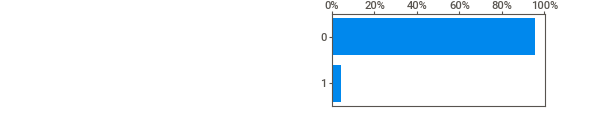
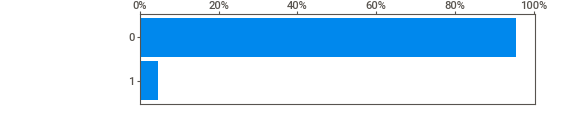
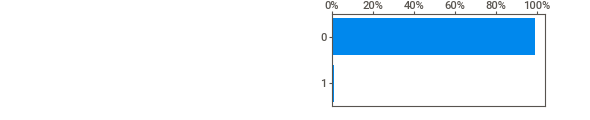
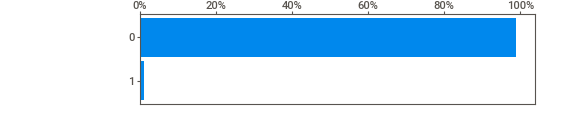
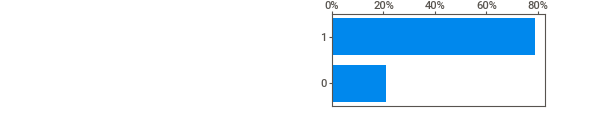
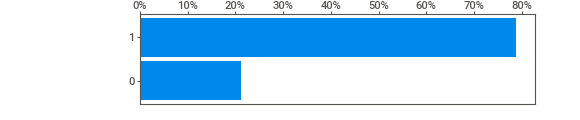
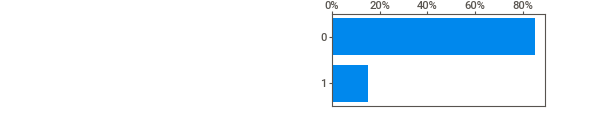
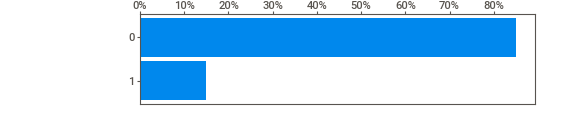
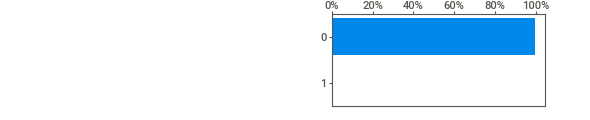
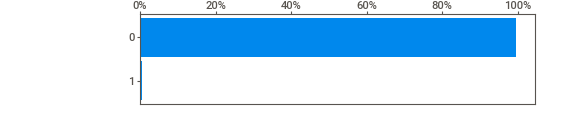
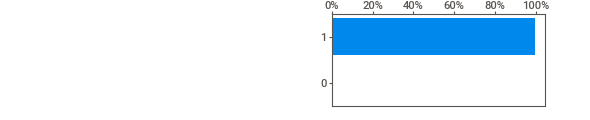
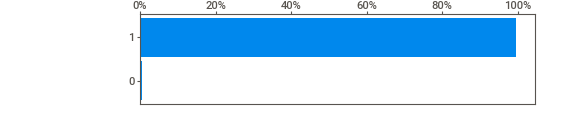
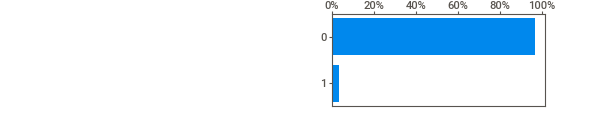
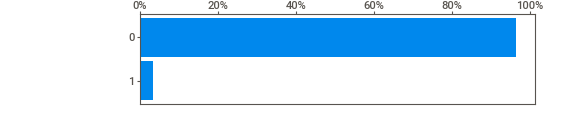
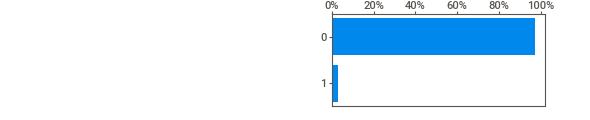
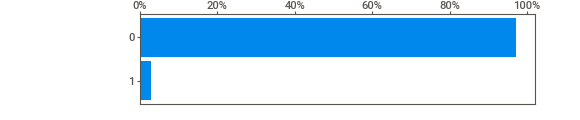
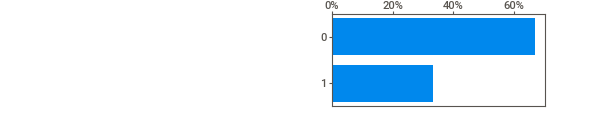
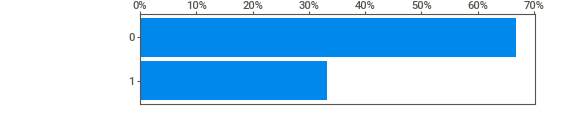
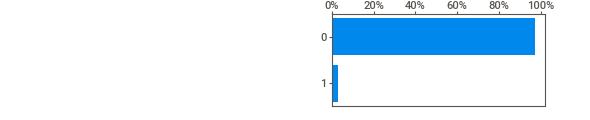
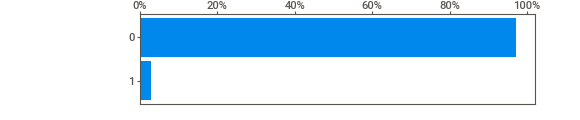
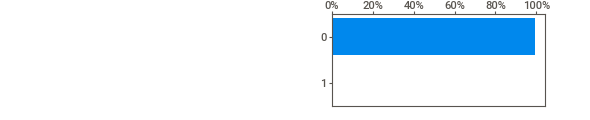
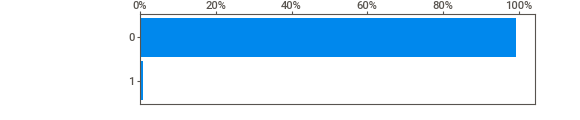
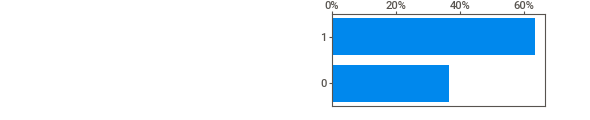
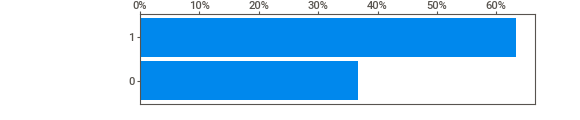
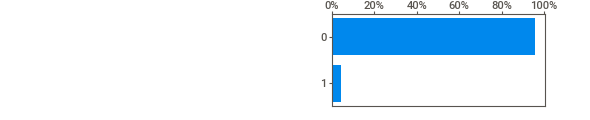
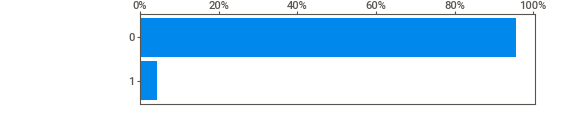
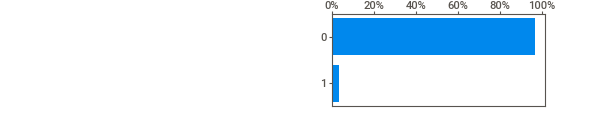
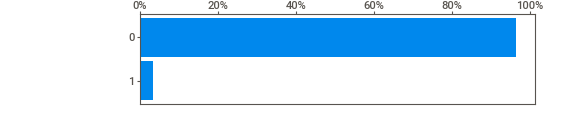
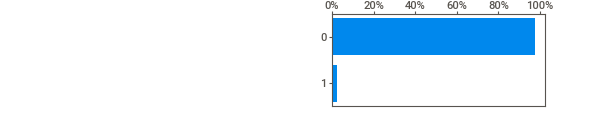
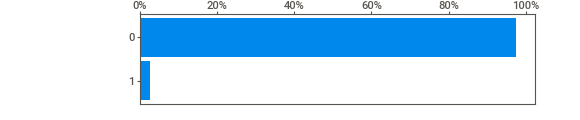
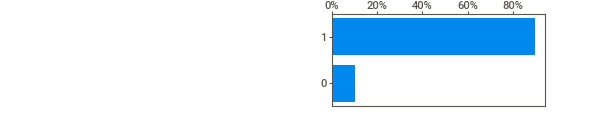
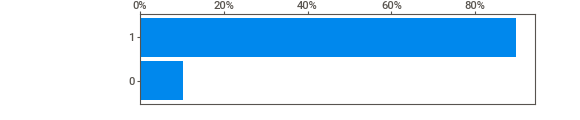
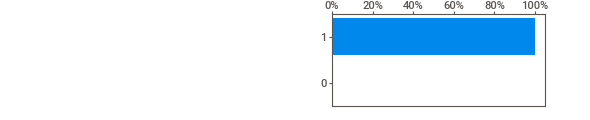
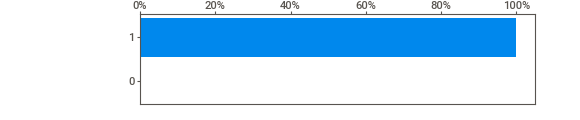
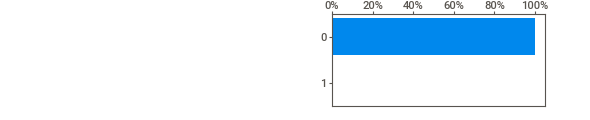
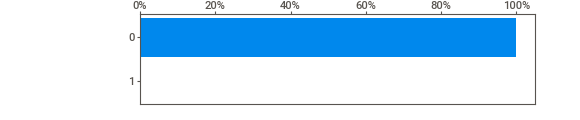
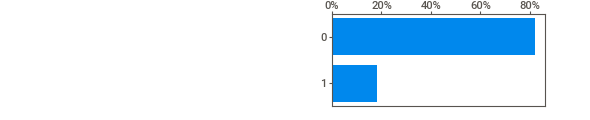
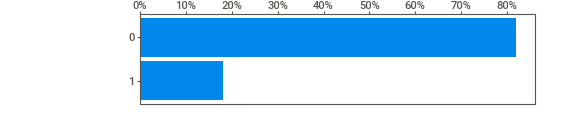
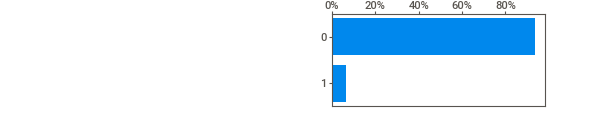
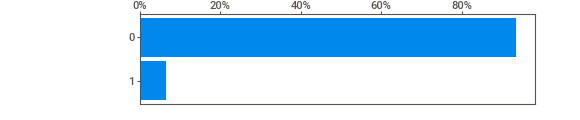
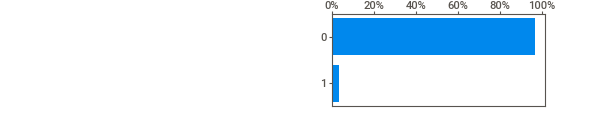
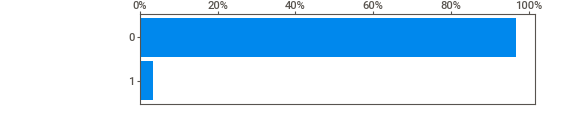
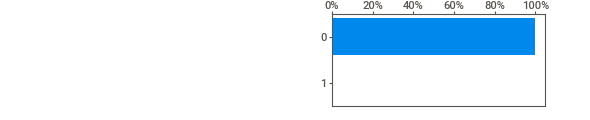
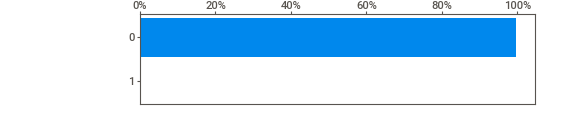
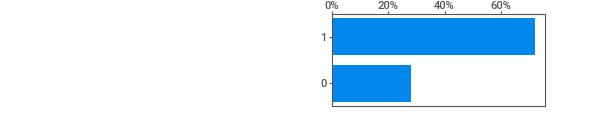
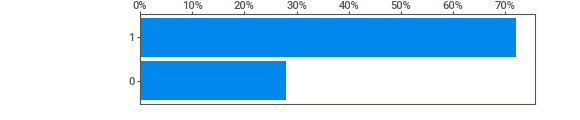
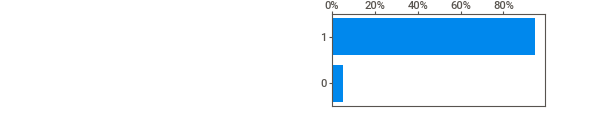
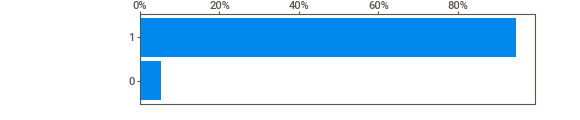
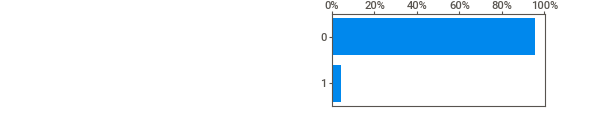
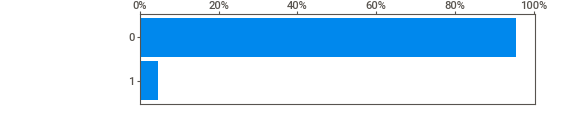
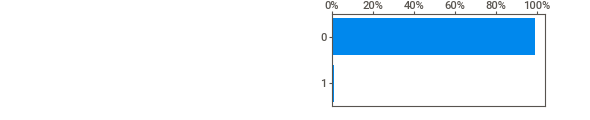
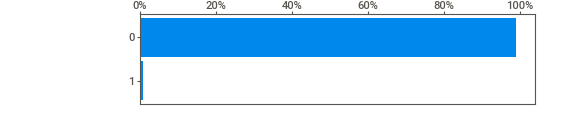
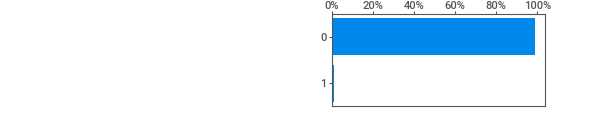
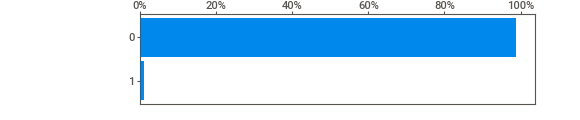
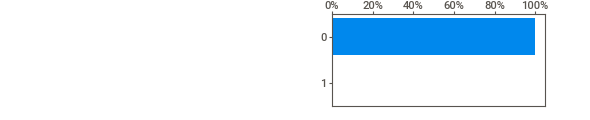
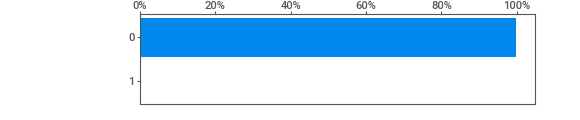
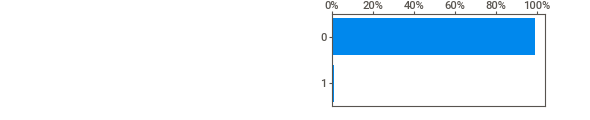
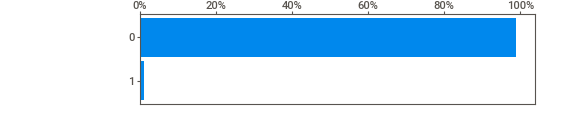
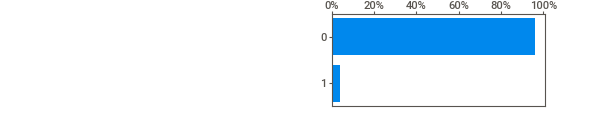
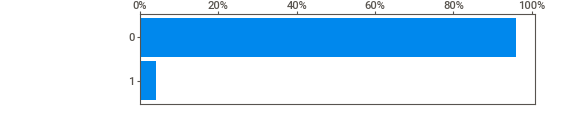
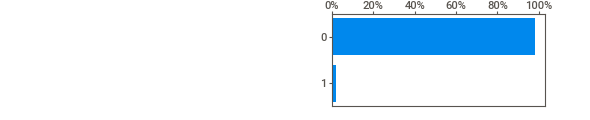
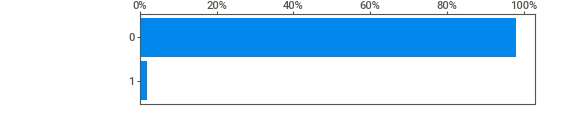
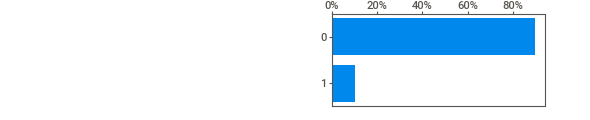
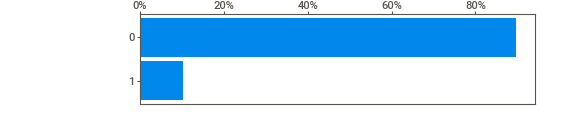
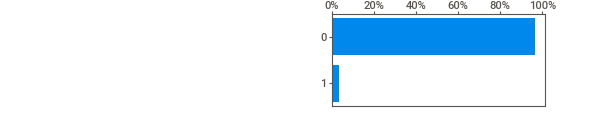
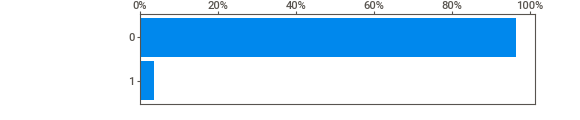
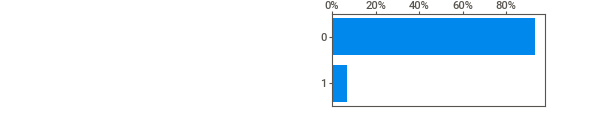
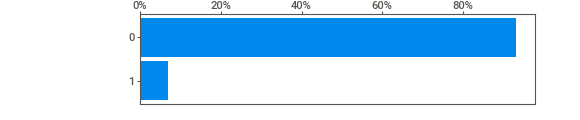
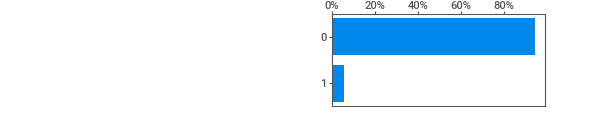
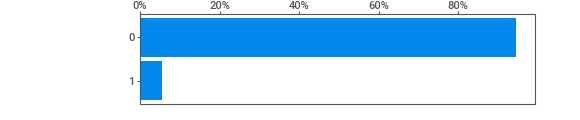
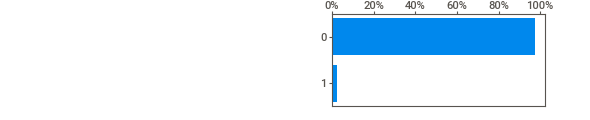
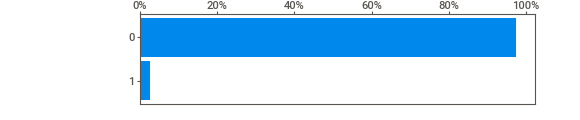
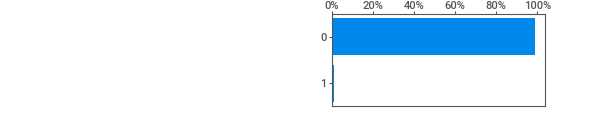
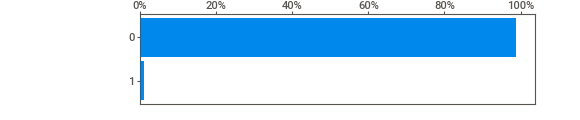
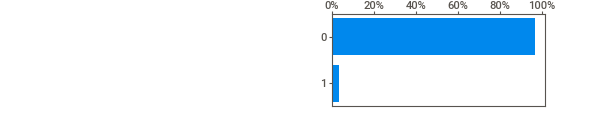
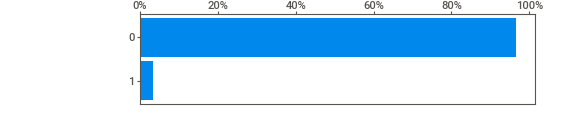
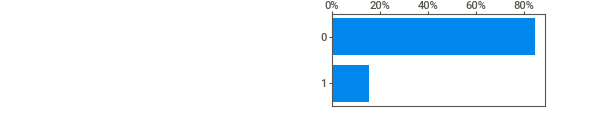
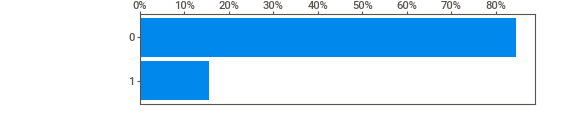
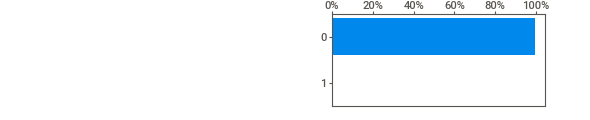
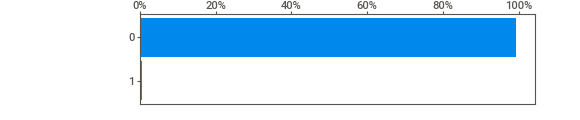
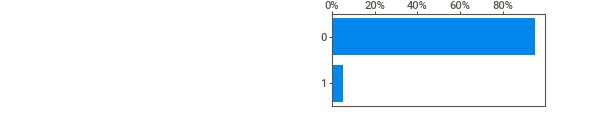
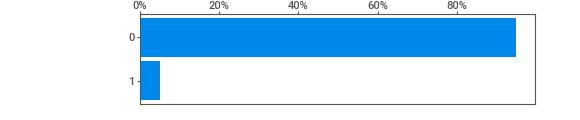
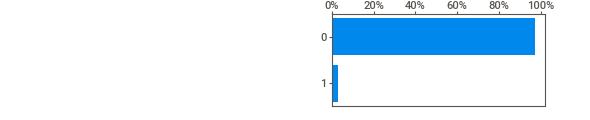
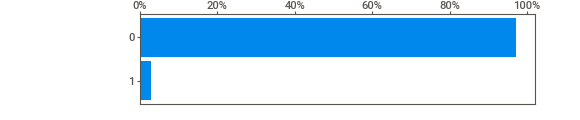
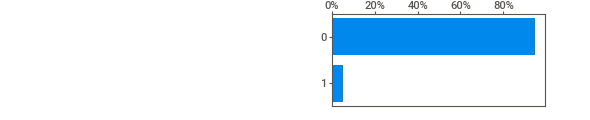
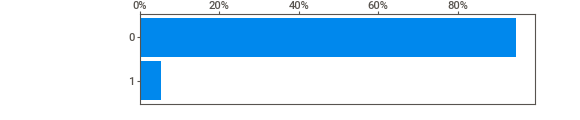
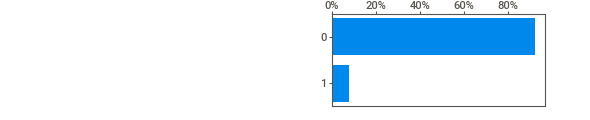
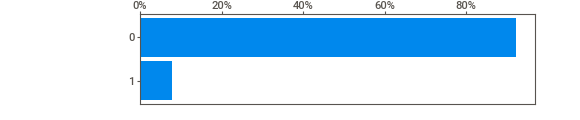
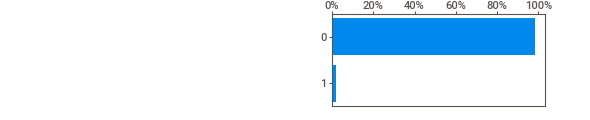
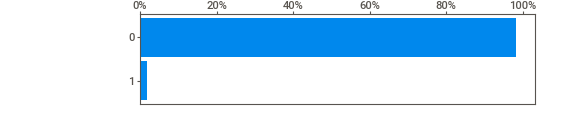
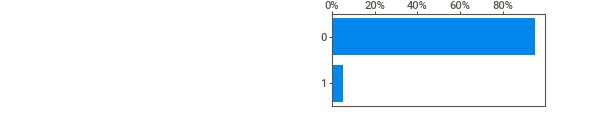
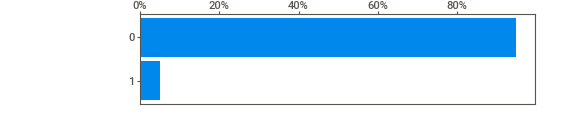
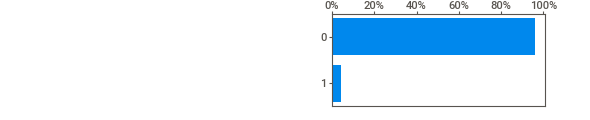
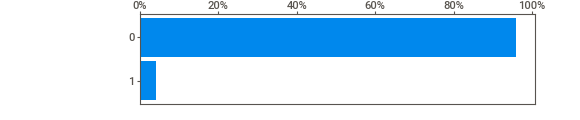
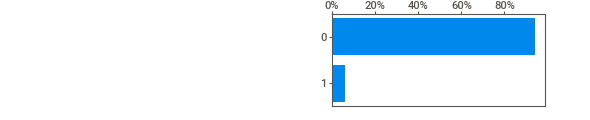
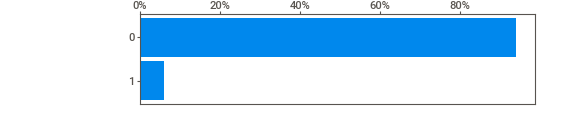
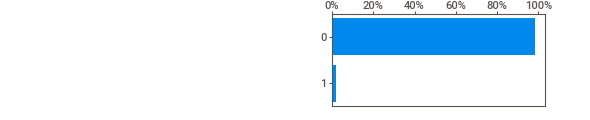
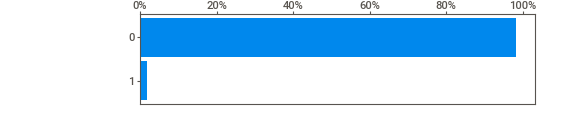
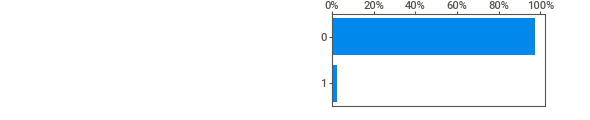
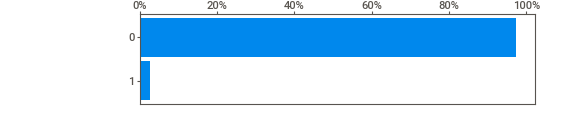
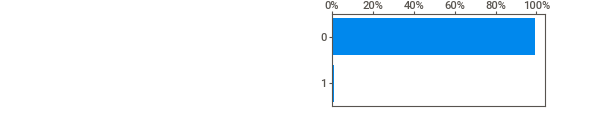
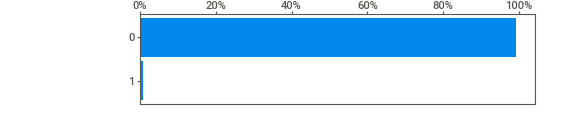
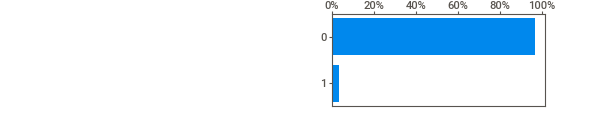
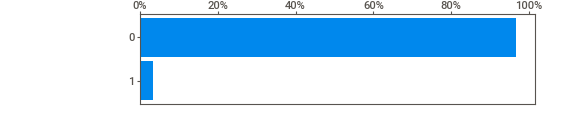
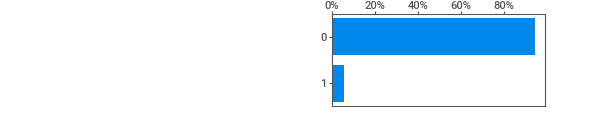
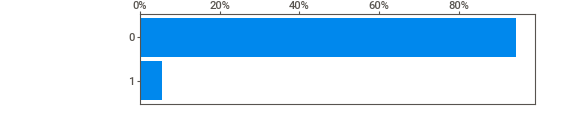
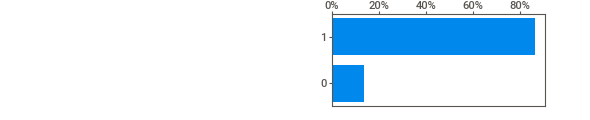
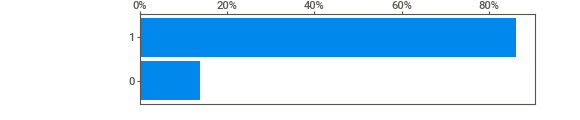
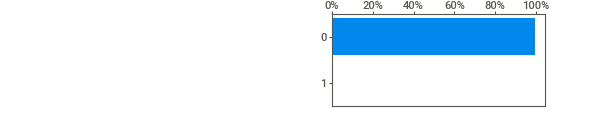
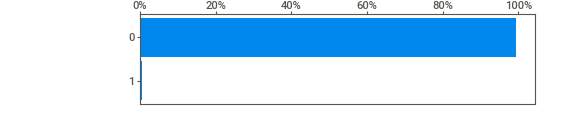
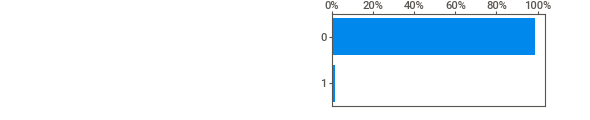
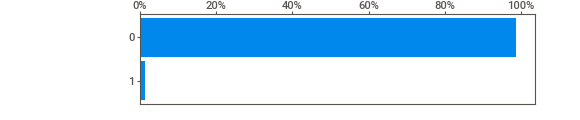
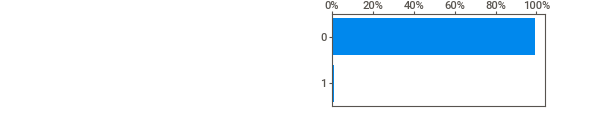
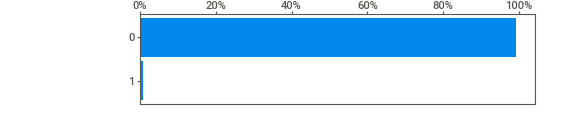
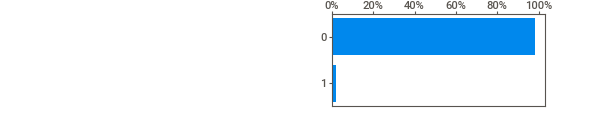
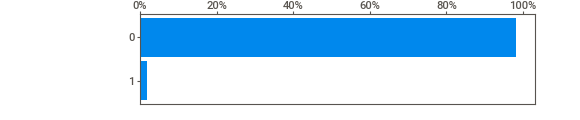
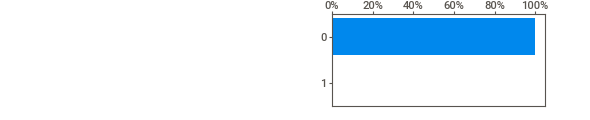
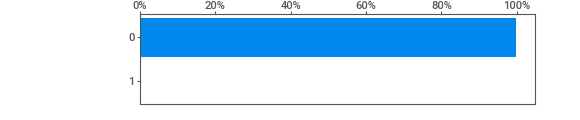
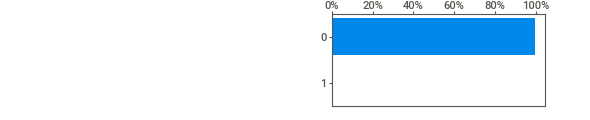
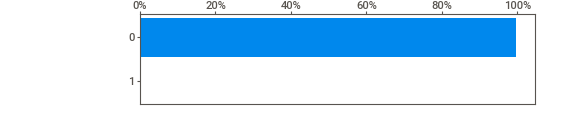
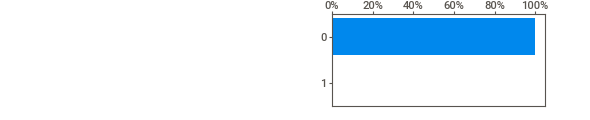
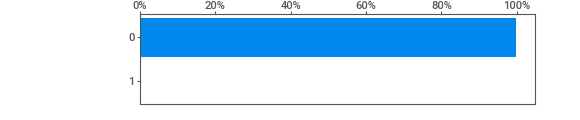
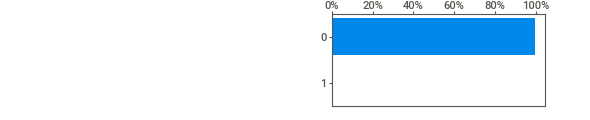
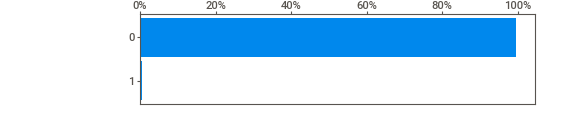
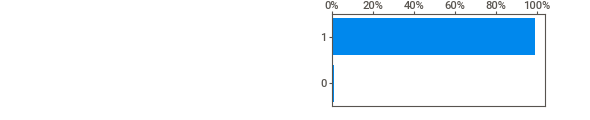
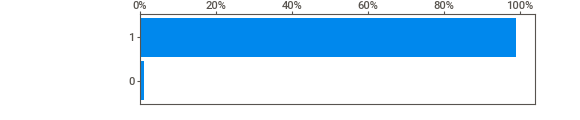
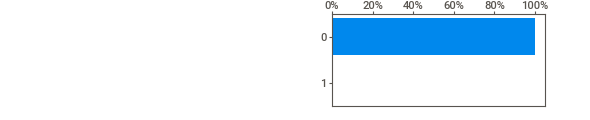
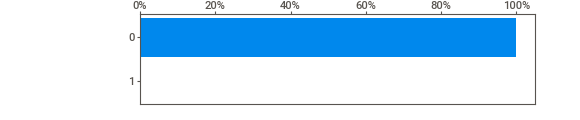
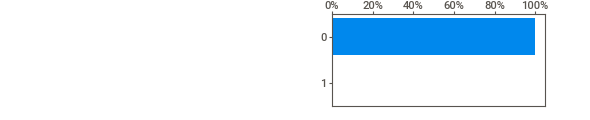
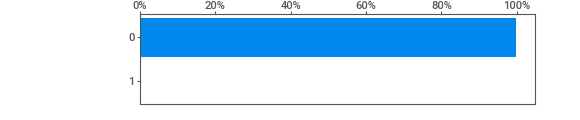
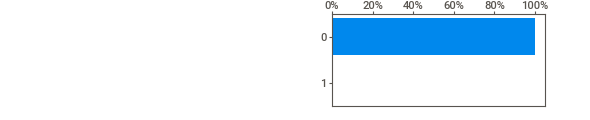
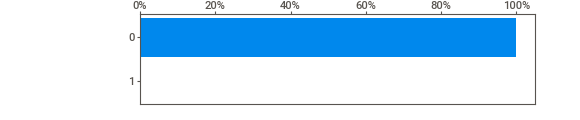
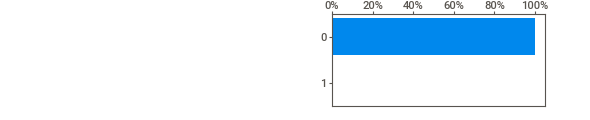
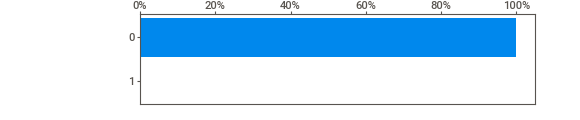
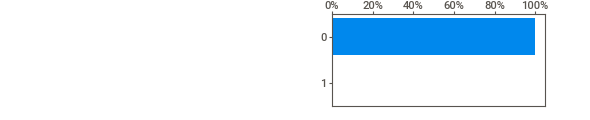
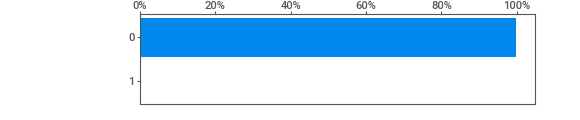
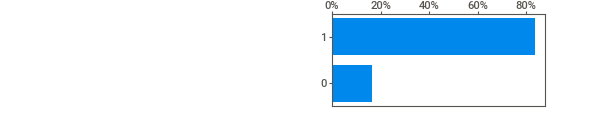
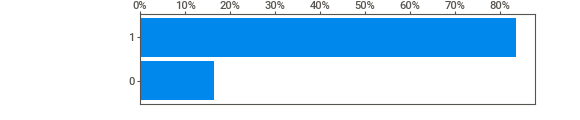
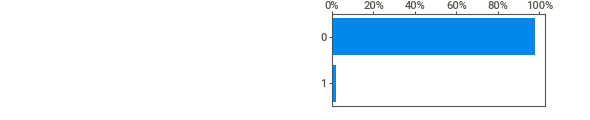
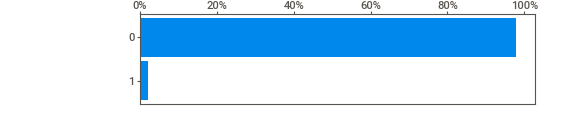
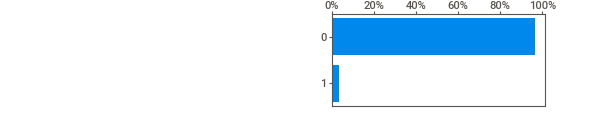
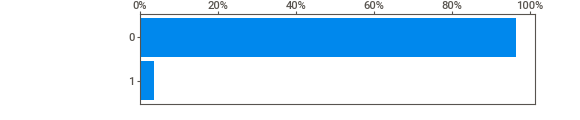
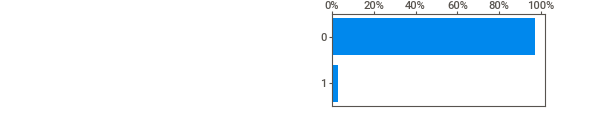
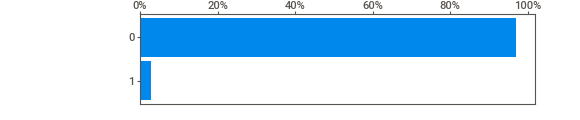
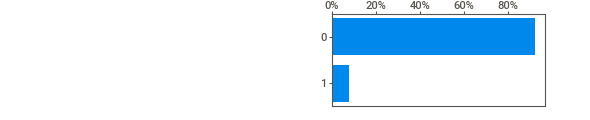
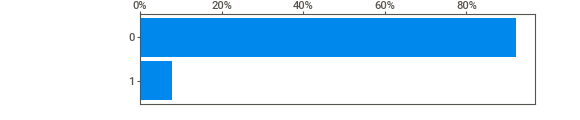
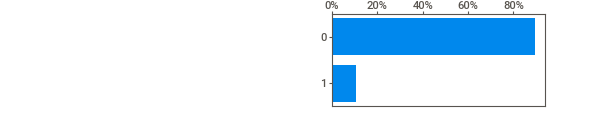
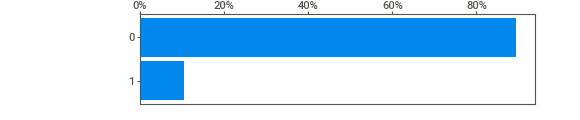
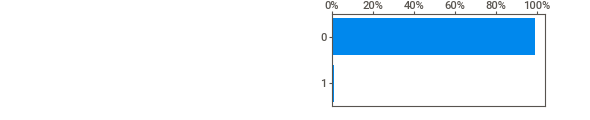
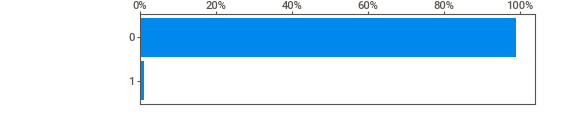
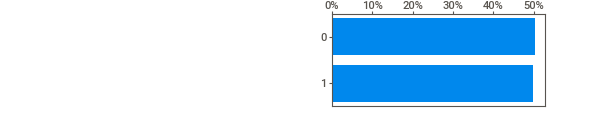
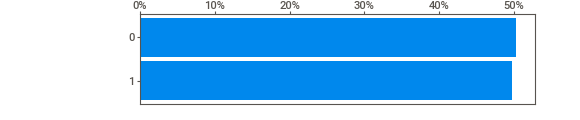
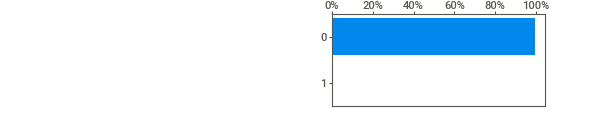
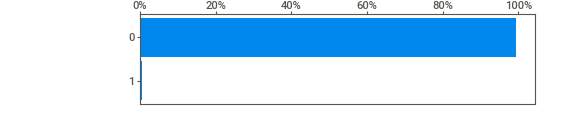
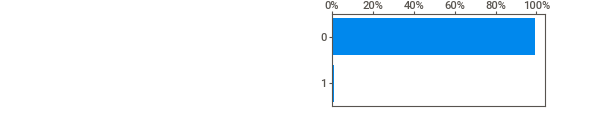
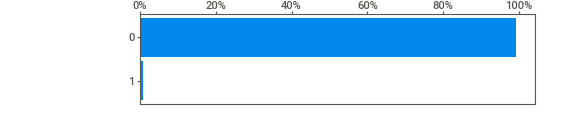
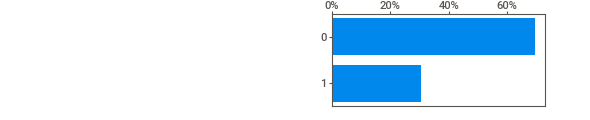
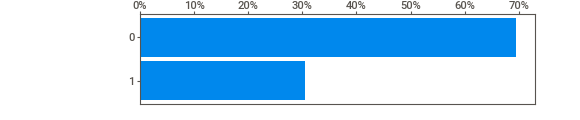
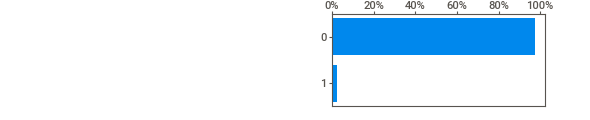
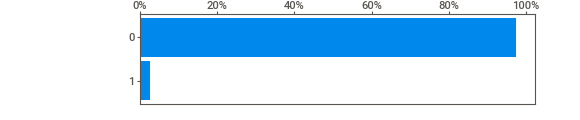
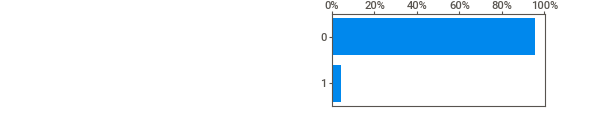
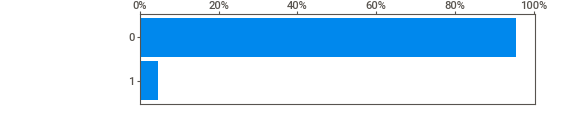
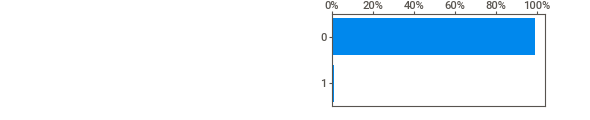
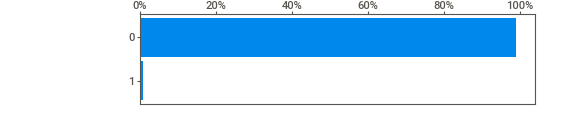
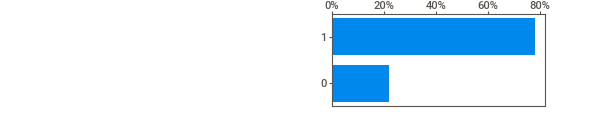
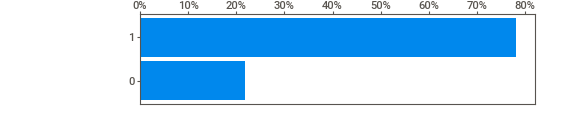
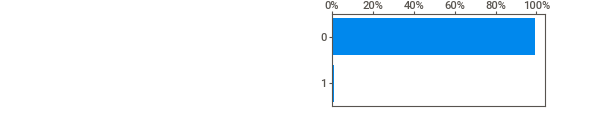
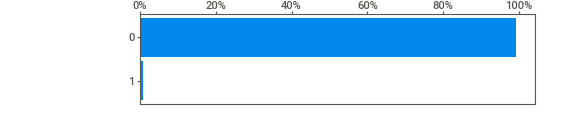
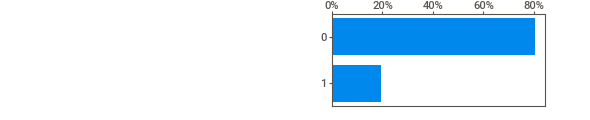
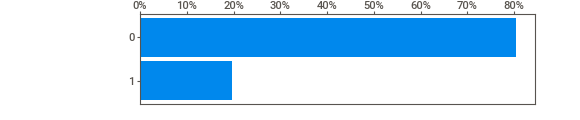
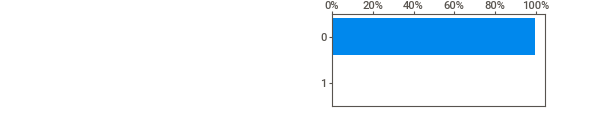
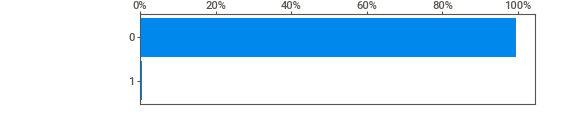
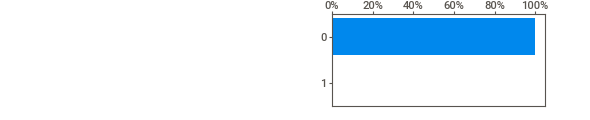
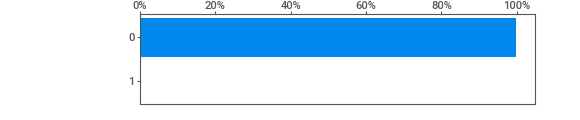
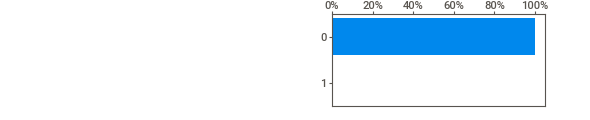
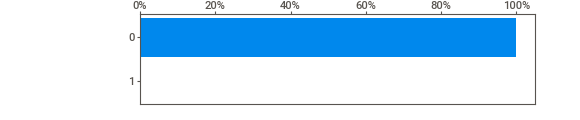
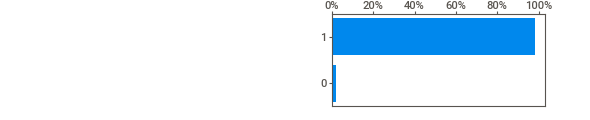
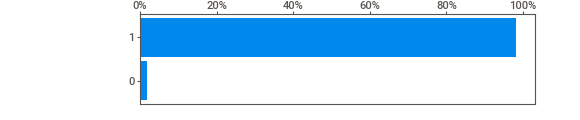
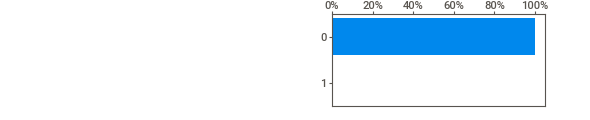
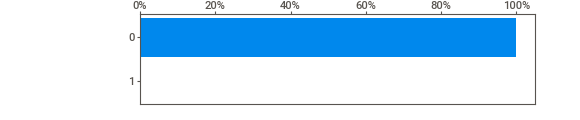
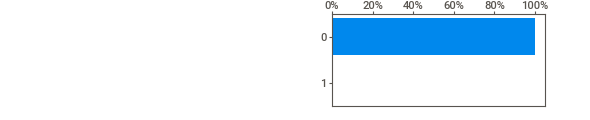
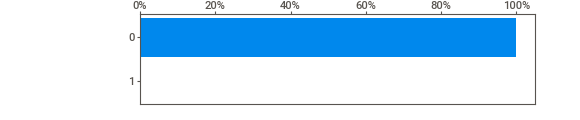
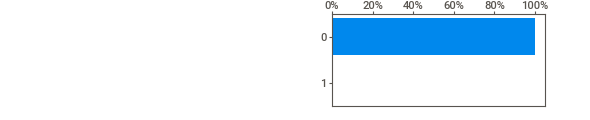
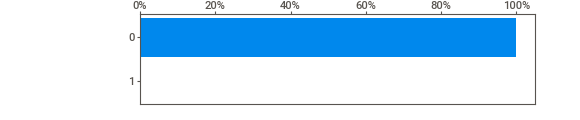
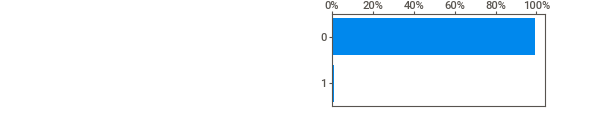
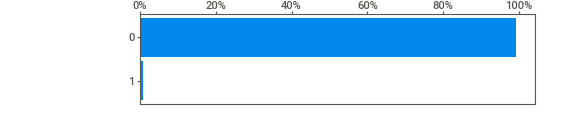
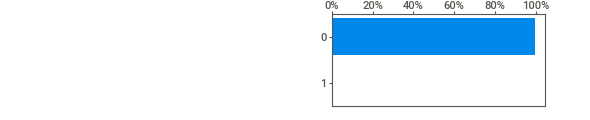
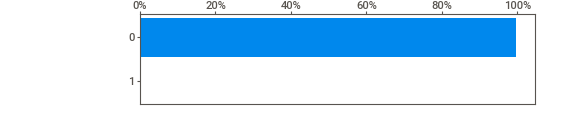
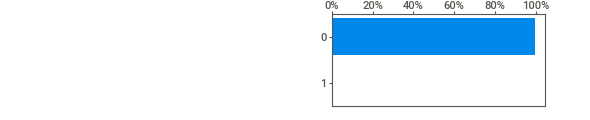
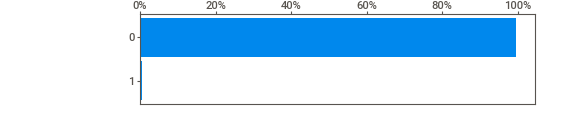
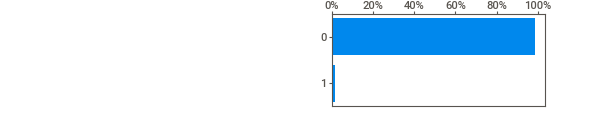
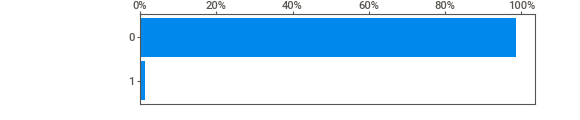
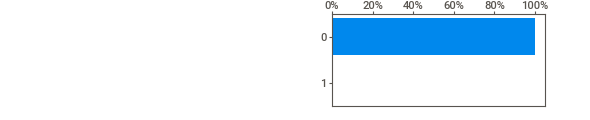
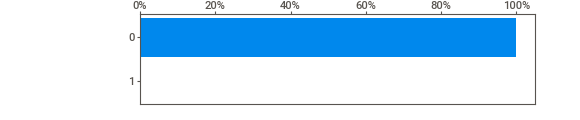
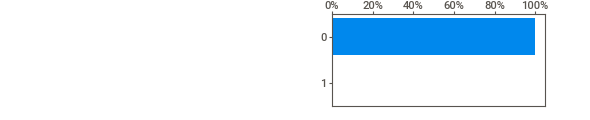
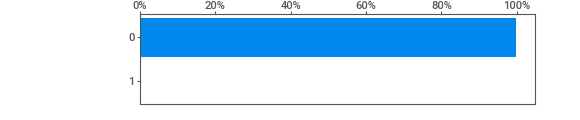
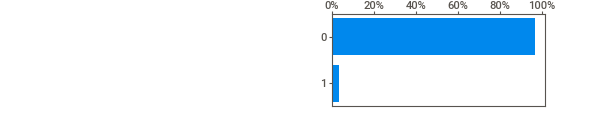
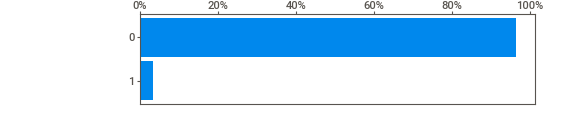
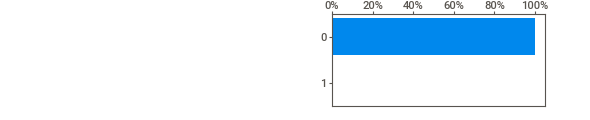
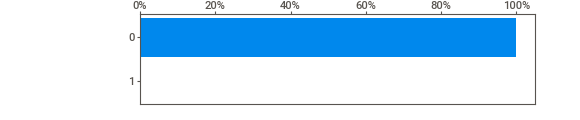
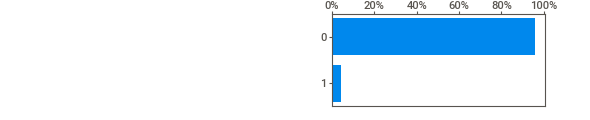
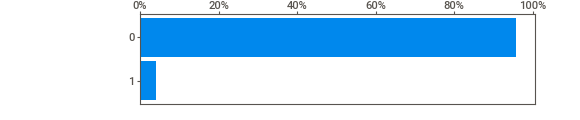
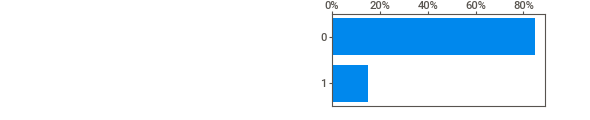
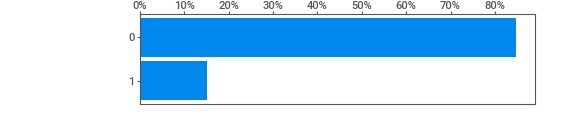
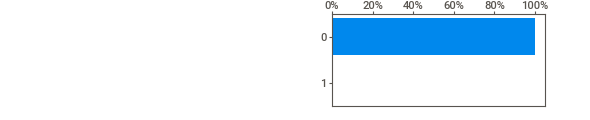
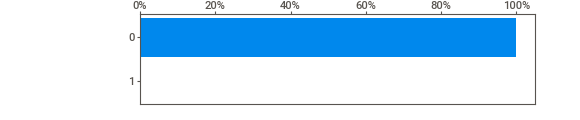
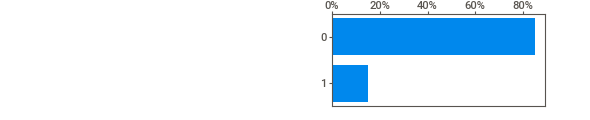
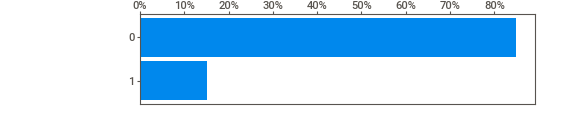
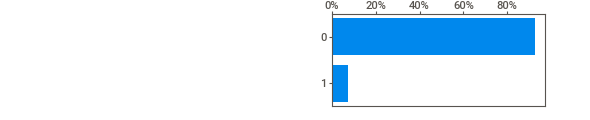
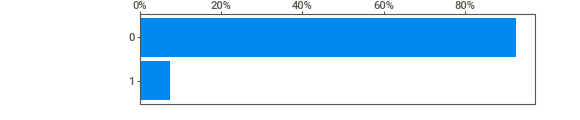
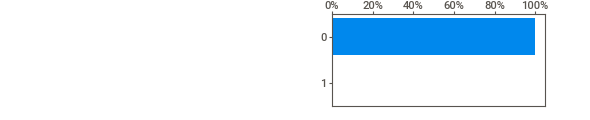
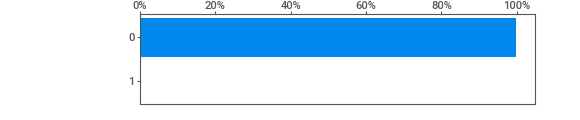
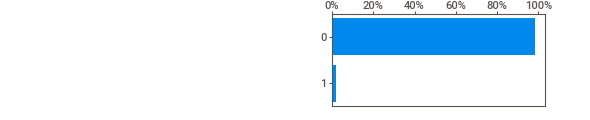
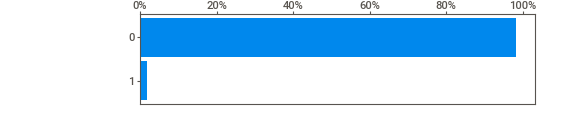
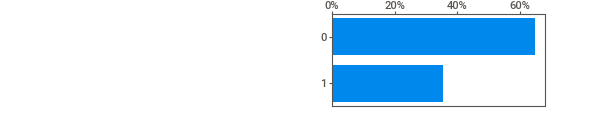
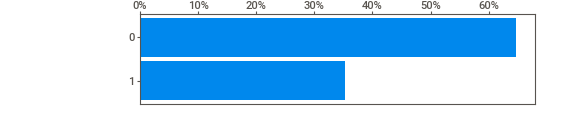
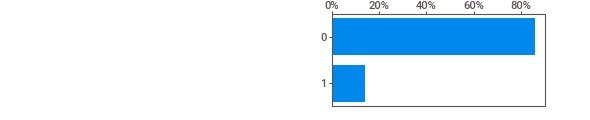
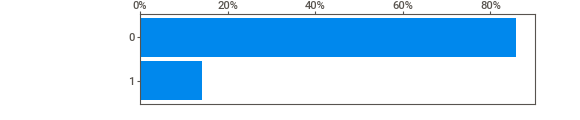
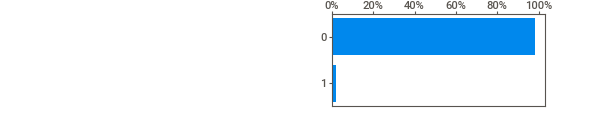
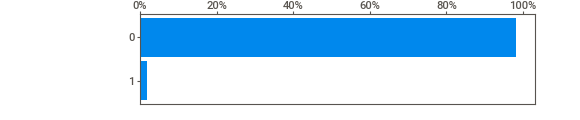
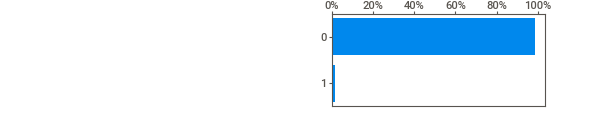
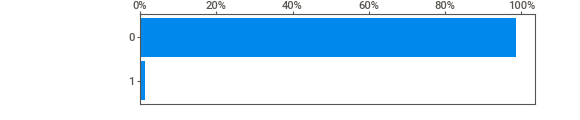
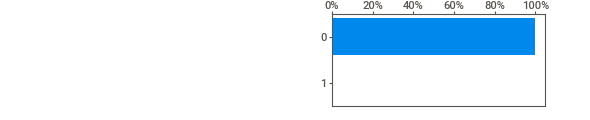
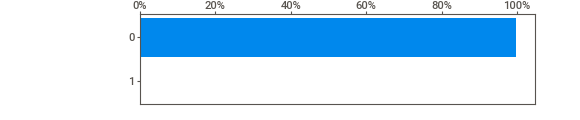
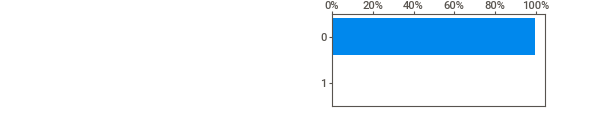
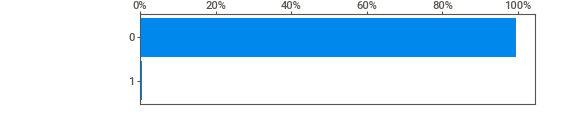
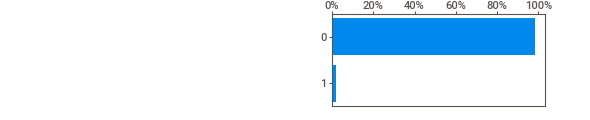
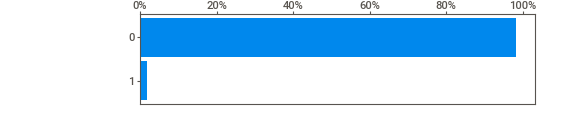
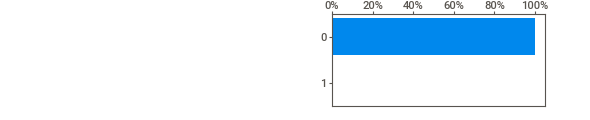
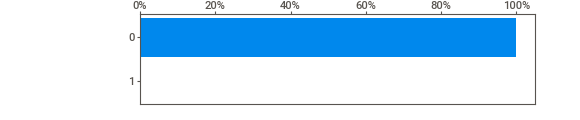
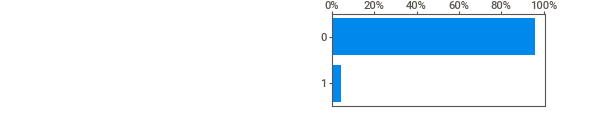
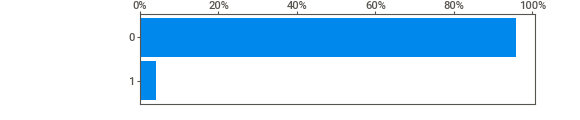
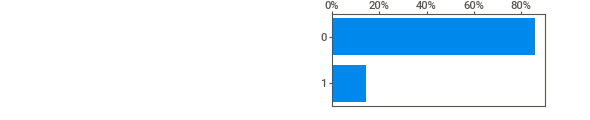
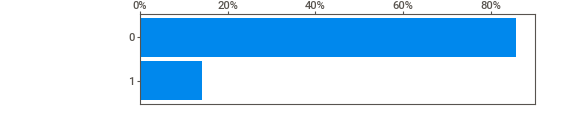
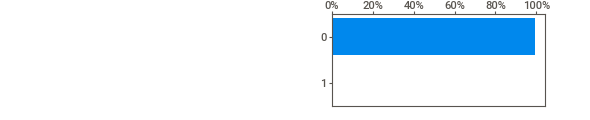
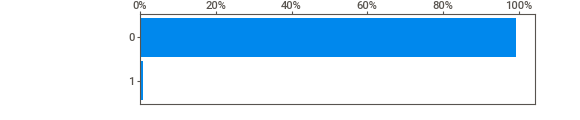
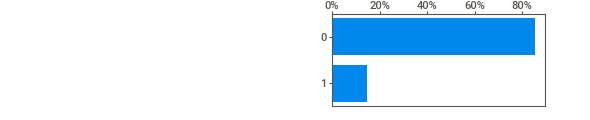
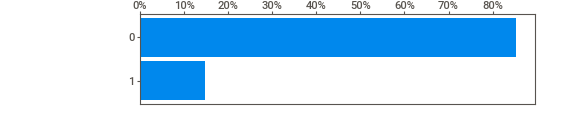
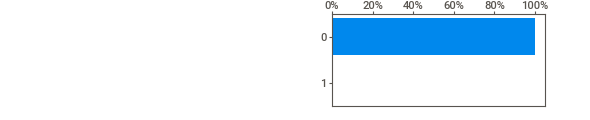
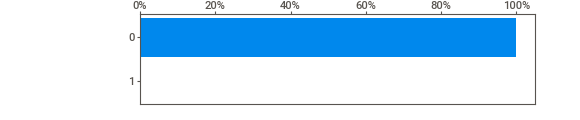
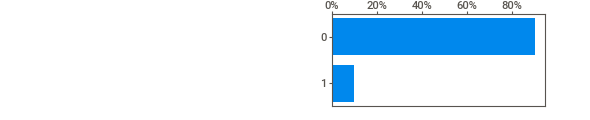
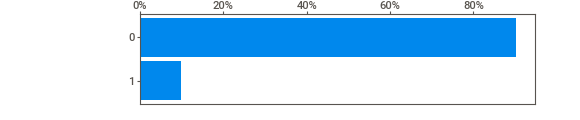
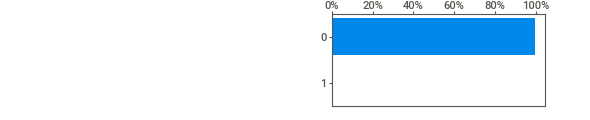
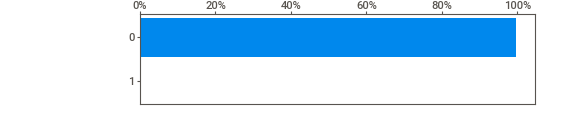
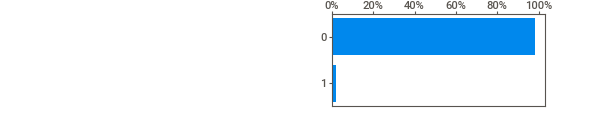
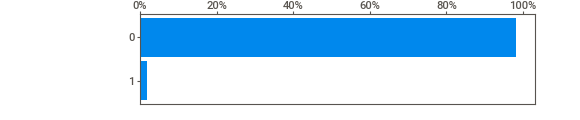
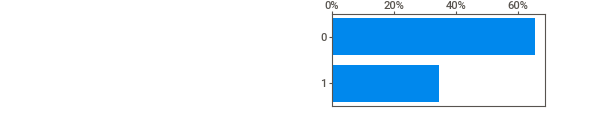
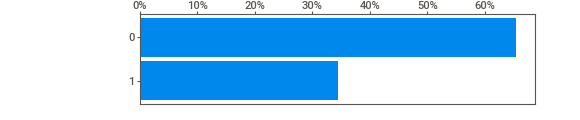
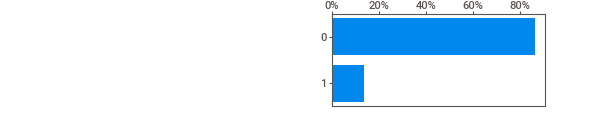
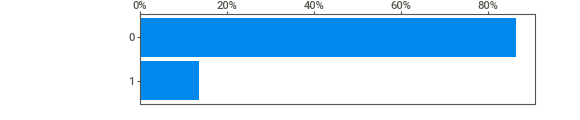
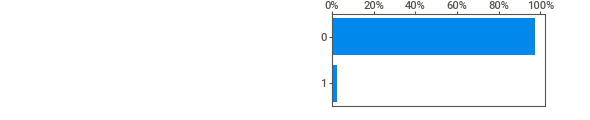
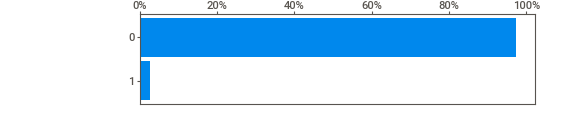
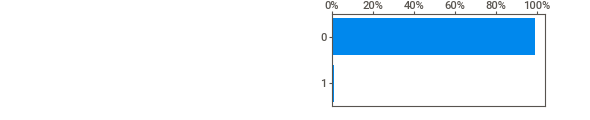
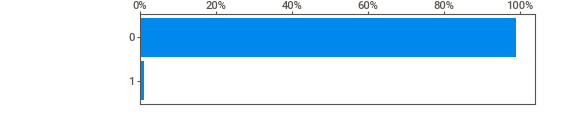
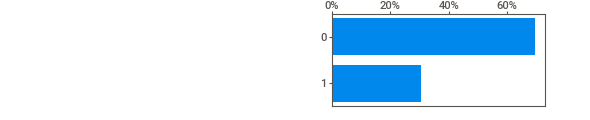
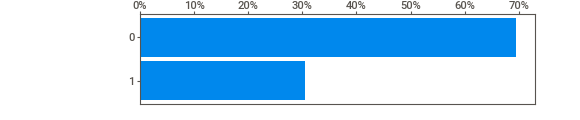
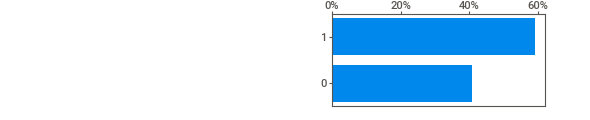
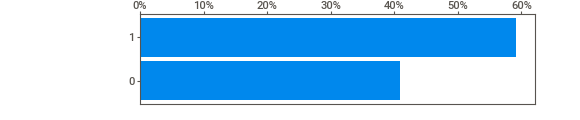
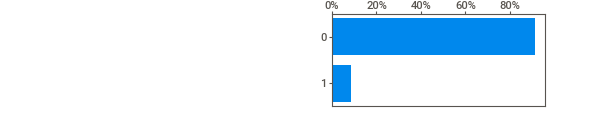
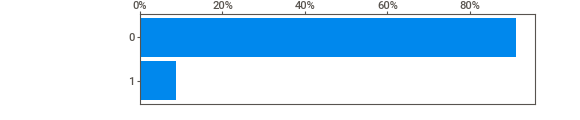
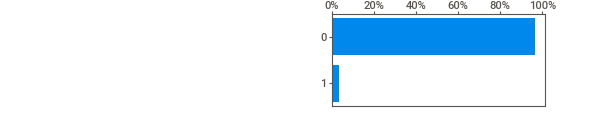
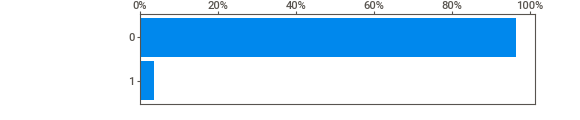
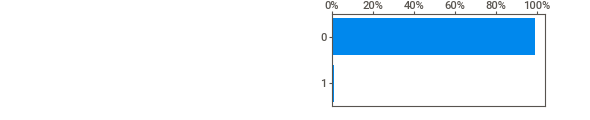
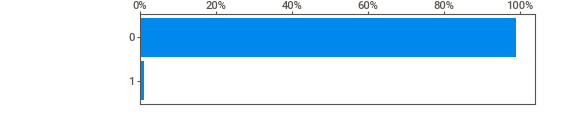
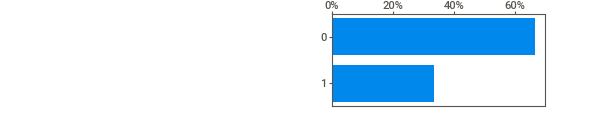
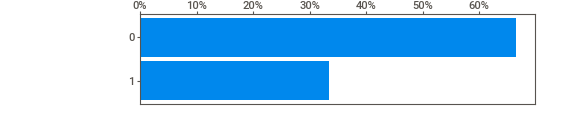
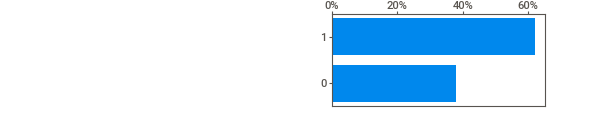
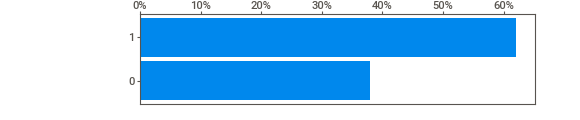
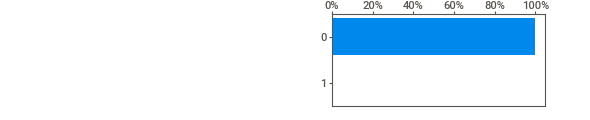
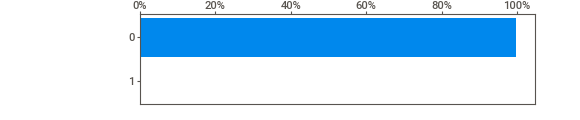
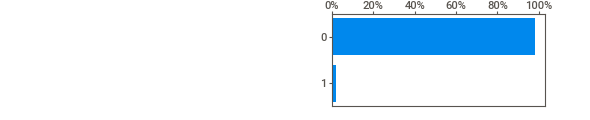
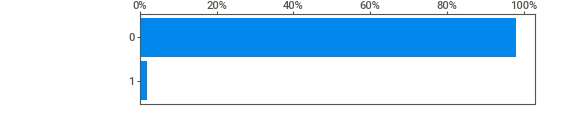
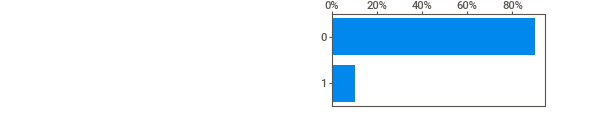
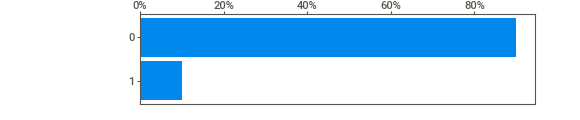
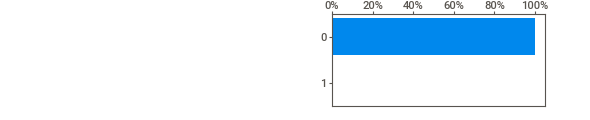
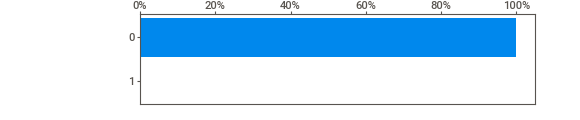
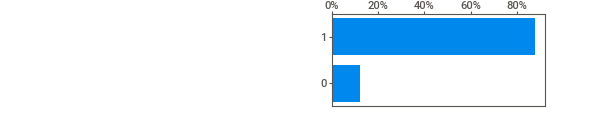
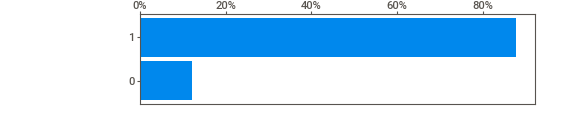
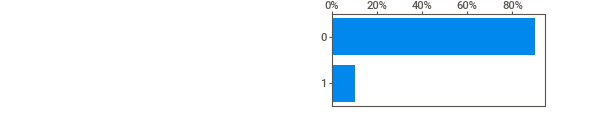
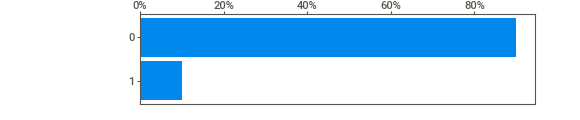
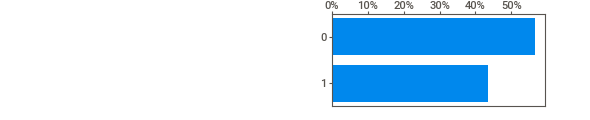
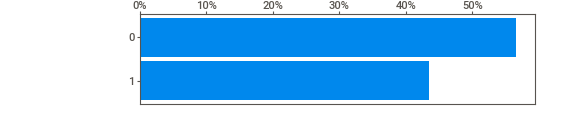
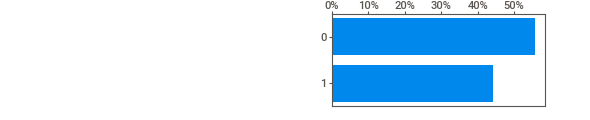
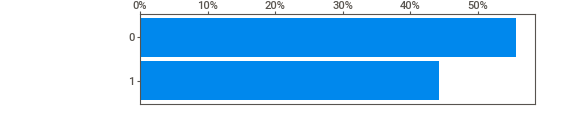
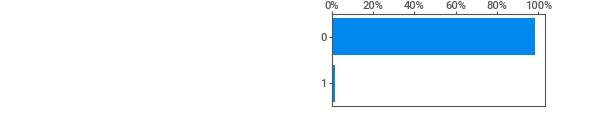
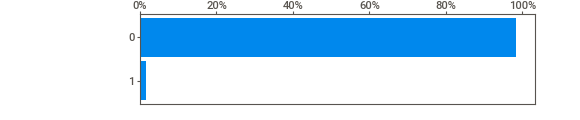
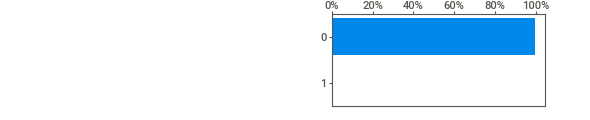
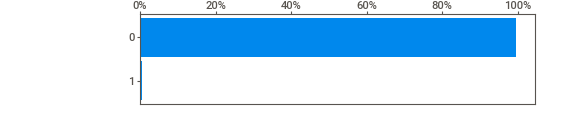
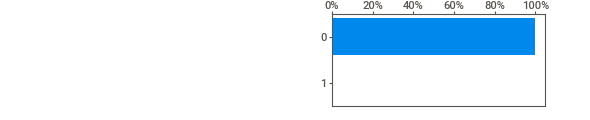
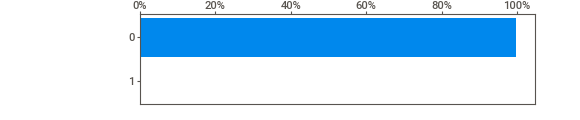
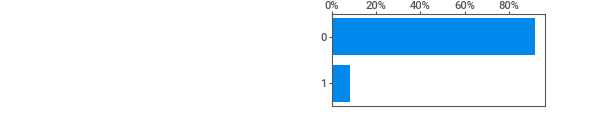
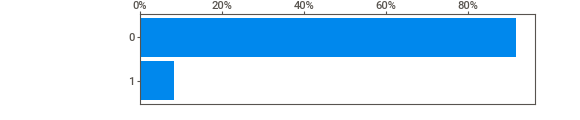
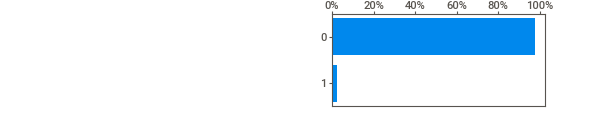
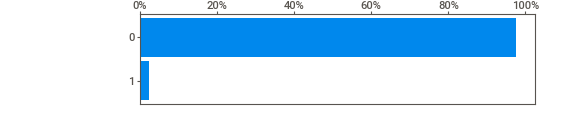
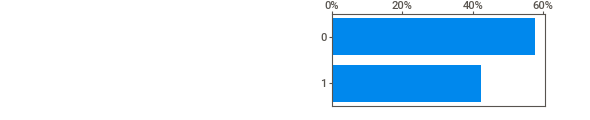
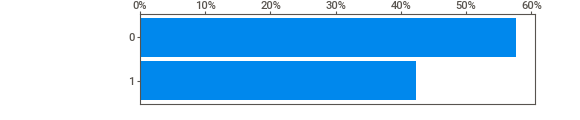
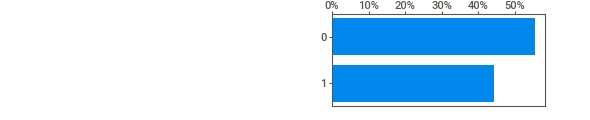
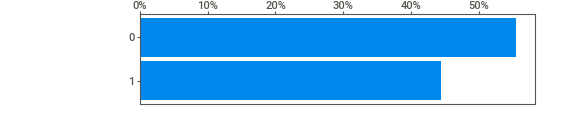
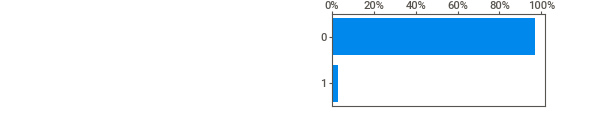
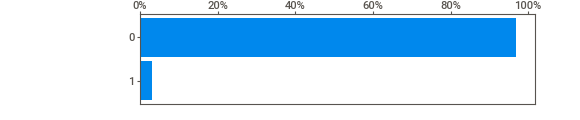
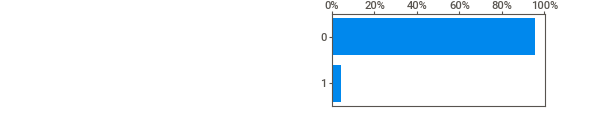
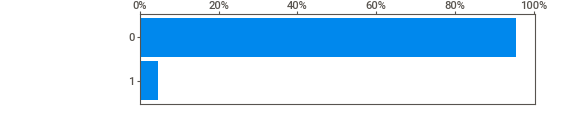
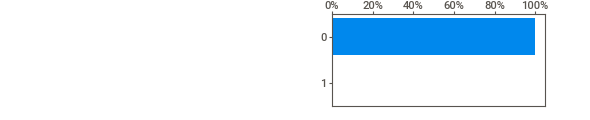
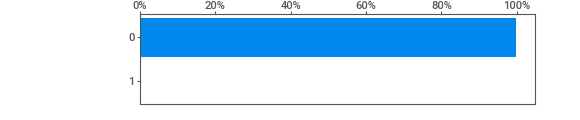
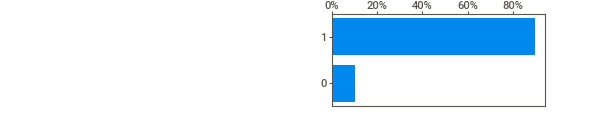
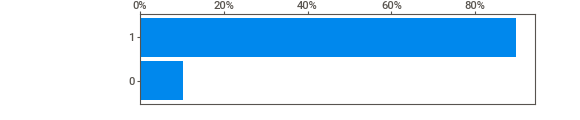
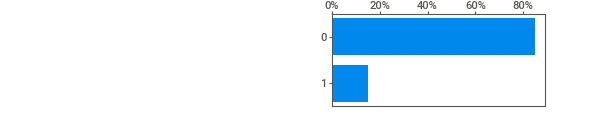
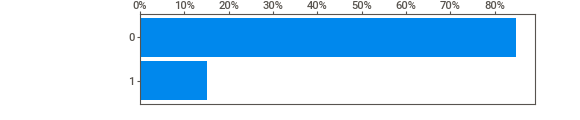
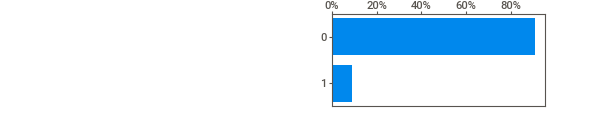
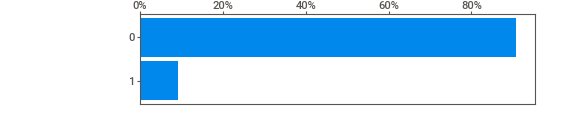
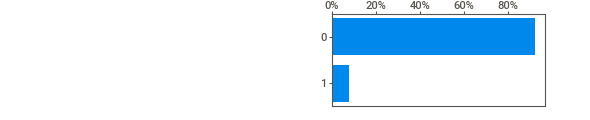
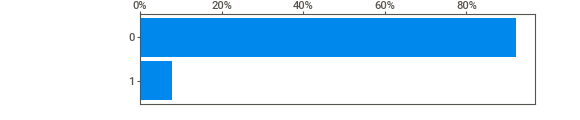
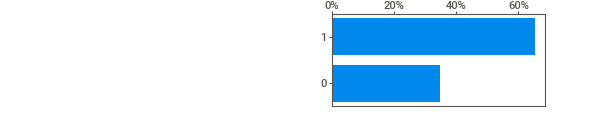
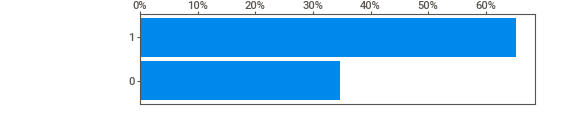
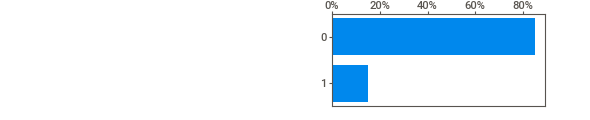
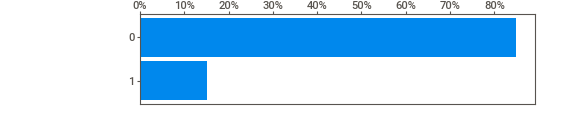
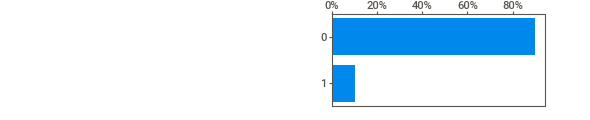
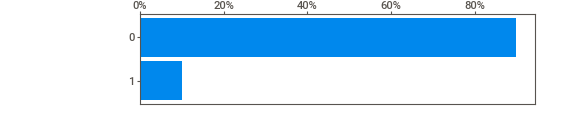
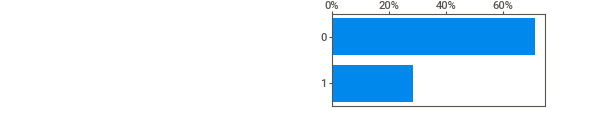
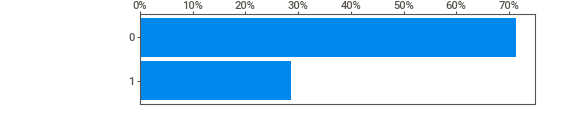
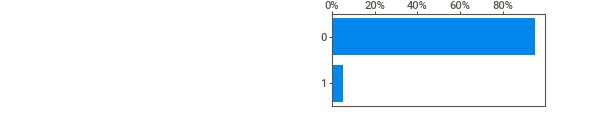
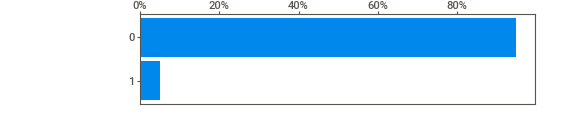
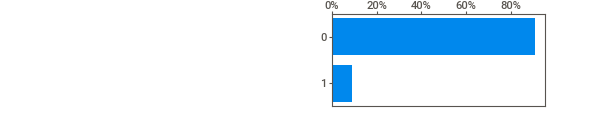
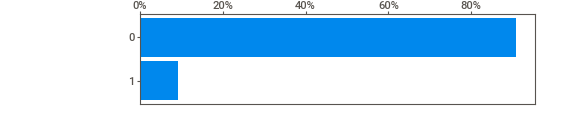
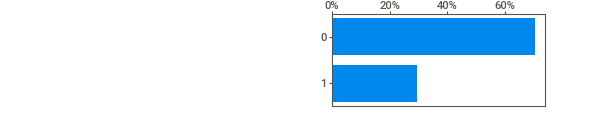
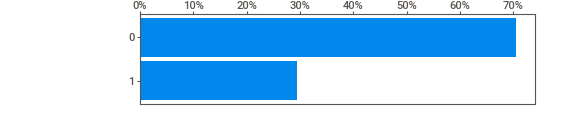
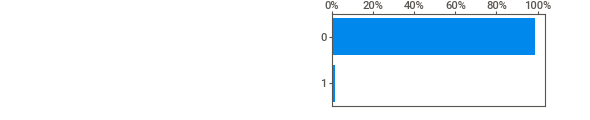
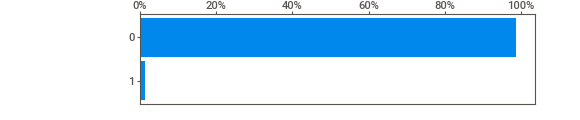
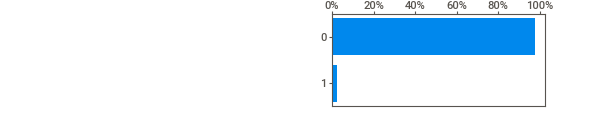
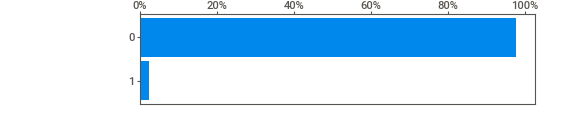
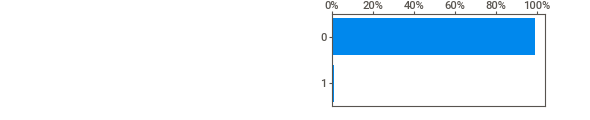
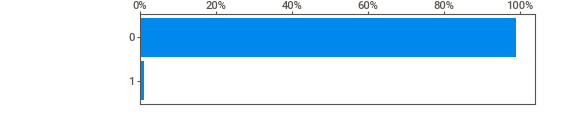
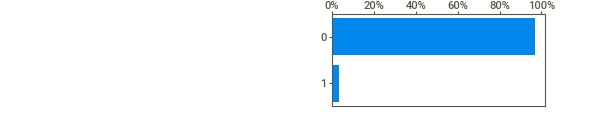
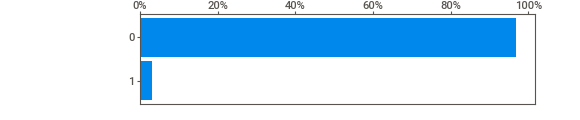
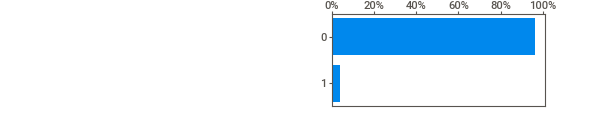
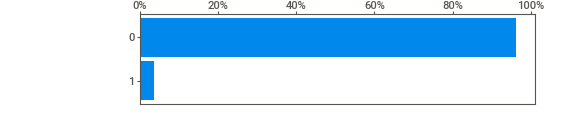
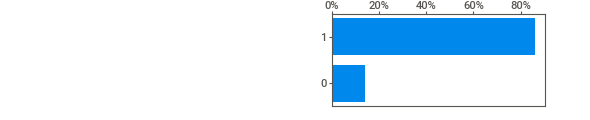
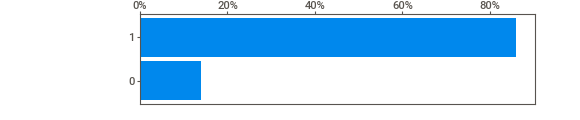
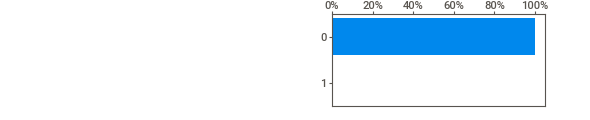
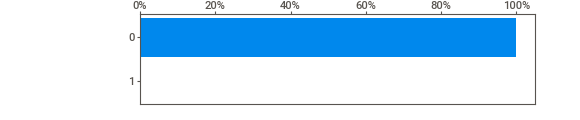
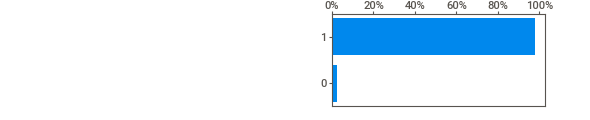
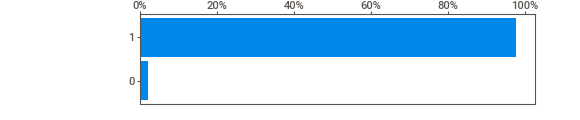
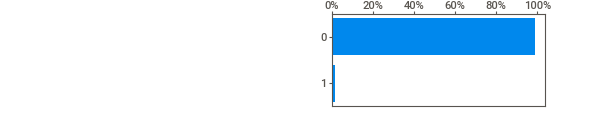
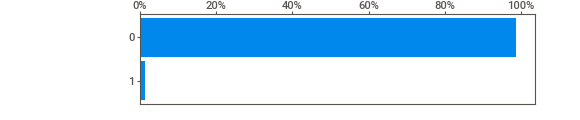
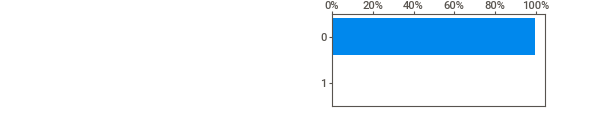
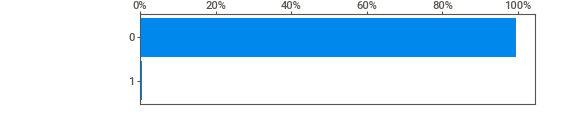
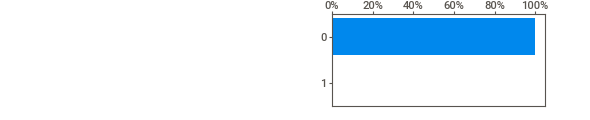
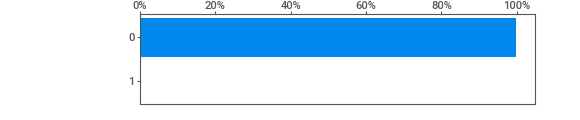
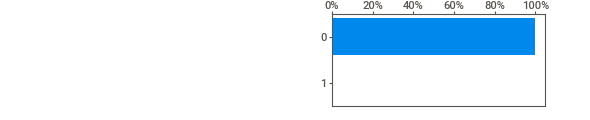
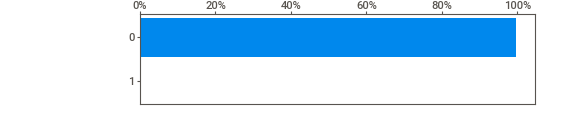
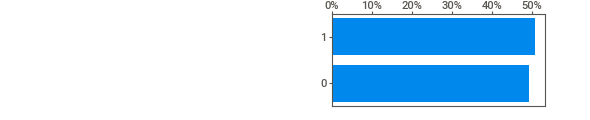
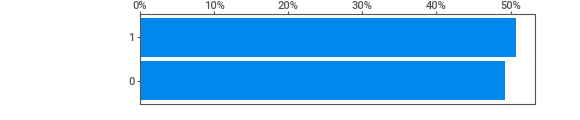
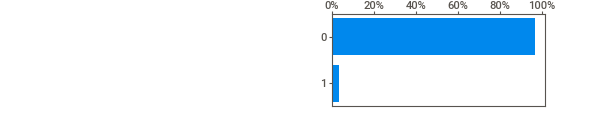
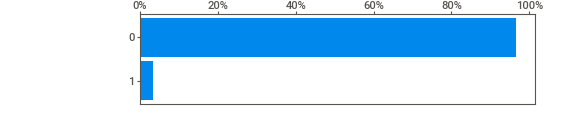
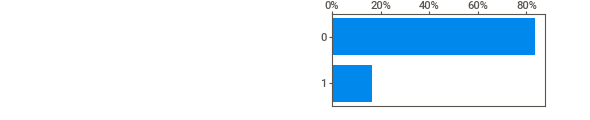
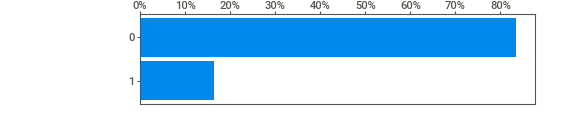
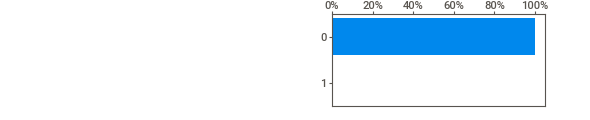
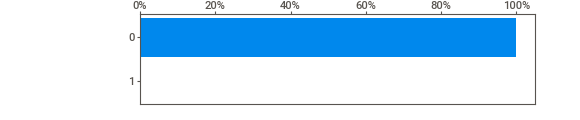
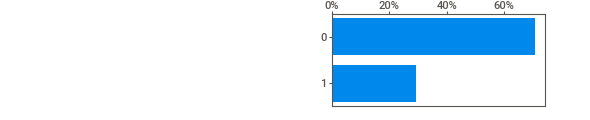
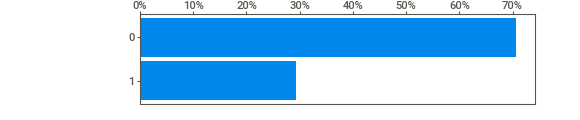
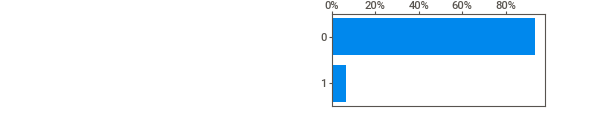
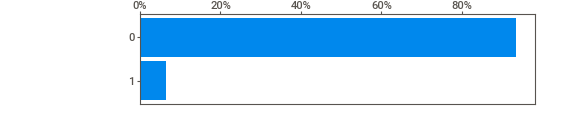
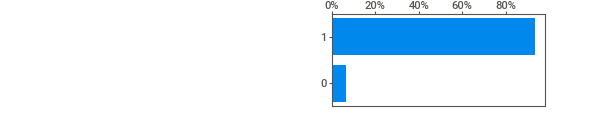
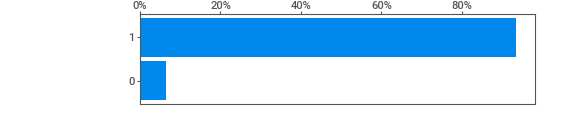
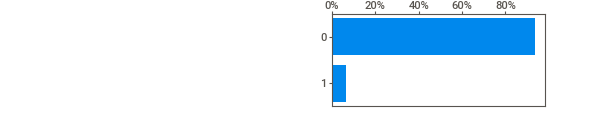
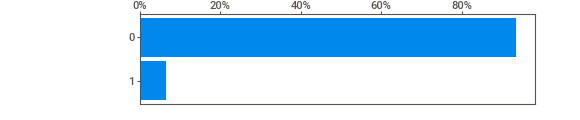
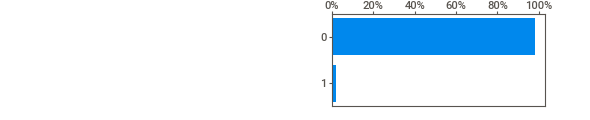
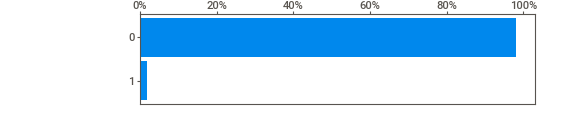
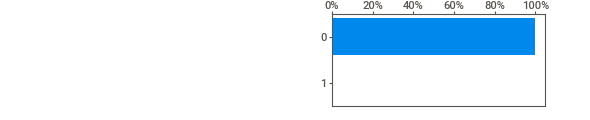
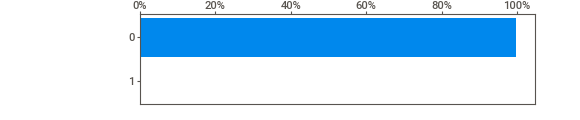
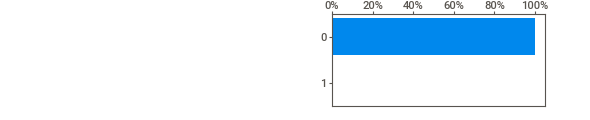
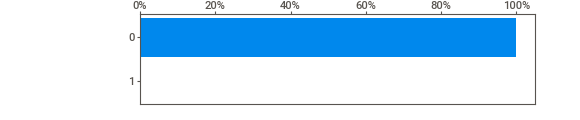
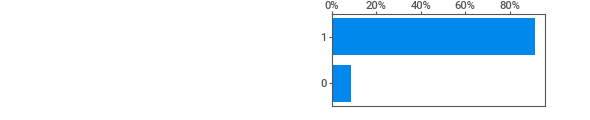
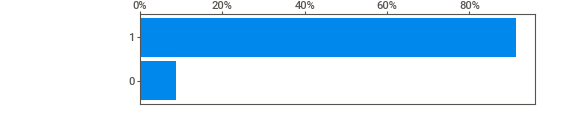
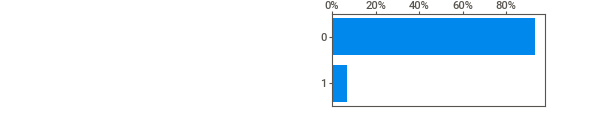
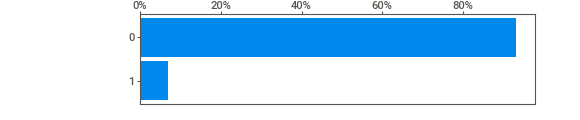
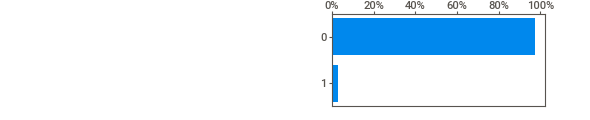
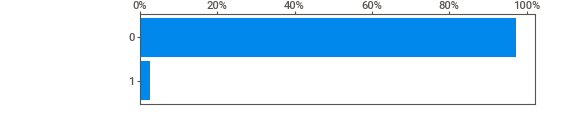
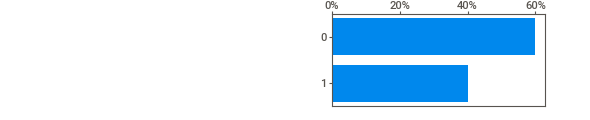
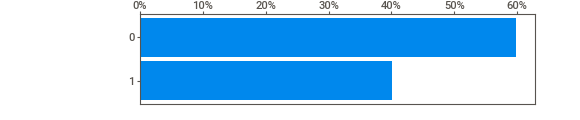
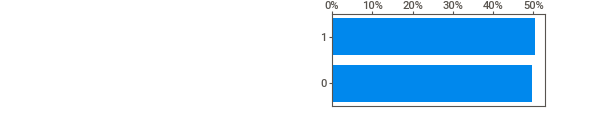
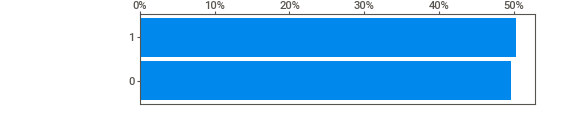
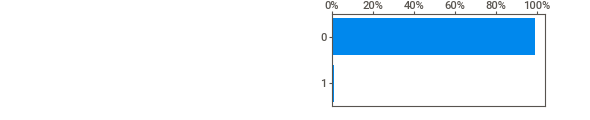
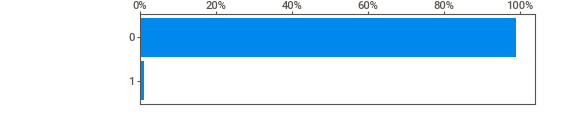
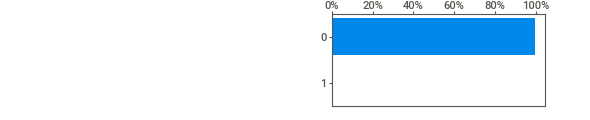
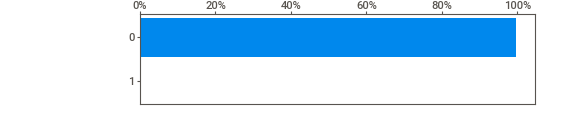
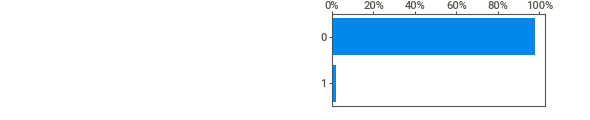
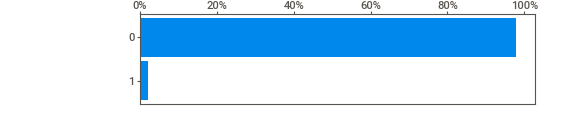
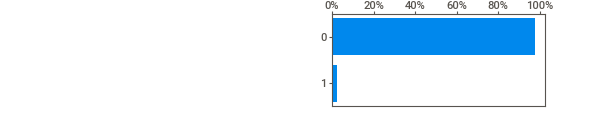
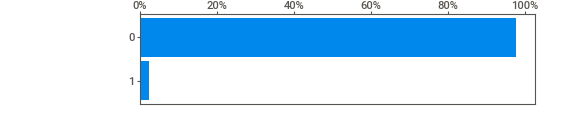
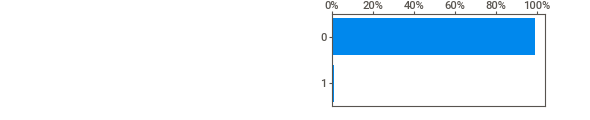
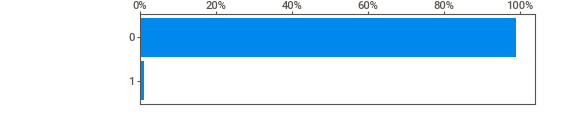
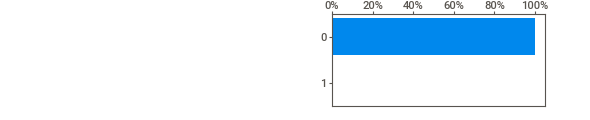
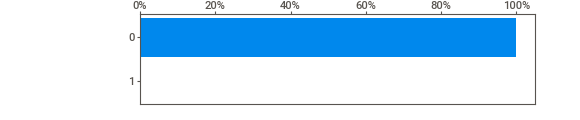
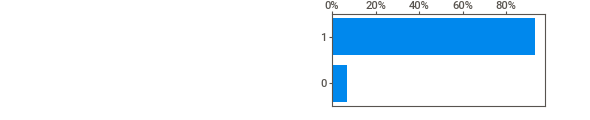
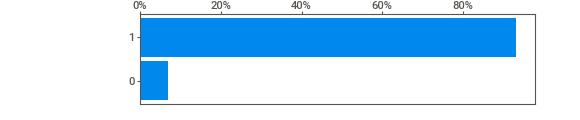
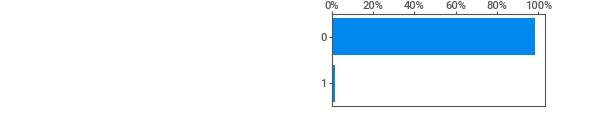
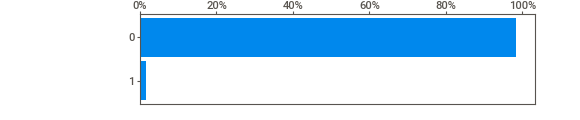
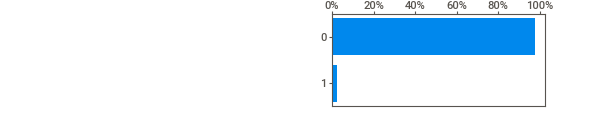
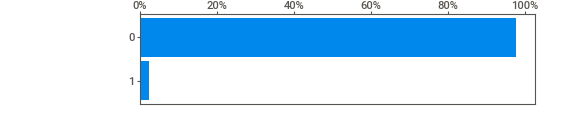
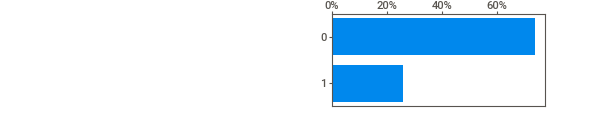
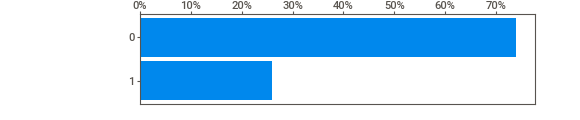
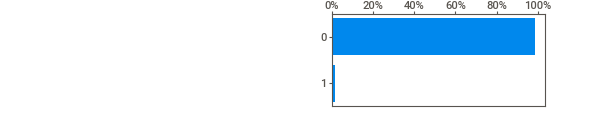
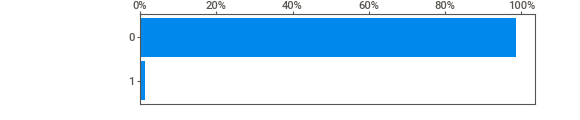
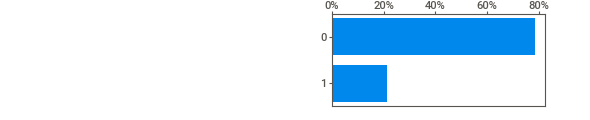
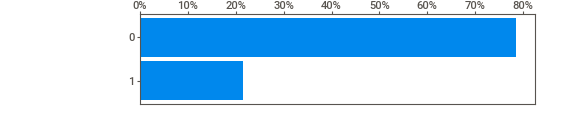
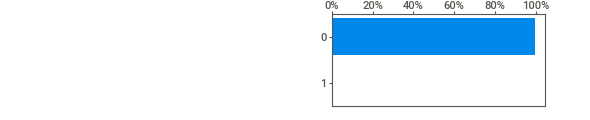
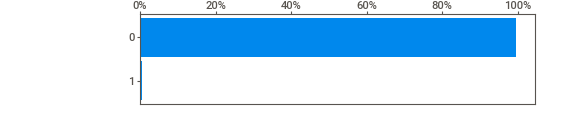
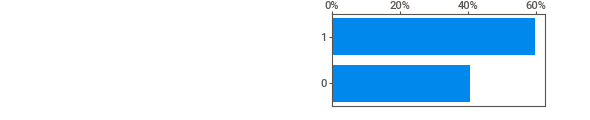
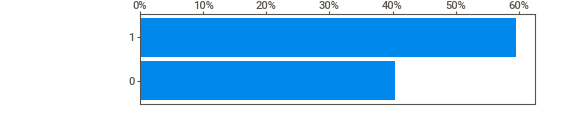
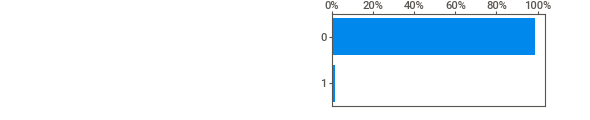
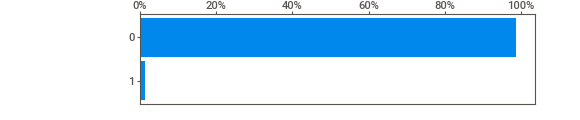
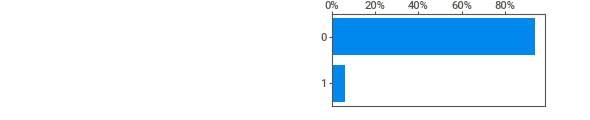
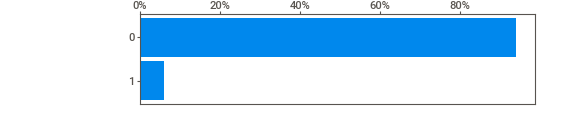
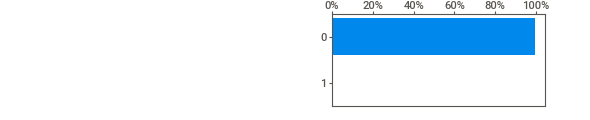
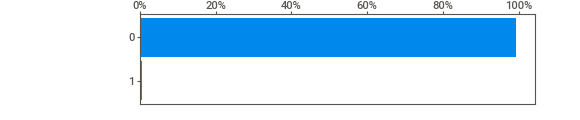
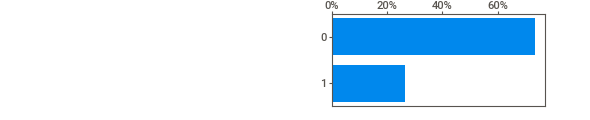
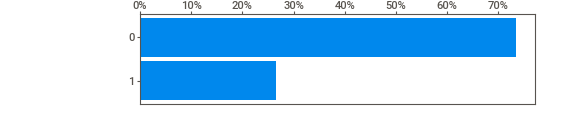
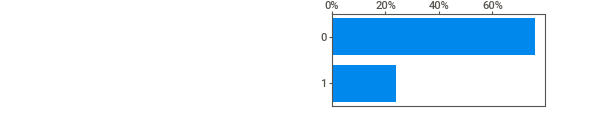
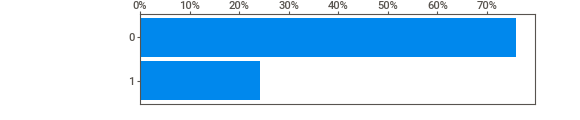
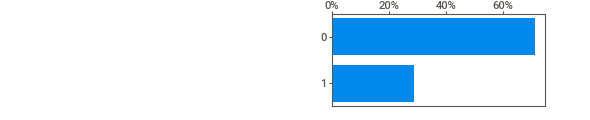
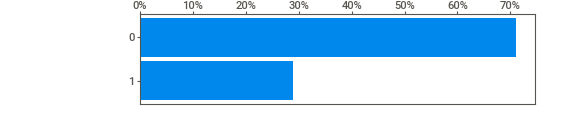
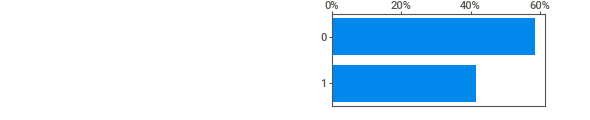
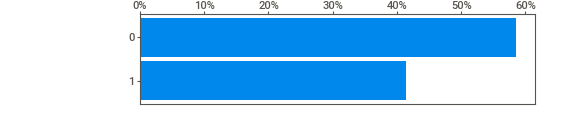
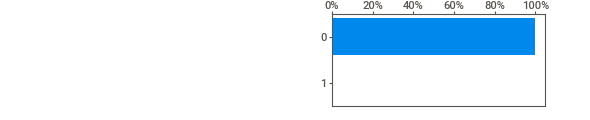
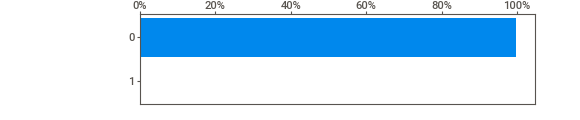
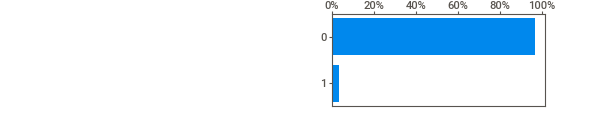
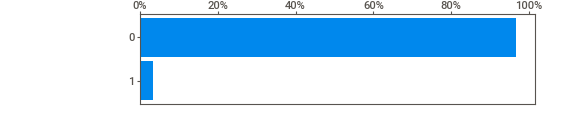
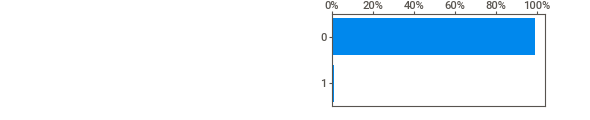
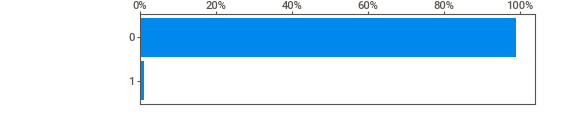
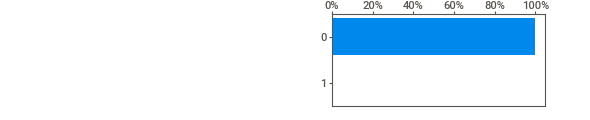
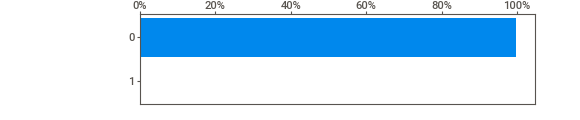
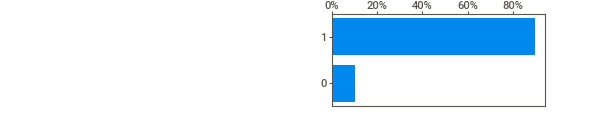
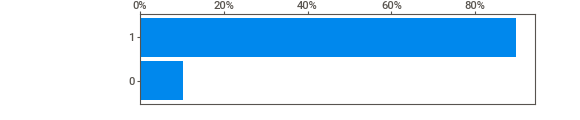
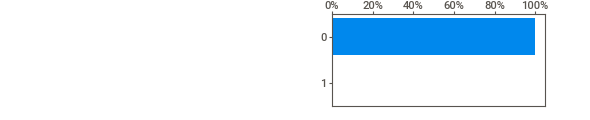
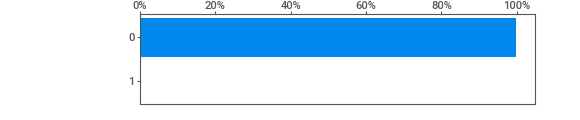
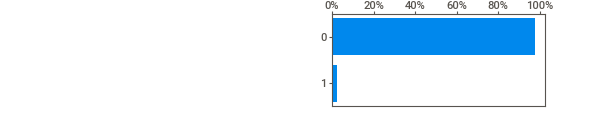
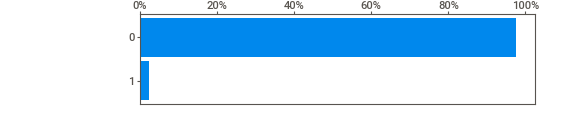
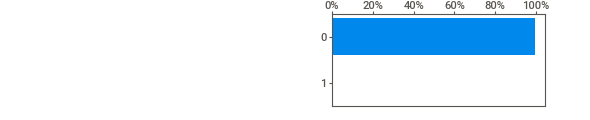
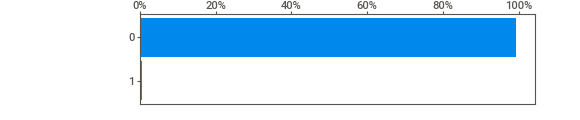
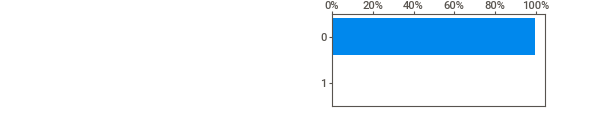
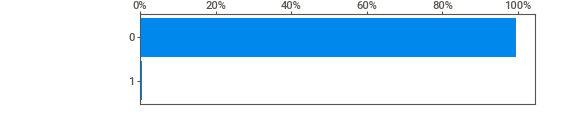
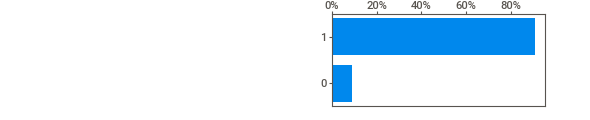
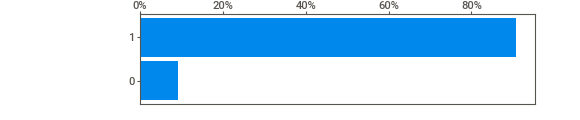
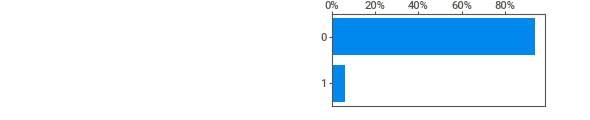
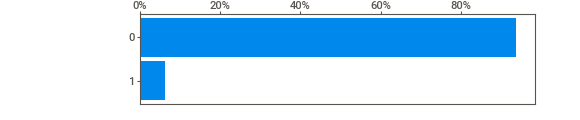
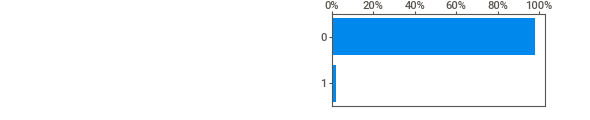
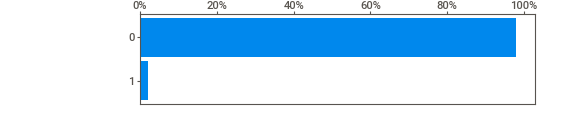
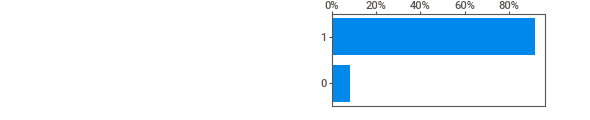
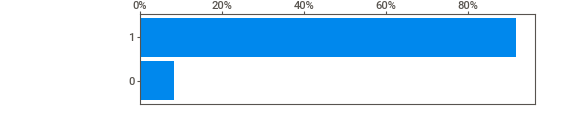
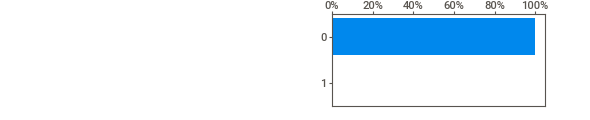
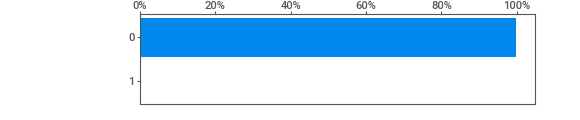
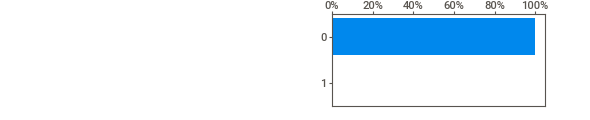
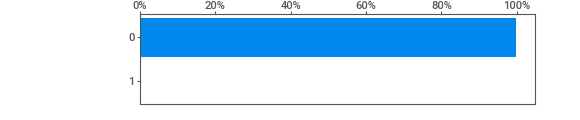
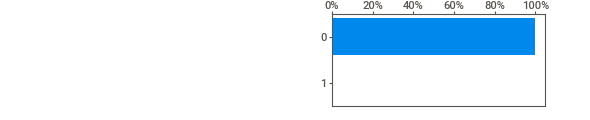
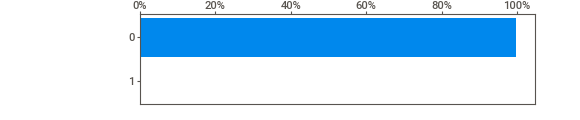
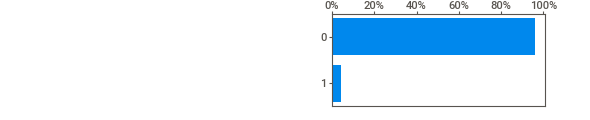
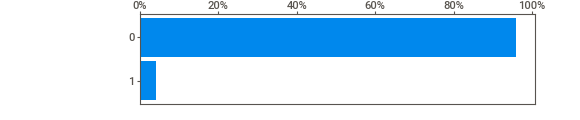
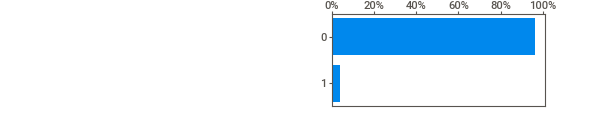
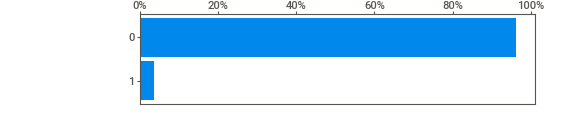
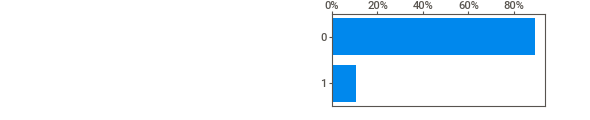
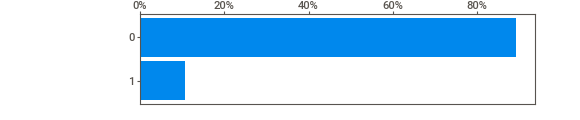
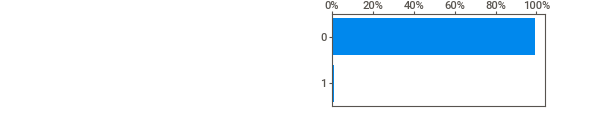
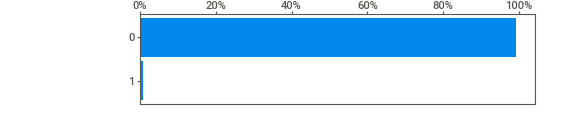
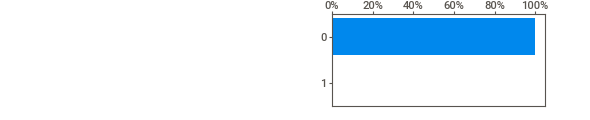
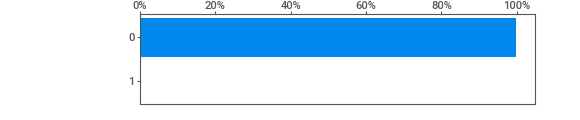
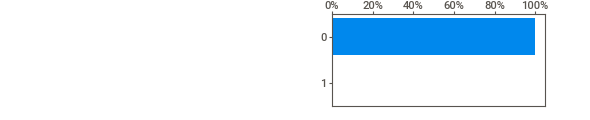
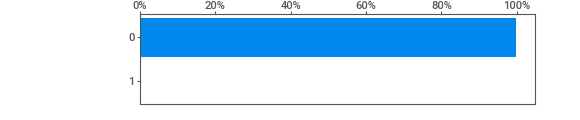
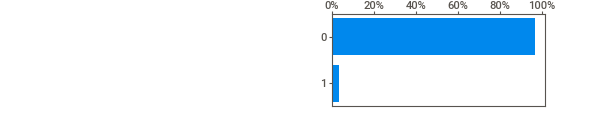
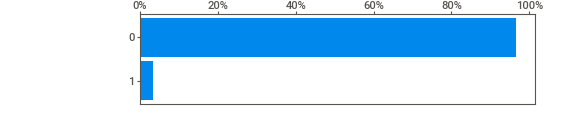
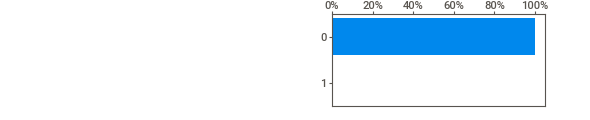
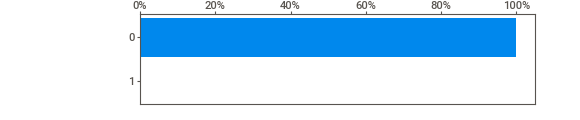
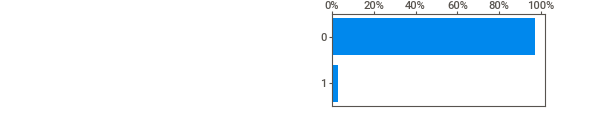
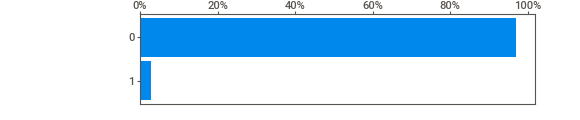
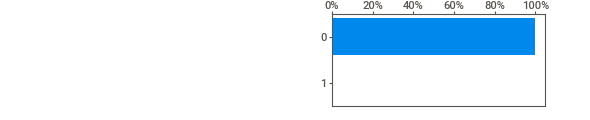
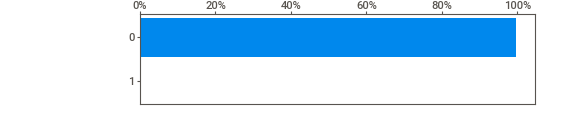
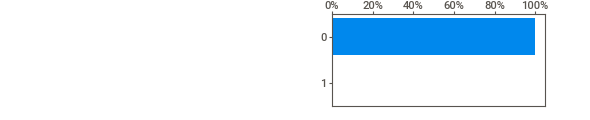
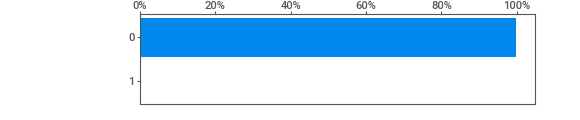
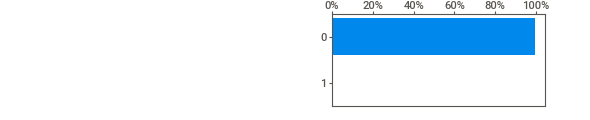
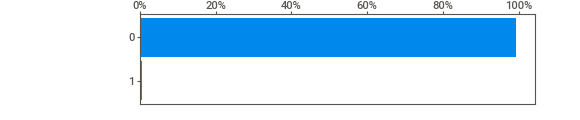
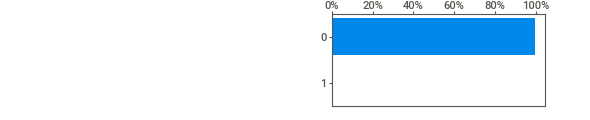
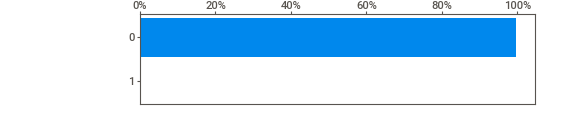
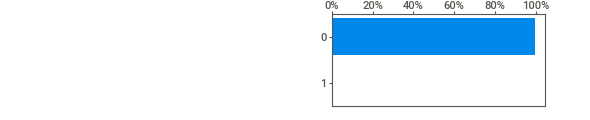
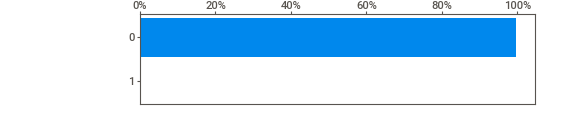
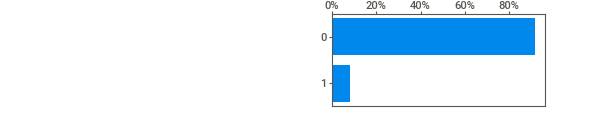
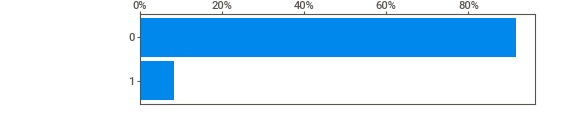
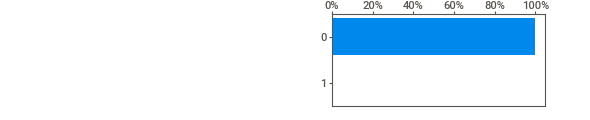
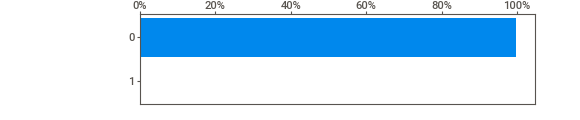
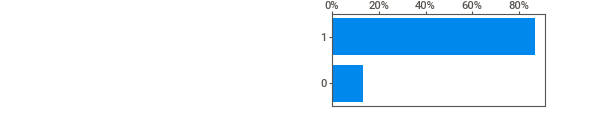
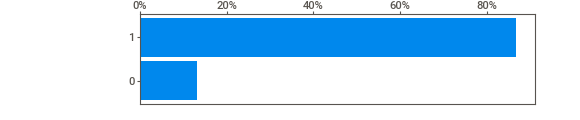
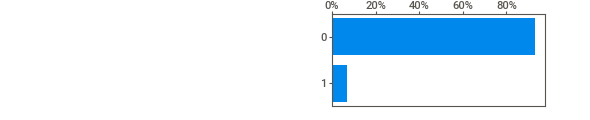
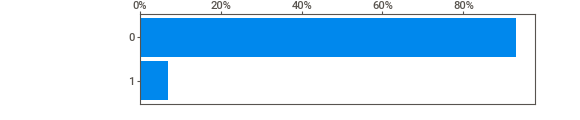
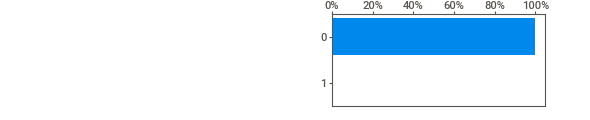
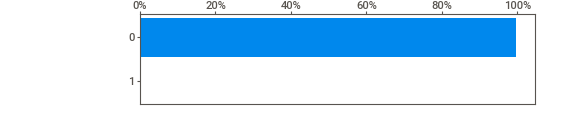
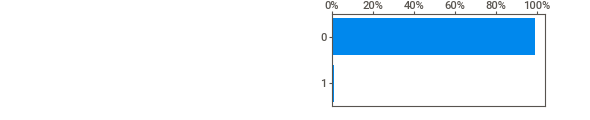
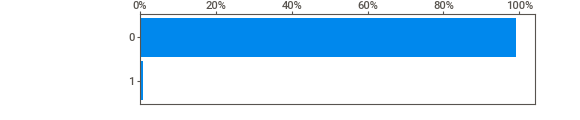
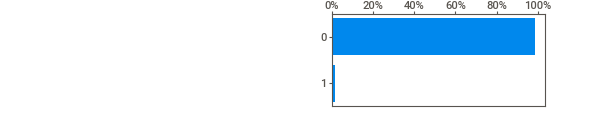
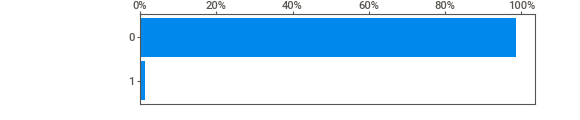
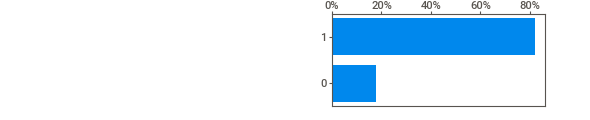
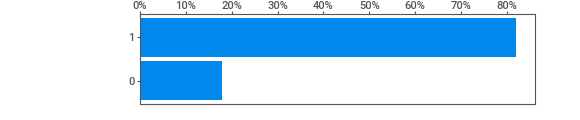
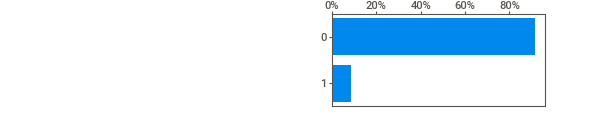
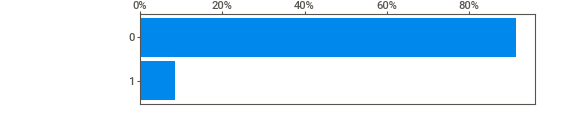

In [13]:
train_report = sw.analyze(train_df,pairwise_analysis='off')
train_report.show_notebook(layout='vertical')

We can see from those graphs what values normally distribute, higher and lower corralation. \
Because we use a lot of features, we will also use another graphs.

## **Build the Train Model**

### **Correlation**

In [14]:
traincpy_df = train_df.copy() # Copy of train_df
t_col = traincpy_df['SalePrice']
traincpy_df.drop('SalePrice', axis=1, inplace=True) # Just fo position this in left, easy for me to see
traincpy_df.insert(0, 'SalePrice', t_col)

traincpy_df.head()

SalePrice  Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0     208500   1          60         65.0     8450            7            5   
1     181500   2          20         80.0     9600            6            8   
2     223500   3          60         68.0    11250            7            5   
3     140000   4          70         60.0     9550            7            5   
4     250000   5          60         84.0    14260            8            5   

   YearBuilt  YearRemodAdd  MasVnrArea  ...  SaleType_ConLw  SaleType_New  \
0       2003          2003       196.0  ...               0             0   
1       1976          1976         0.0  ...               0             0   
2       2001          2002       162.0  ...               0             0   
3       1915          1970         0.0  ...               0             0   
4       2000          2000       350.0  ...               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0            1                      0                      0   
1             0            1                      0                      0   
2             0            1                      0                      0   
3             0            1                      1                      0   
4             0            1                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 290 columns]

we have 53 of fetures with high corrleation


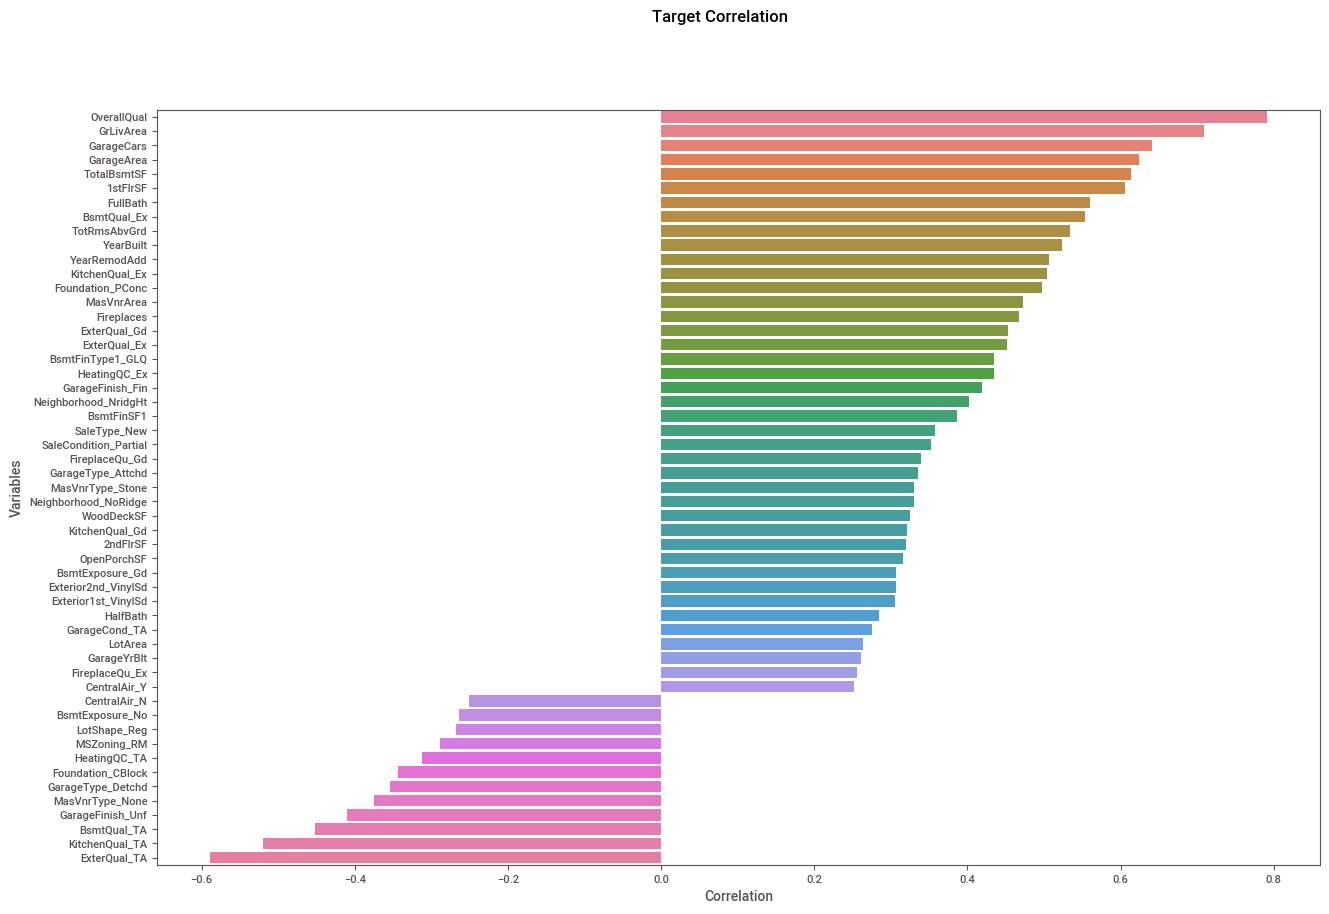

In [15]:
plt.rcParams["figure.figsize"] = (7,3)
cor = traincpy_df.corr()
temp = cor['SalePrice'].sort_values(ascending = False).reset_index()
temp = temp[temp["index"] != 'SalePrice']
temp.columns = ["Variables", "Correlation"]
highly = temp[(temp["Correlation"] >= 0.25) | (temp["Correlation"] <= -0.25)]
plt.figure(figsize = (15, 10))  
p = sns.barplot(highly.Correlation, highly["Variables"], palette="husl")
plt.suptitle("Target Correlation")

print(f'we have {len(highly)} of fetures with high corrleation')

Now we will remove all features that their correlation is under |0.25|

In [16]:
cols_to_keep = highly['Variables'].tolist()
testcpy_df = test_df[cols_to_keep]

cols_to_keep.append('SalePrice') # The target 
traincpy_df = train_df[cols_to_keep]
test_cols_to_keep = cols_to_keep.copy()

traincpy_df.info()
print(f'\n\nNow traincpy_df data contain {traincpy_df.shape[1]} features\n')

# We will also keep the test's same cols
testcpy_df.info()
print(f'\n\nNow testcpy_df data contain {testcpy_df.shape[1]} features\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallQual            1460 non-null   int64  
 1   GrLivArea              1460 non-null   int64  
 2   GarageCars             1460 non-null   int64  
 3   GarageArea             1460 non-null   int64  
 4   TotalBsmtSF            1460 non-null   int64  
 5   1stFlrSF               1460 non-null   int64  
 6   FullBath               1460 non-null   int64  
 7   BsmtQual_Ex            1460 non-null   uint8  
 8   TotRmsAbvGrd           1460 non-null   int64  
 9   YearBuilt              1460 non-null   int64  
 10  YearRemodAdd           1460 non-null   int64  
 11  KitchenQual_Ex         1460 non-null   uint8  
 12  Foundation_PConc       1460 non-null   uint8  
 13  MasVnrArea             1460 non-null   float64
 14  Fireplaces             1460 non-null   int64  
 15  Exte

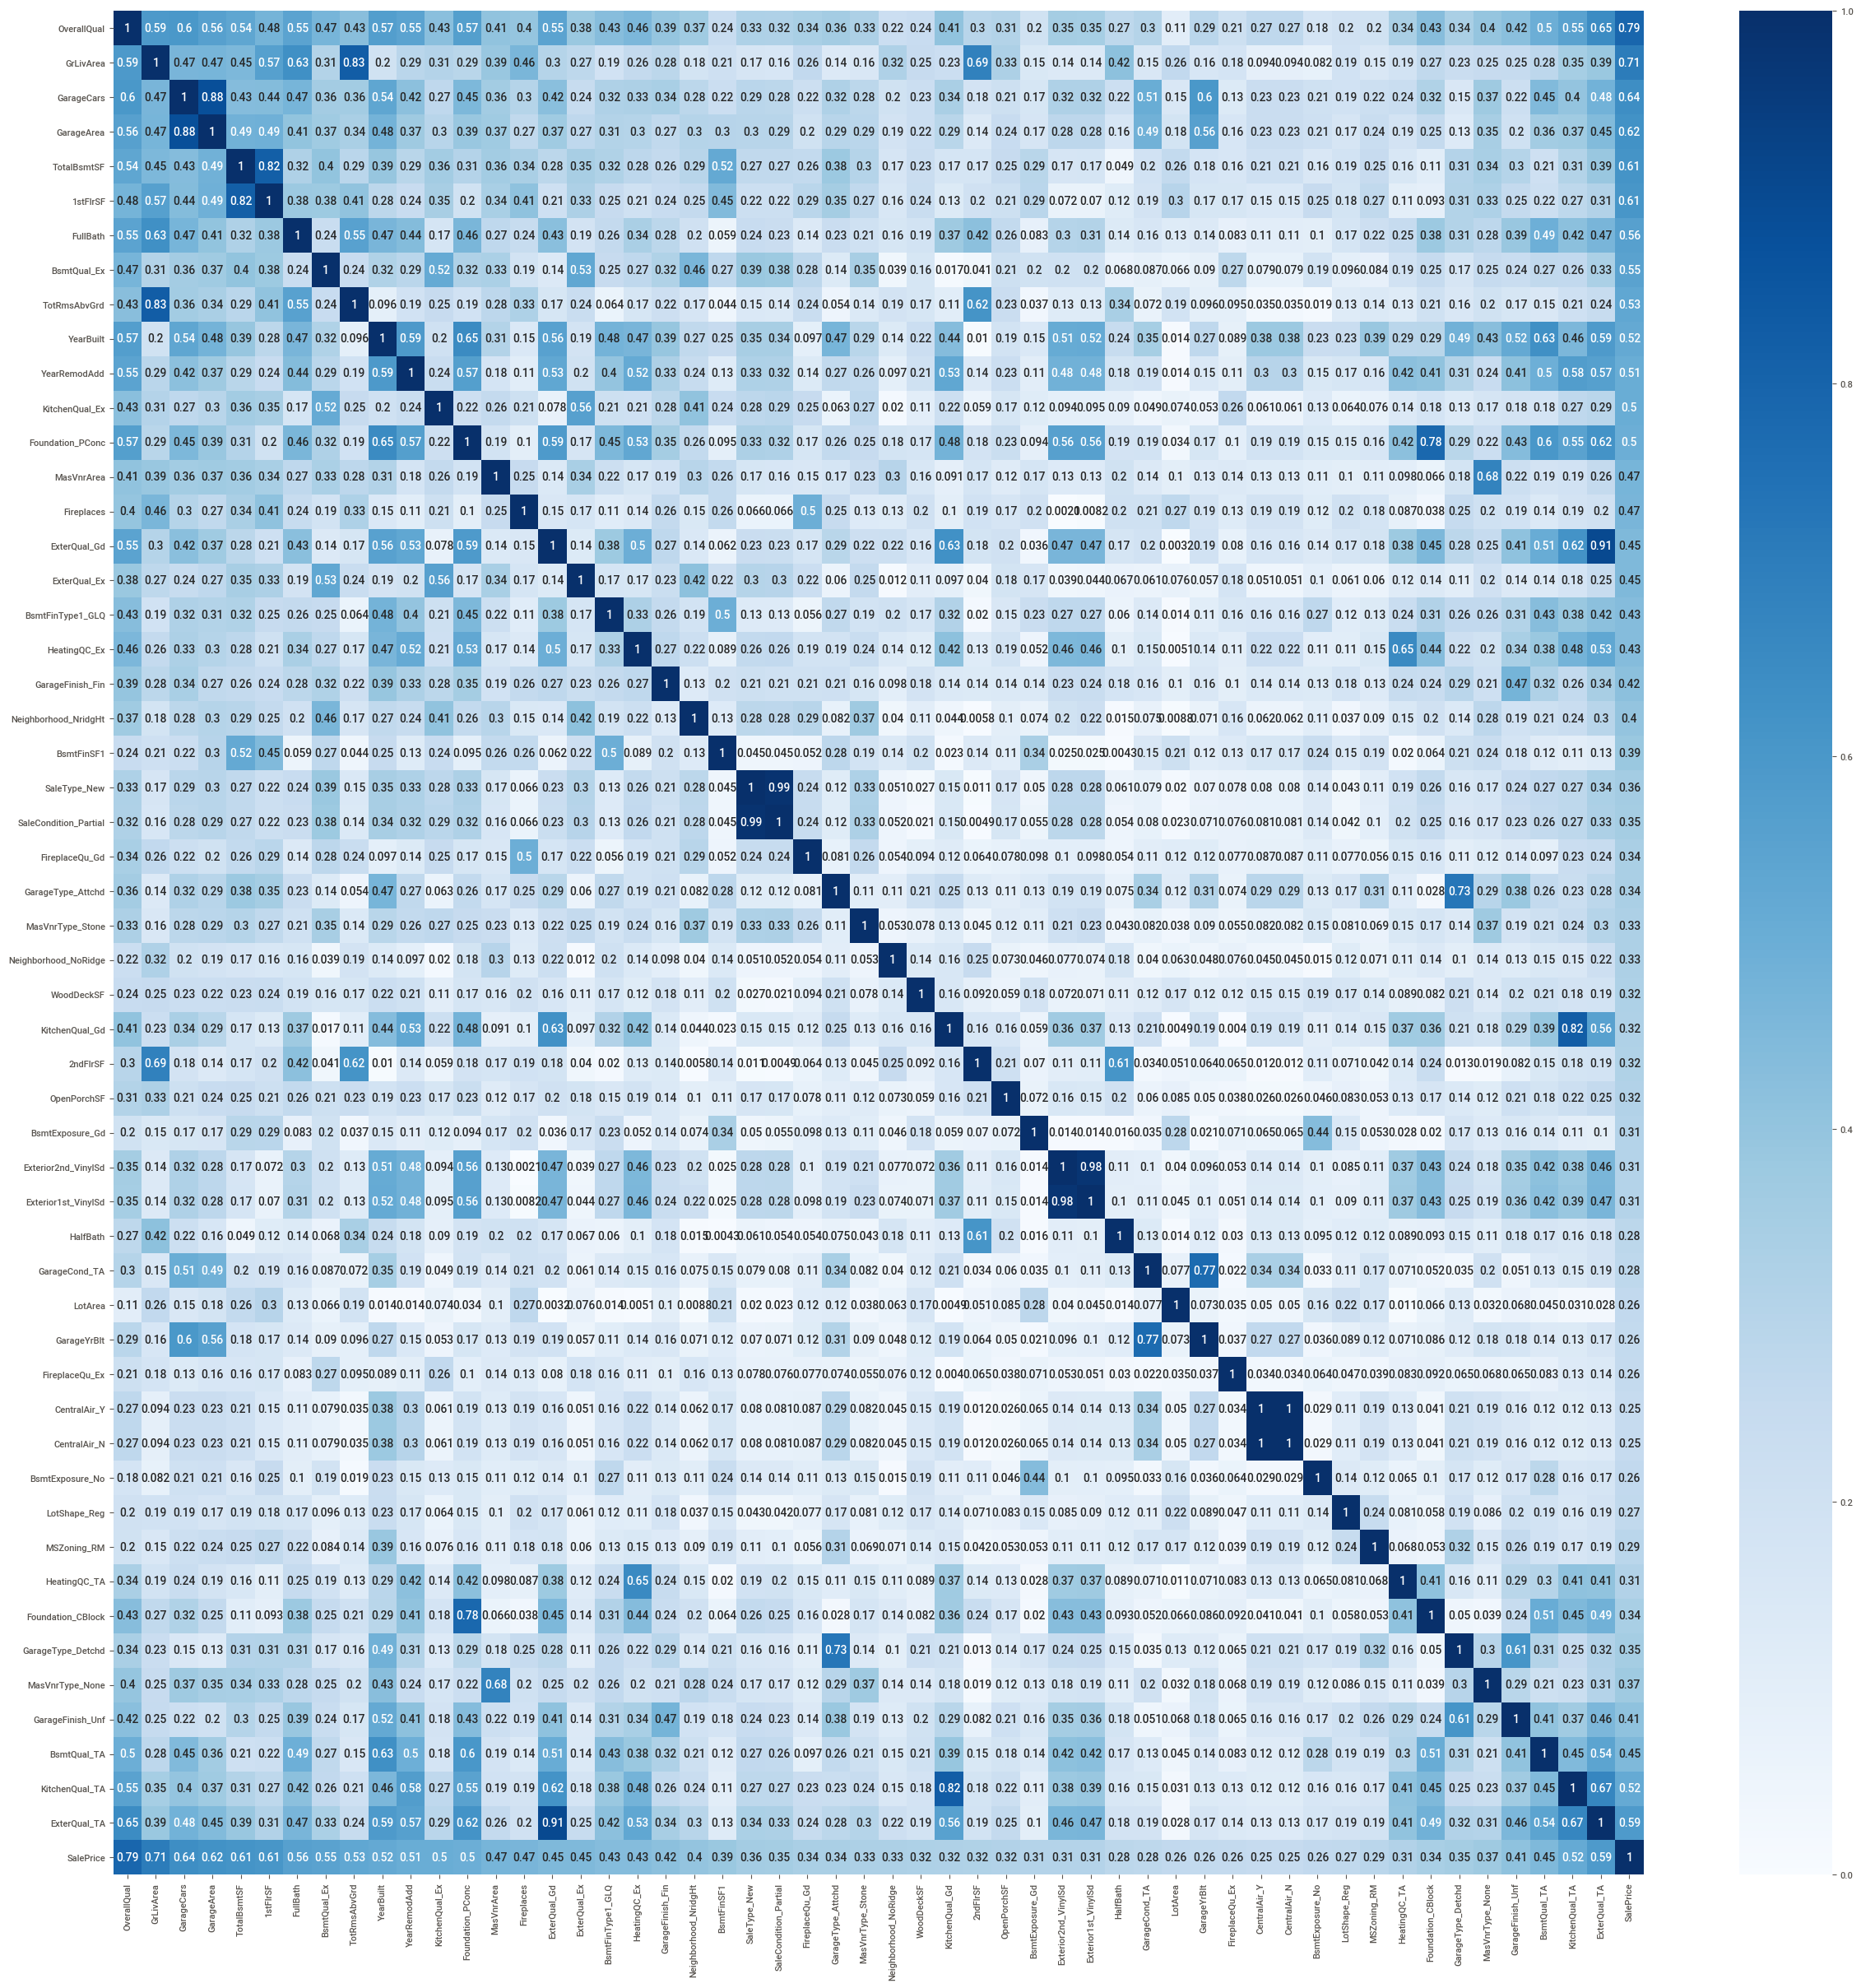

In [17]:
def heat_map(df):
    plt.figure(figsize=(30,30))
    cor = np.abs(df.corr())
    sns.heatmap(cor, annot=True, cmap=plt.cm.Blues, vmin=0, vmax=1)
    plt.show()

heat_map(traincpy_df)

### **Train**

In [18]:
# Splits the data to features and target
traincp_df = traincpy_df.copy()
traincp_df.drop('SalePrice',axis=1, inplace=True)
X = traincp_df
t = train_df['SalePrice'].copy()

display(X)
print(f'X contain {X.shape[1]} features \n')

OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
0               7       1710           2         548          856       856   
1               6       1262           2         460         1262      1262   
2               7       1786           2         608          920       920   
3               7       1717           3         642          756       961   
4               8       2198           3         836         1145      1145   
...           ...        ...         ...         ...          ...       ...   
1455            6       1647           2         460          953       953   
1456            6       2073           2         500         1542      2073   
1457            7       2340           1         252         1152      1188   
1458            5       1078           1         240         1078      1078   
1459            5       1256           1         276         1256      1256   

      FullBath  BsmtQual_Ex  TotRmsAbvGrd  YearBuilt  ...  LotShape_Reg  \
0            2            0             8       2003  ...             1   
1            2            0             6       1976  ...             1   
2            2            0             6       2001  ...             0   
3            1            0             7       1915  ...             0   
4            2            0             9       2000  ...             0   
...        ...          ...           ...        ...  ...           ...   
1455         2            0             7       1999  ...             1   
1456         2            0             7       1978  ...             1   
1457         2            0             9       1941  ...             1   
1458         1            0             5       1950  ...             1   
1459         1            0             6       1965  ...             1   

      MSZoning_RM  HeatingQC_TA  Foundation_CBlock  GarageType_Detchd  \
0               0             0                  0                  0   
1               0             0                  1                  0   
2               0             0                  0                  0   
3               0             0                  0                  1   
4               0             0                  0                  0   
...           ...           ...                ...                ...   
1455            0             0                  0                  0   
1456            0             1                  1                  0   
1457            0             0                  0                  0   
1458            0             0                  1                  0   
1459            0             0                  1                  0   

      MasVnrType_None  GarageFinish_Unf  BsmtQual_TA  KitchenQual_TA  \
0                   0                 0            0               0   
1                   1                 0            0               1   
2                   0                 0            0               0   
3                   1                 1            1               0   
4                   0                 0            0               0   
...               ...               ...          ...             ...   
1455                1                 0            0               1   
1456                0                 1            0               1   
1457                1                 0            1               0   
1458                1                 1            1               0   
1459                1                 0            1               1   

      ExterQual_TA  
0                0  
1                1  
2                0  
3                1  
4                0  
...            ...  
1455             1  
1456             1  
1457             0  
1458             1  
1459             0  

[1460 rows x 53 columns]

X contain 53 features 



### **Selecting the Model**

Lets start with our models

In [19]:
hp_models = {
             'SGD Regressor': SGDRegressor(random_state=1, ), 
             'LinearRegression': LinearRegression(), 
             'Ridge': make_pipeline(RobustScaler(), Ridge()), 
             'Lasso': make_pipeline(RobustScaler(), Lasso(random_state=1)), 
             'Elastic Net': make_pipeline(RobustScaler(), ElasticNet(random_state=1, alpha=0.05)),
             'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                                                       max_depth=4, max_features='sqrt',
                                                                       min_samples_leaf=15, min_samples_split=10, 
                                                                       loss='huber', random_state =5)
             }

Now, we will write a method that will calculate CV for a model

In [20]:
def get_cv_score_and_loss(X, t, n_model, model, k=None, show_score_loss_graphs=False, use_pbar=True):
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = KFold(n_splits=k, shuffle=True, random_state=1)
    else:
        raise ValueError('Specify k in order for the cv to work')

    if use_pbar:
        pbar = tqdm(desc=f'Computing Model {n_model}', total=cv.get_n_splits(X))

    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.iloc[train_ids]
        X_val = X.iloc[val_ids]
        t_train = t.iloc[train_ids]
        t_val = t.iloc[val_ids]

        model.fit(X_train, t_train)

        y_train = model.predict(X_train)
        y_val = model.predict(X_val)
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train), mean_squared_error(t_train, y_train, squared=False)]
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'val', model.score(X_val, t_val), mean_squared_error(t_val, y_val, squared=False)]
        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    val_scores_losses_df = scores_losses_df[scores_losses_df['split']=='val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split']=='train']

    score_mean_val = val_scores_losses_df['score'].mean()
    loss_mean_val = val_scores_losses_df['loss'].mean()
    score_mean_train = train_scores_losses_df['score'].mean()
    loss_mean_train = train_scores_losses_df['loss'].mean()

    fig_score = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Model name: {n_model}, Mean Val Score: {score_mean_val:.2f}, Mean Train Score: {score_mean_train:.2f}')
    fig_loss = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Model name: {n_model}, Mean Val Loss: {loss_mean_val:.2f}, Mean Train Loss: {loss_mean_train:.2f}')
    if show_score_loss_graphs:
        fig_loss.show()
        fig_score.show()

    return score_mean_val, loss_mean_val, score_mean_train, loss_mean_train, fig_score, fig_loss

In [21]:
def get_models_score_and_loss(X, t, models):  # a DataFrame to save results
  results = pd.DataFrame(columns=['mean val score', 'mean val loss', 'mean train score', 'mean train loss', 'fig_score', 'fig_loss'], 
                         index=hp_models.keys())
  pbar = tqdm(models.items(), total=len(models.keys()))
  numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
  categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
  all_cols = np.array(X.columns)

  for n_model, model in pbar:
    pbar.set_description(f'Calculating model {n_model}')
    preprocessor = ColumnTransformer([
    ("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
    pipe = make_pipeline(preprocessor, model)

    val_score, val_loss, train_score, train_loss, fig_score, fig_loss = get_cv_score_and_loss(X, t, n_model, pipe, k=10, show_score_loss_graphs=False, use_pbar=False)
    results.loc[n_model] = [val_score, val_loss, train_score, train_loss, fig_score, fig_loss]
  return results

res = get_models_score_and_loss(X, t, hp_models)

  0%|          | 0/6 [00:00<?, ?it/s]

In [22]:
display(res.iloc[:, :-2]) # Display all results

# Display the graphs for the best one of val score
res.iloc[np.argmax(res['mean val score'])]['fig_score'].show()
res.iloc[np.argmax(res['mean val score'])]['fig_loss'].show()

mean val score mean val loss mean train score  \
SGD Regressor                     0.750985       37811.1         0.793213   
LinearRegression                  0.760008       36931.8         0.798574   
Ridge                             0.760281       36913.3         0.798565   
Lasso                             0.760025       36930.7         0.798574   
Elastic Net                       0.762837       36814.4         0.797808   
Gradient Boosting Regressor       0.848558       30291.9         0.898667   

                            mean train loss  
SGD Regressor                       36075.3  
LinearRegression                    35618.6  
Ridge                               35619.4  
Lasso                               35618.6  
Elastic Net                         35686.6  
Gradient Boosting Regressor         25262.8

We can see from this graph that **Gradient Boosting Regressor** gives the best result.

In [23]:
best_model = hp_models[res.iloc[np.argmax(res['mean val score'])].to_frame().columns[0]]
best_model_name = res.iloc[np.argmax(res['mean val score'])].name

print(best_model_name)
print(best_model)

Gradient Boosting Regressor
GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, random_state=5)


### **Features Selection**

To make sure that our features will give us the best results, I decided to use `RFE` from sklearn, that will use **Backward Feature Selection algorithm**. \
The algorithm will remove features until we will get the best results with minimum number of features.

In [24]:
def bw_feature_selection(X, t, n_model, model):
  res_df = pd.DataFrame(columns=['features_count','score_mean_val','loss_mean_val','score_mean_train','loss_mean_train','best_features'])
  pbar = tqdm(range(10, len(X.columns)+1), total=len(X.columns)+1 - 10)
  for i in pbar: 
    pbar.set_description(f'Calculates for {i} features')
    selector = RFE(model, n_features_to_select=i).fit(X, t)
    score_mean_val, loss_mean_val, score_mean_train, loss_mean_train, fig_score, fig_loss = get_cv_score_and_loss(X, t, n_model, selector, k=7, use_pbar=False)
    if score_mean_val < 0:
      break
    res_df.loc[len(res_df)] = [i, score_mean_val, loss_mean_val, score_mean_train, loss_mean_train, selector.support_] 
  
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=res_df['features_count'], y=res_df['score_mean_val']))
  fig.update_xaxes(title_text='Number of features selected')
  fig.update_yaxes(title_text='Cross validation score')
  fig.show()

  return res_df

results_scores = bw_feature_selection(X, t, best_model_name, best_model)

  0%|          | 0/44 [00:00<?, ?it/s]

In [25]:
display(results_scores.iloc[:, :-1])

features_count  score_mean_val  loss_mean_val  score_mean_train  \
0              10        0.853009   30124.632626          0.891169   
1              11        0.852334   30178.081494          0.893246   
2              12        0.857393   29692.639311          0.895634   
3              13        0.861401   29278.564972          0.895731   
4              14        0.861811   29240.706441          0.897901   
5              15        0.861120   29303.587299          0.897396   
6              16        0.862185   29186.074149          0.900254   
7              17        0.860225   29421.514965          0.899283   
8              18        0.861224   29313.764337          0.900443   
9              19        0.859431   29439.419083          0.899375   
10             20        0.860047   29435.836961          0.899675   
11             21        0.858678   29513.422601          0.899037   
12             22        0.860688   29361.679475          0.899548   
13             23        0.862561   29149.589816          0.898104   
14             24        0.859776   29459.094766          0.898927   
15             25        0.862033   29210.476626          0.901099   
16             26        0.861255   29314.213888          0.901039   
17             27        0.859621   29492.740092          0.900465   
18             28        0.859689   29478.772628          0.900554   
19             29        0.860175   29409.476757          0.899691   
20             30        0.859489   29520.216294          0.899929   
21             31        0.859527   29490.086733          0.897972   
22             32        0.859302   29556.971841          0.899646   
23             33        0.860873   29373.037411          0.898591   
24             34        0.857005   29780.727123          0.897457   
25             35        0.859382   29531.649347          0.897197   
26             36        0.859833   29513.226912          0.898498   
27             37        0.858525   29632.413860          0.899230   
28             38        0.860446   29413.287336          0.900348   
29             39        0.861800   29265.382270          0.901362   
30             40        0.858279   29665.776795          0.897236   
31             41        0.857973   29716.211053          0.898290   
32             42        0.859611   29466.659756          0.899167   
33             43        0.860007   29492.974994          0.898887   
34             44        0.858714   29631.061828          0.897193   
35             45        0.855883   29880.644282          0.896974   
36             46        0.857864   29756.552088          0.895977   
37             47        0.861137   29341.796693          0.897055   
38             48        0.860484   29447.068937          0.896076   
39             49        0.858854   29640.492939          0.897303   
40             50        0.861607   29293.417003          0.898692   
41             51        0.859193   29604.409086          0.896355   
42             52        0.860434   29455.698357          0.897678   
43             53        0.860505   29441.290740          0.897658   

    loss_mean_train  
0      26173.362301  
1      25932.052649  
2      25638.714778  
3      25625.231544  
4      25358.246194  
5      25421.701344  
6      25067.491515  
7      25191.030482  
8      25040.823456  
9      25174.819043  
10     25136.954463  
11     25218.251676  
12     25153.390094  
13     25337.511600  
14     25233.284918  
15     24958.494333  
16     24969.946223  
17     25037.694786  
18     25029.912979  
19     25137.286661  
20     25105.422251  
21     25350.787951  
22     25143.103954  
23     25278.091689  
24     25419.838100  
25     25449.404953  
26     25287.603121  
27     25190.829636  
28     25051.998568  
29     24922.013239  
30     25444.869358  
31     25303.404915  
32     25202.903014  
33     25235.555166  
34     25448.939261  
35     25475.379267  
36     25598.418337  
37     25465.792

Now we will see what is the best features and score `RFE` found.

In [26]:
best_features = results_scores.iloc[np.argmax(results_scores['score_mean_val'])]['best_features']
num_of_best_features = results_scores.iloc[np.argmax(results_scores['score_mean_val'])]['features_count']
best_score = results_scores['score_mean_val'].max()

X_best_features = X.loc[:, best_features]

print(f'There are {num_of_best_features} features that gives {best_score} score value.')
print('So our data now looks like:')
display(X_best_features)

There are 23 features that gives 0.86256135541212 score value.
So our data now looks like:


OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
0               7       1710           2         548          856       856   
1               6       1262           2         460         1262      1262   
2               7       1786           2         608          920       920   
3               7       1717           3         642          756       961   
4               8       2198           3         836         1145      1145   
...           ...        ...         ...         ...          ...       ...   
1455            6       1647           2         460          953       953   
1456            6       2073           2         500         1542      2073   
1457            7       2340           1         252         1152      1188   
1458            5       1078           1         240         1078      1078   
1459            5       1256           1         276         1256      1256   

      FullBath  BsmtQual_Ex  TotRmsAbvGrd  YearBuilt  ...  BsmtFinSF1  \
0            2            0             8       2003  ...         706   
1            2            0             6       1976  ...         978   
2            2            0             6       2001  ...         486   
3            1            0             7       1915  ...         216   
4            2            0             9       2000  ...         655   
...        ...          ...           ...        ...  ...         ...   
1455         2            0             7       1999  ...           0   
1456         2            0             7       1978  ...         790   
1457         2            0             9       1941  ...         275   
1458         1            0             5       1950  ...          49   
1459         1            0             6       1965  ...         830   

      GarageType_Attchd  2ndFlrSF  OpenPorchSF  LotArea  GarageYrBlt  \
0                     1       854           61     8450       2003.0   
1                     1         0            0     9600       1976.0   
2                     1       866           42    11250       2001.0   
3                     0       756           35     9550       1998.0   
4                     1      1053           84    14260       2000.0   
...                 ...       ...          ...      ...          ...   
1455                  1       694           40     7917       1999.0   
1456                  1         0            0    13175       1978.0   
1457                  1      1152           60     9042       1941.0   
1458                  1         0            0     9717       1950.0   
1459                  1         0           68     9937       1965.0   

      CentralAir_N  MSZoning_RM  KitchenQual_TA  ExterQual_TA  
0                0            0               0             0  
1                0            0               1             1  
2                0            0               0             0  
3                0            0               0             1  
4                0            0               0             0  
...            ...          ...             ...           ...  
1455             0            0               1             1  
1456             0            0               1             1  
1457             0            0               0             0  
1458             0            0               0             1  
1459             0            0               1             0  

[1460 rows x 23 columns]

### **Learning Rate**

In [27]:
def learning_rate_selection(X, t):
  min_learning_rate = 0.0001
  max_learning_rate = 0.1
  delta = 0.0001
  results_df = pd.DataFrame(columns=['learning_rate', 'score_mean_val', 'loss_mean_val', 'score_mean_train', 'loss_mean_train'])
  
  pbar = tqdm(np.arange(min_learning_rate, max_learning_rate+delta, delta), total=max_learning_rate // min_learning_rate)
  for i in pbar:
    pbar.set_description(f'Calculating for learning rate {i}')
    model = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None,
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

    mean_val_score, loss_mean_val, score_mean_train, loss_mean_train, fig_score, fig_loss = get_cv_score_and_loss(X, t, 'SGDRegression', model, k=10, use_pbar=False)
    if mean_val_score < 0:
      break
    results_df.loc[len(results_df)] = [i, mean_val_score, loss_mean_val, score_mean_train, loss_mean_train]

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=results_df['learning_rate'], y=results_df['score_mean_val']))
  fig.update_xaxes(title_text='Learning Rate')
  fig.update_yaxes(title_text='Cross validation score (no. of correct classifications)')
  fig.show()

  return results_df


results_learning_rate = learning_rate_selection(X_best_features, t)

  0%|          | 0/1000.0 [00:00<?, ?it/s]

In [28]:
display(results_learning_rate)
best_learning_rate = results_learning_rate.iloc[np.argmax(results_learning_rate['score_mean_val'])]['learning_rate']
best_score_learning_rate = results_learning_rate['score_mean_val'].max()
print(f'The best learning rate is {best_learning_rate} and gained {best_score_learning_rate} of score.')


learning_rate  score_mean_val  loss_mean_val  score_mean_train  \
0           0.0001        0.852283     29861.5713          0.897366   
1           0.0002        0.852283     29861.5713          0.897366   
2           0.0003        0.852283     29861.5713          0.897366   
3           0.0004        0.852283     29861.5713          0.897366   
4           0.0005        0.852283     29861.5713          0.897366   
..             ...             ...            ...               ...   
995         0.0996        0.852283     29861.5713          0.897366   
996         0.0997        0.852283     29861.5713          0.897366   
997         0.0998        0.852283     29861.5713          0.897366   
998         0.0999        0.852283     29861.5713          0.897366   
999         0.1000        0.852283     29861.5713          0.897366   

     loss_mean_train  
0       25425.812086  
1       25425.812086  
2       25425.812086  
3       25425.812086  
4       25425.812086  
..               ...  
995     25425.812086  
996     25425.812086  
997     25425.812086  
998     25425.812086  
999     25425.812086  

[1000 rows x 5 columns]

The best learning rate is 0.0001 and gained 0.8522831789877058 of score.


## **Test Prediction**

In [31]:
testcpy_df

OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
0               5        896         1.0       730.0        882.0       896   
1               6       1329         1.0       312.0       1329.0      1329   
2               5       1629         2.0       482.0        928.0       928   
3               6       1604         2.0       470.0        926.0       926   
4               8       1280         2.0       506.0       1280.0      1280   
...           ...        ...         ...         ...          ...       ...   
1454            4       1092         0.0         0.0        546.0       546   
1455            4       1092         1.0       286.0        546.0       546   
1456            5       1224         2.0       576.0       1224.0      1224   
1457            5        970         0.0         0.0        912.0       970   
1458            7       2000         3.0       650.0        996.0       996   

      FullBath  BsmtQual_Ex  TotRmsAbvGrd  YearBuilt  ...  LotShape_Reg  \
0            1            0             5       1961  ...             1   
1            1            0             6       1958  ...             0   
2            2            0             6       1997  ...             0   
3            2            0             7       1998  ...             0   
4            2            0             5       1992  ...             0   
...        ...          ...           ...        ...  ...           ...   
1454         1            0             5       1970  ...             1   
1455         1            0             6       1970  ...             1   
1456         1            0             7       1960  ...             1   
1457         1            0             6       1992  ...             1   
1458         2            0             9       1993  ...             1   

      MSZoning_RM  HeatingQC_TA  Foundation_CBlock  GarageType_Detchd  \
0               0             1                  1                  0   
1               0             1                  1                  0   
2               0             0                  0                  0   
3               0             0                  0                  0   
4               0             0                  0                  0   
...           ...           ...                ...                ...   
1454            1             0                  1                  0   
1455            1             1                  1                  0   
1456            0             0                  1                  1   
1457            0             1                  0                  0   
1458            0             0                  0                  0   

      MasVnrType_None  GarageFinish_Unf  BsmtQual_TA  KitchenQual_TA  \
0                   1                 1            1               1   
1                   0                 1            1               0   
2                   1                 0            0               1   
3                   0                 0            1               0   
4                   1                 0            0               0   
...               ...               ...          ...             ...   
1454                1                 0            1               1   
1455                1                 1            1               1   
1456                1                 1            1               1   
1457                1                 0            0               1   
1458                0                 0            0               1   

      ExterQual_TA  
0                1  
1                1  
2                1  
3                1  
4                0  
...            ...  
1454             1  
1455             1  
1456             1  
1457             1  
1458             1  

[1459 rows x 53 columns]

In [32]:
final_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                                                       max_depth=4, max_features='sqrt',
                                                                       min_samples_leaf=15, min_samples_split=10, 
                                                                       loss='huber', random_state =5)
numerical_cols = testcpy_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = testcpy_df.select_dtypes(include=['object', 'bool']).columns
all_cols = np.array(testcpy_df.columns)

preprocessor = ColumnTransformer([
                                  ("encoding", OrdinalEncoder(), categorical_cols),
                                  ("standard", StandardScaler(), numerical_cols)
])

y_encoded = pd.DataFrame(preprocessor.fit_transform(testcpy_df, t))

pipe = make_pipeline(preprocessor, final_model)
set_config(display='diagram')
display(pipe)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('encoding', OrdinalEncoder(),
                                                  Index([], dtype='object')),
                                                 ('standard', StandardScaler(),
                                                  Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF',
       'OpenPorchSF', 'HalfBath', 'LotArea', 'GarageYrBlt'],
      dtype='object'))])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, loss='huber',
                                           max_depth=4, max_features='sqrt',
                                           min_samples_leaf=15,
                                           min_samples_split=10,
                                           random_state=5))])

In [33]:
y_encoded

0         1         2         3         4         5         6   \
0    -0.751101 -1.215588 -0.984704  1.185511 -0.368484 -0.654561 -1.028720   
1    -0.054877 -0.323539 -0.984704 -0.738518  0.639542  0.433298 -1.028720   
2    -0.751101  0.294508  0.302646  0.043982 -0.264750 -0.574165  0.773083   
3    -0.054877  0.243004  0.302646 -0.011253 -0.269260 -0.579190  0.773083   
4     1.337571 -0.424487  0.302646  0.154452  0.529042  0.310192  0.773083   
...        ...       ...       ...       ...       ...       ...       ...   
1454 -1.447325 -0.811797 -2.272054 -2.174636 -1.126195 -1.533893 -1.028720   
1455 -1.447325 -0.811797 -0.984704 -0.858195 -1.126195 -1.533893 -1.028720   
1456 -0.751101 -0.539856  0.302646  0.476658  0.402757  0.169499 -1.028720   
1457 -0.751101 -1.063136 -2.272054 -2.174636 -0.300831 -0.468645 -1.028720   
1458  0.641347  1.058827  1.589997  0.817276 -0.111404 -0.403324  0.773083   

            7         8         9         10        11        12        13  \
0    -0.918335 -0.340945 -1.072885 -0.563316 -0.898055  0.063936  0.366678   
1    -0.255371 -0.439695 -1.214908  0.047057 -0.898055  1.063714  2.347867   
2    -0.255371  0.844059  0.678742 -0.563316  0.647066  0.773668  0.930495   
3     0.407593  0.876976  0.678742 -0.450284  0.647066  0.358376  2.089451   
4    -0.918335  0.679475  0.394694 -0.563316 -0.898055 -0.386513 -0.729632   
...        ...       ...       ...       ...       ...       ...       ...   
1454 -0.918335 -0.044694 -0.646813 -0.563316 -0.898055 -0.964407 -0.729632   
1455 -0.255371 -0.044694 -0.646813 -0.563316 -0.898055 -0.410684 -0.729632   
1456  0.407593 -0.373861  0.584059 -0.563316  0.647066  1.725105  2.982161   
1457 -0.255371  0.679475  0.394694 -0.563316 -0.898055 -0.223912 -0.103169   
1458  1.733522  0.712392  0.489377 -0.032066  0.647066  0.701157  0.758218   

            14        15        16        17        18  
0    -0.775254 -0.701628 -0.751040  0.363929  0.199739  
1    -0.775254 -0.178826  1.237648  0.897861  0.193007  
2     0.891944 -0.207871  1.237648  0.809646  0.280523  
3     0.837243 -0.178826  1.237648  0.032064  0.282767  
4    -0.775254  0.489198 -0.751040 -0.971808  0.269303  
...        ...       ...       ...       ...       ...  
1454  0.523306 -0.701628  1.237648 -1.591330 -4.200740  
1455  0.523306 -0.353093  1.237648 -1.599808  0.219935  
1456 -0.775254 -0.701628 -0.751040  2.055150  0.197495  
1457 -0.775254 -0.236915 -0.751040  0.125527 -4.200740  
1458  1.612573 -0.004559  1.237648 -0.038790  0.271547  

[1459 rows x 19 columns]

In [34]:
y = y_encoded

In [35]:
test_id = test['Id']
y = best_model.predict(y)
output = pd.DataFrame({'Id': test_id, 'SalePrice': y})
output.to_csv('Attempt2.csv', index=False)
output

Id      SalePrice
0     1461  129116.381472
1     1462  159303.229434
2     1463  185026.195764
3     1464  187845.908691
4     1465  186872.309017
...    ...            ...
1454  2915   77426.141608
1455  2916   94048.137300
1456  2917  185989.690963
1457  2918  125940.618336
1458  2919  248422.416787

[1459 rows x 2 columns]

## **Submission**

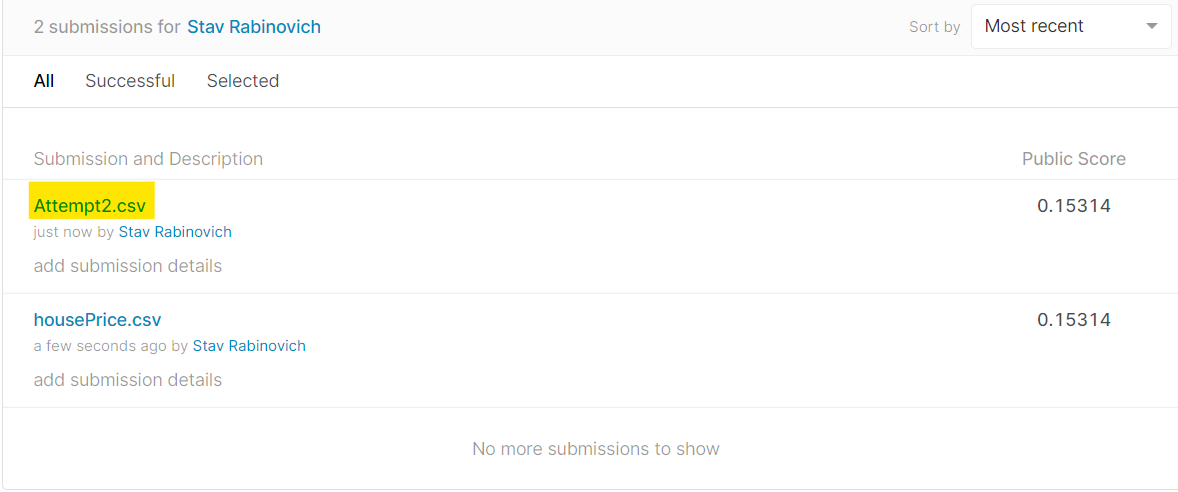

##**Reference**

[sklearn.ensemble.GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
More about set_config method from sklearn package
